In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys
import heapq
from functools import partial
from sklearn.model_selection import ParameterSampler
import glob, os
import time 

## Reading and inspecting the dataset

In [3]:
ratings = pd.read_csv('ml-1m-2/ratings.dat', sep="::", engine="python", names=['userId', 'movieId', 'rating', 'timestamp'])

ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

userId  movieId  rating           timestamp
0       1     1193       5 2000-12-31 22:12:40
1       1      661       3 2000-12-31 22:35:09
2       1      914       3 2000-12-31 22:32:48
3       1     3408       4 2000-12-31 22:04:35
4       1     2355       5 2001-01-06 23:38:11

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   userId     1000209 non-null  int64         
 1   movieId    1000209 non-null  int64         
 2   rating     1000209 non-null  int64         
 3   timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


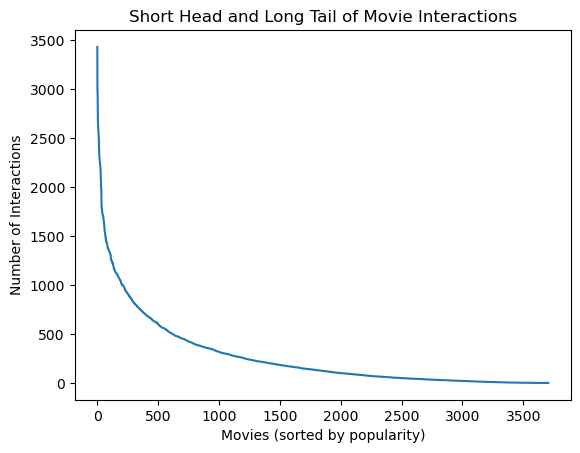

In [5]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


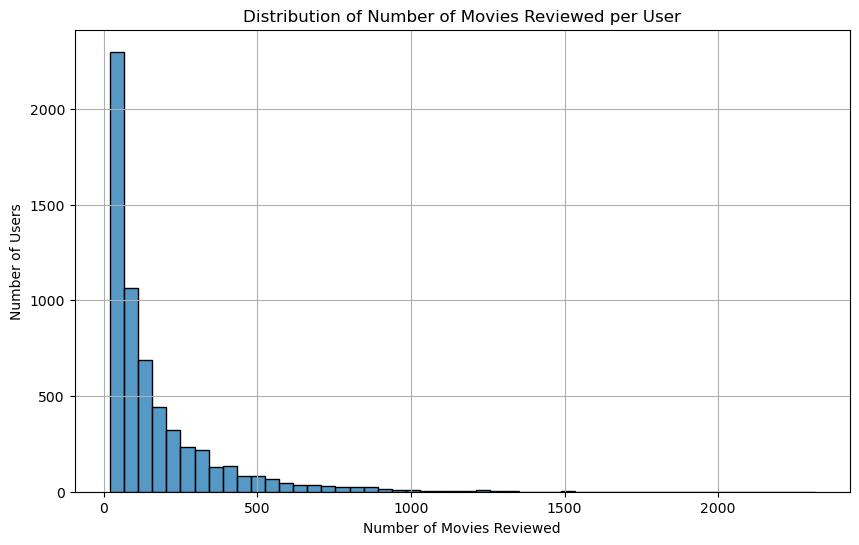

Number of users: 6040


In [6]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [7]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9553


## SVD Model

In [8]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
        recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_avg, recall_avg

In [9]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [10]:
def calculate_gini_of_recommendations(recommendation_counts):
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_counts.values()))

    # Calculate the Gini index
    gini_index = gini(recommendation_array)
    return gini_index

In [11]:
def arp_(users, recs, popularity):
    # Number of users for normalization
    num_users = len(users)
    res = 1 / num_users   # This will be multiplied by the total popularity later

    users_sum = 0  # Accumulates average popularity across all users

    for user in users:
        rec = recs[user]  # The recommended items for this user
        popularity_sum = 0  # Sum of popularity scores for this user's rec list

        for item in rec:
            # Lookup popularity of each item.
            # int(item) in case IDs are strings.
            p = popularity[int(item)]
            popularity_sum += p

        # Average popularity for this user's recommended list
        popularity_sum = popularity_sum / len(rec)

        # Add to global sum across users
        users_sum += popularity_sum

    # Multiply by normalization factor (1 / num_users)
    res *= users_sum
    return res


In [12]:
def aplt(users, recs, long_tail):
    # Number of users, used for averaging later
    num_users = len(users)
    res = 1 / num_users  # Normalization factor

    users_sum = 0  # Accumulates each user's long-tail ratio

    for user in users:
        rec = recs[user]  # Recommended items for this user

        # Count how many recommended items belong to the long-tail set.
        # Convert both to sets to allow fast intersection.
        num_long_tail = len(set(long_tail).intersection(set(rec)))

        # Fraction of recommendations that are long-tail
        users_sum += num_long_tail / len(rec)

    # Return the average long-tail fraction across all users
    res = res * users_sum
    return res


In [13]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_month(df, start_date, end_date):
    # TRAIN SET:
    # All ratings strictly before `end_date` (i.e., up to month n)
    train_df = df[df['timestamp'] < end_date].copy()

    # Define boundary for the test month (n+1)
    next_month = end_date + pd.DateOffset(months=1)

    # TEST SET:
    # Ratings where timestamp is:
    #   >= end_date  (start of month n+1)
    #   < next_month (end of month n+1)
    test_df  = df[(df['timestamp'] >= end_date) &
                  (df['timestamp'] < next_month)].copy()

    # Sanity checks to help inspect the time slice
    print("TEST RANGE:",  test_df['timestamp'].min(), "→", test_df['timestamp'].max())
    print("TRAIN RANGE:", train_df['timestamp'].min(), "→", train_df['timestamp'].max())

    # Ensure the test set does NOT spill into month n+2 or beyond
    assert (test_df['timestamp'] < next_month).all(), "Test set extends beyond n+1 month!"

    # Build Surprise trainset
    reader = Reader(rating_scale=(1, 5))
    train_data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)
    trainset = train_data.build_full_trainset()

    # Convert test_df into Surprise-compatible test tuples
    # Format: (userId, movieId, rating)
    testset = list(test_df[['userId','movieId','rating']]
                   .itertuples(index=False, name=None))

    return trainset, testset, train_df, test_df


In [14]:

# ==============================================================================
# Time-Series Cross-Validation for SVD Recommender System Hyperparameter Tuning
# ==============================================================================
# This script performs rolling-window validation to find optimal SVD parameters
# for each time period, ensuring no data leakage from future months.

# ------------------------------------------------------------------------------
# 1. Create Month Indices for Time-Based Splitting
# ------------------------------------------------------------------------------
# Sort ratings by timestamp and create monthly period indices
ratings = ratings.sort_values('timestamp').copy()
ratings['ym'] = ratings['timestamp'].dt.to_period('M')  # Convert to year-month periods

# Map each unique period to a sequential index (1, 2, 3, ...)
unique_periods = np.sort(ratings['ym'].unique())
period_to_idx = {p: i+1 for i, p in enumerate(unique_periods)}
ratings['month_idx'] = ratings['ym'].map(period_to_idx)

# Store the maximum month index for iteration bounds
M = int(ratings['month_idx'].max())

"""
# ------------------------------------------------------------------------------
# 2. Define Hyperparameter Search Space
# ------------------------------------------------------------------------------
# Note: This grid search setup only needs to run when exploring new parameter
# combinations. Can be skipped if using pre-saved parameters.

# Define the random search space for SVD hyperparameters
param_distributions = {
    'n_factors': [8, 16, 32, 64, 128, 256],      # Number of latent factors
    'n_epochs':  [30, 40, 50, 60, 80, 100],      # Training iterations
    'lr_all':    [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 0.1, 1.0],  # Learning rate
    'reg_all':   [1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1],       # Regularization
}

n_iter = 60           # Number of random parameter combinations to sample
random_state = None   # Random seed (None = use current time)

# Generate or use a traceable random seed
if random_state is None:
    chosen_seed = int(time.time()) % (2**32 - 1)  # Timestamp-based seed
else:
    chosen_seed = random_state

print(f"[INFO] Using random_state = {chosen_seed}")

# Sample random parameter combinations
rng = np.random.RandomState(chosen_seed)
sampled = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=rng))

# ------------------------------------------------------------------------------
# 3. Force Include Extreme Parameter Values
# ------------------------------------------------------------------------------
# Ensure the search space includes minimum and maximum parameter combinations
# to test the full range of possibilities
extreme_min = {'n_factors': 8,   'n_epochs': 30,  'lr_all': 1e-5, 'reg_all': 1e-5}
extreme_max = {'n_factors': 256, 'n_epochs': 100, 'lr_all': 1.0,  'reg_all': 0.1}

# Helper function to check if a parameter combination already exists in the list
def _contains(lst, d): 
    return any(all(x[k] == d[k] for k in d) for x in lst)

# Add extremes if not already sampled
if not _contains(sampled, extreme_min): 
    sampled.insert(0, extreme_min)
if not _contains(sampled, extreme_max): 
    sampled.insert(1, extreme_max)

# ------------------------------------------------------------------------------
# 4. Setup Surprise Library Data Conversion Functions
# ------------------------------------------------------------------------------
reader = Reader(rating_scale=(1, 5))

def to_surprise_trainset(df):
    data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)
    return data.build_full_trainset()

def to_surprise_testset(df):
    return list(zip(df['userId'].tolist(), df['movieId'].tolist(), df['rating'].tolist()))

# ------------------------------------------------------------------------------
# 5. Rolling Time-Window Cross-Validation
# ------------------------------------------------------------------------------
# For each time period t:
#   - Train on all data before t (months < t)
#   - Validate on month t to select best hyperparameters
#   - Test on month t+1 to evaluate generalization
# This prevents data leakage and simulates real-world deployment

rows = []                      # Store results for each time period
best_params_by_month = {}      # Store optimal parameters for each month

# Iterate through time periods (start at 2 since we need t-1 for train, t for val, t+1 for test)
for t in range(2, M):  # Last usable validation month is M-1 (to have M for test)
    # Split data by time periods
    train_df = ratings[ratings['month_idx'] <  t]      # All months before t
    val_df   = ratings[ratings['month_idx'] == t]      # Month t (validation)
    test_df  = ratings[ratings['month_idx'] == t+1]    # Month t+1 (test)
    
    # Skip if any split is empty
    if len(train_df)==0 or len(val_df)==0 or len(test_df)==0:
        continue

    # Convert to Surprise format
    trainset     = to_surprise_trainset(train_df)
    val_testset  = to_surprise_testset(val_df)
    test_testset = to_surprise_testset(test_df)

    # --------------------------------------------------------------------------
    # 5.1. Hyperparameter Selection on Validation Set
    # --------------------------------------------------------------------------
    # Train each parameter combination and evaluate on validation month
    # Selection criteria: highest Precision@10, tie-break with lowest RMSE
    
    cand_rows = []  # Store validation results for all parameter combinations
    
    for params in sampled:
        # Train SVD model with current parameter combination
        model = SVD(**params, random_state=random_state)
        model.fit(trainset)
        
        # Evaluate on validation set
        val_preds = model.test(val_testset)
        val_rmse  = accuracy.rmse(val_preds, verbose=False)
        
        # Calculate Precision@10 and Recall@10
        # threshold=3.5 means ratings >= 3.5 are considered "relevant"
        p_at_10, r_at_10 = precision_recall_at_k(val_preds, k=10, threshold=3.5)

        # Store results for this parameter combination
        cand_rows.append({
            'month': t,
            **params,
            'val_precision@10': p_at_10,
            'val_recall@10': r_at_10,
            'val_rmse': val_rmse
        })

    # Sort candidates: primary by Precision@10 (desc), secondary by RMSE (asc)
    cand_df = (pd.DataFrame(cand_rows)
               .sort_values(['val_precision@10','val_rmse'], ascending=[False, True])
               .reset_index(drop=True))
    
    # Extract best parameters (top row after sorting)
    best_params = {k: cand_df.loc[0, k] for k in ['n_factors','n_epochs','lr_all','reg_all']}
    
    # Store as native Python types (not numpy types) for JSON serialization
    best_params_by_month[t] = {
        'n_factors': int(best_params['n_factors']),
        'n_epochs' : int(best_params['n_epochs']),
        'lr_all'   : float(best_params['lr_all']),
        'reg_all'  : float(best_params['reg_all']),
    }

    # --------------------------------------------------------------------------
    # 5.2. Final Evaluation on Test Set
    # --------------------------------------------------------------------------
    # Retrain on train+validation data with best parameters, then test on t+1
    
    trainval_df = ratings[ratings['month_idx'] <= t]  # Combine train and validation
    trainvalset = to_surprise_trainset(trainval_df)

    # Train final model with optimal parameters
    final_model = SVD(**best_params_by_month[t], random_state=random_state)
    final_model.fit(trainvalset)
    
    # Evaluate on held-out test month
    test_preds = final_model.test(test_testset)
    test_rmse  = accuracy.rmse(test_preds, verbose=False)
    test_p_at_10, test_r_at_10 = precision_recall_at_k(test_preds, k=10, threshold=3.5)

    # Store combined validation and test results
    rows.append({
        'month': t,
        **best_params_by_month[t],
        'val_precision@10': cand_df.loc[0, 'val_precision@10'],
        'val_rmse': cand_df.loc[0, 'val_rmse'],
        'test_precision@10': test_p_at_10,
        'test_recall@10': test_r_at_10,
        'test_rmse': test_rmse
    })

# ------------------------------------------------------------------------------
# 6. Save Results
# ------------------------------------------------------------------------------
# Save chosen parameters and performance metrics for analysis
valtest_summary = pd.DataFrame(rows).sort_values('month')

# Save best parameters as JSON (for reuse in production/further analysis)
# In my case when i have ran the code five times i have saved the json with different names svd_params_by_month_valselect.json
#svd_params_by_month_valselect1.json, svd_params_by_month_valselect2.json etc. up to svd_params_by_month_valselect4.json.
with open('svd_params_by_month_valselect4.json','w') as f:
    json.dump(best_params_by_month, f, indent=2)

# Save validation and test metrics as CSV (for performance tracking)
valtest_summary.to_csv('svd_val_test_summary4.csv', index=False)

print("Saved:")
print(" - svd_params_by_month_valselect4.json (params chosen by validation Precision@10)")
print(" - svd_val_test_summary4.csv (validation & test metrics)")
display(valtest_summary.head())
"""

'\n# ------------------------------------------------------------------------------\n# 2. Define Hyperparameter Search Space\n# ------------------------------------------------------------------------------\n# Note: This grid search setup only needs to run when exploring new parameter\n# combinations. Can be skipped if using pre-saved parameters.\n\n# Define the random search space for SVD hyperparameters\nparam_distributions = {\n    \'n_factors\': [8, 16, 32, 64, 128, 256],      # Number of latent factors\n    \'n_epochs\':  [30, 40, 50, 60, 80, 100],      # Training iterations\n    \'lr_all\':    [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 0.1, 1.0],  # Learning rate\n    \'reg_all\':   [1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1],       # Regularization\n}\n\nn_iter = 60           # Number of random parameter combinations to sample\nrandom_state = None   # Random seed (None = use current time)\n\n# Generate or use a traceable random seed\nif random_state is None:\n    chosen_seed = int(time.time()) % (2

In [15]:
def evaluate_over_months(ratings, num_months, best_params_by_month=None):
    """
    Evaluate SVD recommender system performance over multiple months using rolling window.
    
    For each month:
    1. Split data into train (before month) and test (during month)
    2. Recalculate popularity groups from all cumulative data
    3. Train SVD model with month-specific or default parameters
    4. Generate top-10 recommendations for active users
    5. Calculate evaluation metrics (RMSE, Precision@10, Recall@10, ARP, APLT, Gini)
    
    Args:
        ratings: DataFrame with columns ['userId', 'movieId', 'rating', 'timestamp']
        num_months: Number of months to evaluate
        best_params_by_month: Optional dict mapping month -> SVD hyperparameters
    
    Returns:
        results: List of dicts with metrics for each month
        recommendations_df: DataFrame of all recommendations made
        train_test_sets: List of (trainset, testset, train_df, test_df) tuples for each month
        original_recs: Dict mapping month -> {user_id: [top 10 movie_ids]}
    """
    
    global G  # Global variable for popularity groups (short head, mid, long tail)
    
    # Initialize storage for results and recommendations
    results = []              # Metrics for each month
    recommendations = []      # All recommendations (user, movie, score, month)
    train_test_sets = []      # Train/test splits for each month
    original_recs = {}        # Top-10 recommendations per user per month
    
    # Start from the earliest timestamp in the dataset
    start_date = ratings['timestamp'].min()
    
    # ------------------------------------------------------------------------------
    # Iterate Through Each Month
    # ------------------------------------------------------------------------------
    for month_n in range(1, num_months + 1):
        # Define the current month's time window
        end_date = start_date + pd.DateOffset(months=1)
        logging.info(f"Processing month {month_n} ({start_date.date()} to {end_date.date()})...")
        
        # --------------------------------------------------------------------------
        # 1. Split Data: Train (before month) vs Test (during month)
        # --------------------------------------------------------------------------
        trainset, testset, train_df, test_df = split_by_month(ratings, start_date, end_date)
        train_test_sets.append((trainset, testset, train_df, test_df))
        
        # Get all data up to (but not including) the end of current month
        cumulative_data = ratings[ratings['timestamp'] < end_date]
        
        logging.info(f"  Calculating popularity groups (G) and scores from ALL cumulative data: {cumulative_data['timestamp'].min().date()} to {end_date.date()}")
        
        # --------------------------------------------------------------------------
        # 2. Recalculate Popularity Groups Based on Cumulative Data
        # --------------------------------------------------------------------------
        # G is a tuple/list: (short_head_items, mid_items, long_tail_items)
        # This represents the item popularity distribution
        G = calculate_popularity_groups(cumulative_data)
        long_tail_items = set(G[2])  # Extract long tail items for APLT metric
        
        logging.info(f"  Short head: {len(G[0])} items, Mid: {len(G[1])} items, Long tail: {len(G[2])} items")
        
        # --------------------------------------------------------------------------
        # 3. Calculate Normalized Popularity Scores for ARP Metric
        # --------------------------------------------------------------------------
        # Create a dictionary mapping each movie to its normalized popularity
        # Normalization: divide by max popularity to get values in [0, 1]
        if len(cumulative_data) > 0:
            popularity = cumulative_data['movieId'].value_counts(normalize=True).to_dict()
            max_popularity = max(popularity.values())
            popularity = {k: v / max_popularity for k, v in popularity.items()}
        else:
            popularity = {}
        
        logging.info(f"  Popularity dictionary contains {len(popularity)} items")
        
        # --------------------------------------------------------------------------
        # 4. Initialize and Train SVD Model
        # --------------------------------------------------------------------------
        # Load month-specific parameters if provided, otherwise use defaults
        params = {}
        if best_params_by_month is not None:
            # Try both integer and string keys (handles JSON loading quirks)
            params = best_params_by_month.get(month_n, best_params_by_month.get(str(month_n), {}))
        
        model = SVD(**params, random_state=42)
        
        logging.info(f"Starting training for month {month_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for month {month_n}.")
        
        # --------------------------------------------------------------------------
        # 5. Evaluate Model on Test Set
        # --------------------------------------------------------------------------
        predictions = model.test(testset)
        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)
        logging.info(f"month {month_n} RMSE: {rmse:.4f}")
        
        # --------------------------------------------------------------------------
        # 6. Generate Top-10 Recommendations for Active Users
        # --------------------------------------------------------------------------
        # Active users = users who appear in BOTH train and test sets
        # This ensures we can make predictions and evaluate them
        test_users = set(test_df['userId'].unique())
        train_users = set(train_df['userId'].unique())
        active_users = np.array(list(test_users & train_users))
        
        # Candidate items = all items in training set (known to the model)
        candidate_items = set(train_df['movieId'].unique())
        
        # Create lookup dict: user_id -> set of items they've already rated
        user_rated_dict = train_df.groupby('userId')['movieId'].apply(set).to_dict()
        
        recs = {}  # Will store: user_id -> [top 10 movie_ids]
        logging.info(f"Generating recommendations for {len(active_users)} active users in month {month_n}...")
        
        for user_id in tqdm(active_users, desc=f"Recommending for month {month_n}"):
            # Get items the user has already rated (to exclude from recommendations)
            rated_items = user_rated_dict.get(user_id, set())
            
            # Candidate items = all known items minus already rated items
            user_candidates = candidate_items - rated_items
            
            # Find top 100 items by predicted rating (for efficiency)
            top_candidates = heapq.nlargest(100, user_candidates,
                                            key=lambda movie: model.predict(user_id, movie).est)
            
            # Get predicted ratings for top 100 candidates
            user_recommendations = [(movie, model.predict(user_id, movie).est) for movie in top_candidates]
            
            # Sort by predicted rating and take top 10
            top_ten = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:10]
            
            # Store top 10 movie IDs for this user
            recs[user_id] = [movie for movie, rating in top_ten]
            
            # Store all top 100 recommendations with metadata (for analysis)
            recommendations.extend([(user_id, movie, rating, month_n) for movie, rating in user_recommendations])
        
        # Save a copy of this month's recommendations
        original_recs[month_n] = recs.copy()
        
        # --------------------------------------------------------------------------
        # 7. Calculate Diversity and Fairness Metrics
        # --------------------------------------------------------------------------
        # ARP (Average Recommendation Popularity): measures if recommendations favor popular items
        arp_value = arp_(active_users, recs, popularity)
        
        # APLT (Average Percentage of Long Tail): measures coverage of niche/unpopular items
        aplt_value = aplt(active_users, recs, long_tail_items)
        
        # Count how many times each movie was recommended across all users
        recommendation_count = Counter([movie_id for user_recs in recs.values() for movie_id in user_recs])
        
        # Gini Index: measures inequality in recommendation distribution (0=equal, 1=concentrated)
        gini_index = calculate_gini_of_recommendations(recommendation_count)
        
        # --------------------------------------------------------------------------
        # 8. Store Results for This Month
        # --------------------------------------------------------------------------
        results.append({
            'month': month_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })
        
        # Move to next month
        start_date = end_date
    
    # ------------------------------------------------------------------------------
    # 9. Save and Return Results
    # ------------------------------------------------------------------------------
    # Convert all recommendations to DataFrame and save to CSV
    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'month'])
    recommendations_df.to_csv("monthly_recommendations.csv", index=False)
    
    return results, recommendations_df, train_test_sets, original_recs

## Calibrated Popularity

In [16]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked


def calculate_popularity_groups(data, short_head_threshold=0.2, long_tail_threshold=0.8):
    """
    Divide items into three popularity groups: short head, mid-tail, and long tail.
    
    The "short head" contains the most popular items that account for a large portion
    of total interactions. The "long tail" contains niche items with few interactions.
    The "mid-tail" falls in between.
    
    Args:
        data: DataFrame with columns including 'movieId' and 'userId'
        short_head_threshold: Cumulative proportion to define short head cutoff (default: 0.2)
        long_tail_threshold: Cumulative proportion to define long tail start (default: 0.8)
    
    Returns:
        G: List of three lists [short_head_items, mid_tail_items, long_tail_items]
           where each sublist contains movieId values
    
    Example:
        If short_head_threshold=0.2, the short head contains the fewest items that
        collectively account for 20% of all user-item interactions (by cumulative sum).
    """
    
    # Handle empty dataset edge case
    if len(data) == 0:
        return [[], [], []]
    
    # --------------------------------------------------------------------------
    # 1. Calculate Total Interaction Count per Item
    # --------------------------------------------------------------------------
    # Count how many times each movie appears in the data (total ratings/interactions)
    item_pops_total = data.groupby('movieId').size()
    
    # Sort items by total popularity in descending order (most popular first)
    # Result: list of (movieId, count) tuples
    sorted_item_pops_map = sorted(item_pops_total.items(), reverse=True, 
                                   key=operator.itemgetter(1))
    
    # --------------------------------------------------------------------------
    # 2. Calculate Average Interactions per User for Each Item
    # --------------------------------------------------------------------------
    # Normalize by number of unique users to get average popularity per user
    # This gives a per-user popularity score for each item
    item_pops = data.groupby('movieId').size() / len(data.userId.unique())
    
    # --------------------------------------------------------------------------
    # 3. Find Split Points for Popularity Groups
    # --------------------------------------------------------------------------
    # Find the index where cumulative popularity reaches the threshold percentages
    # short_head_point: index where top items account for 20% of interactions
    short_head_point = find_short_head_split_point(sorted(item_pops, reverse=True), 
                                                    short_head_threshold)
    
    # mid_tail_point: index where top items account for 80% of interactions
    # (everything after this is long tail)
    mid_tail_point = find_short_head_split_point(sorted(item_pops, reverse=True), 
                                                  long_tail_threshold)
    
    # --------------------------------------------------------------------------
    # 4. Partition Items into Three Groups Based on Split Points
    # --------------------------------------------------------------------------
    # Define the three ranges: [0, short_head_point), [short_head_point, mid_tail_point), [mid_tail_point, end)
    indexes = [short_head_point, mid_tail_point, len(item_pops)]
    
    G = []  # Will store: [short_head_list, mid_tail_list, long_tail_list]
    s = 0   # Start index for current group
    
    # Extract items for each group from the sorted popularity map
    for i in range(len(indexes)):
        # Get movieIds from the sorted list for this range
        G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
        s = int(indexes[i])  # Update start index for next group
    
    # Return: G[0] = short head, G[1] = mid-tail, G[2] = long tail
    return G


In [17]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, month):
    print(f"Adding 'month' column for month {month}...")
    recs100['month'] = month  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'month' column is still there
    
    reranked['month'] = month  # Add the 'month' column manually here
    print("Checking reranked DataFrame after adding 'month':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [18]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [19]:

# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.1)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)


Lengths of G lists:
44
1137
2525
Calculating original user tolerance map...


## Running the model

In [20]:
# ================= MAIN =================
# Chose the hyperparameters for SVD, e.g. 'svd_params_by_month_valselect.json', 'svd_params_by_month_valselect1.json' etc.
# depends on what the json files are saved as when creating the hyper parameter combinations.
# When i run the code five times with different parameter combinations i change the json input, the monthly_results_with_params.csv file
# and the beyond_accuracy_per_month.csv file further down, by adding a number at the end of the filename, so that i can run all the 
# saved files when checking the averages and standard deviation for each run.
try:
    with open('svd_params_by_month_valselect.json') as f:
        best_params_by_month = {int(k): v for k, v in json.load(f).items()}
    logging.info("Loaded per-month SVD params from svd_params_by_month_valselect.json")
except FileNotFoundError:
    best_params_by_month = None
    logging.warning("svd_params_by_month_valselect.json not found — using Surprise defaults.")


num_months = 32
monthly_results, recommendations_df, train_test_sets, original_recs = evaluate_over_months(
    ratings, 
    num_months, 
    best_params_by_month=best_params_by_month
)

# Save monthly results
pd.DataFrame(monthly_results).to_csv("monthly_results_with_params.csv", index=False)


# CP re-ranking 
all_reranked_recommendations = []
for month in range(1, num_months + 1):
    print(f"Processing month {month}...")
    monthly_recommendations = recommendations_df[recommendations_df['month'] == month]
    
    print(f"Checking monthly recommendations for month {month}:")
    print(monthly_recommendations.head())
    
    logging.info(f"Applying CP re-ranking for month {month}...")
    reranked_recommendations = cali(monthly_recommendations, alpha, k, month)
    all_reranked_recommendations.append(reranked_recommendations)

# Combine & save CP outputs
reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)

2025-12-02 16:26:48,496 - Loaded per-month SVD params from svd_params_by_month_valselect.json
2025-12-02 16:26:48,498 - Processing month 1 (2000-04-25 to 2000-05-25)...
2025-12-02 16:26:48,542 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-05-25
2025-12-02 16:26:48,546 -   Short head: 91 items, Mid: 926 items, Long tail: 1856 items
2025-12-02 16:26:48,547 -   Popularity dictionary contains 2873 items
2025-12-02 16:26:48,547 - Starting training for month 1...


TEST RANGE: 2000-05-25 23:06:18 → 2000-06-25 22:36:20
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-05-25 23:04:07


2025-12-02 16:26:48,787 - Training complete for month 1.
2025-12-02 16:26:48,901 - month 1 RMSE: 1.0112
2025-12-02 16:26:48,909 - Generating recommendations for 93 active users in month 1...
Recommending for month 1: 100%|████████████████| 93/93 [00:00<00:00, 213.59it/s]
2025-12-02 16:26:49,359 - Processing month 2 (2000-05-25 to 2000-06-25)...
2025-12-02 16:26:49,435 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-06-25
2025-12-02 16:26:49,440 -   Short head: 95 items, Mid: 958 items, Long tail: 2059 items
2025-12-02 16:26:49,441 -   Popularity dictionary contains 3112 items
2025-12-02 16:26:49,441 - Starting training for month 2...


TEST RANGE: 2000-06-26 00:44:45 → 2000-07-25 23:01:31
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-06-25 22:36:20


2025-12-02 16:26:50,256 - Training complete for month 2.
2025-12-02 16:26:50,424 - month 2 RMSE: 0.9916
2025-12-02 16:26:50,440 - Generating recommendations for 131 active users in month 2...
Recommending for month 2: 100%|██████████████| 131/131 [00:00<00:00, 188.08it/s]
2025-12-02 16:26:51,140 - Processing month 3 (2000-06-25 to 2000-07-25)...
2025-12-02 16:26:51,269 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-07-25
2025-12-02 16:26:51,276 -   Short head: 98 items, Mid: 978 items, Long tail: 2208 items
2025-12-02 16:26:51,277 -   Popularity dictionary contains 3284 items
2025-12-02 16:26:51,278 - Starting training for month 3...


TEST RANGE: 2000-07-25 23:06:57 → 2000-08-25 23:05:29
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-07-25 23:01:31


2025-12-02 16:26:52,242 - Training complete for month 3.
2025-12-02 16:26:52,694 - month 3 RMSE: 1.0062
2025-12-02 16:26:52,723 - Generating recommendations for 183 active users in month 3...
Recommending for month 3: 100%|██████████████| 183/183 [00:00<00:00, 183.02it/s]
2025-12-02 16:26:53,726 - Processing month 4 (2000-07-25 to 2000-08-25)...
2025-12-02 16:26:53,919 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-08-25
2025-12-02 16:26:53,928 -   Short head: 107 items, Mid: 1027 items, Long tail: 2314 items
2025-12-02 16:26:53,932 -   Popularity dictionary contains 3448 items
2025-12-02 16:26:53,932 - Starting training for month 4...


TEST RANGE: 2000-08-25 23:06:07 → 2000-09-25 22:11:41
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-08-25 23:05:29


2025-12-02 16:27:06,733 - Training complete for month 4.
2025-12-02 16:27:06,956 - month 4 RMSE: 0.9702
2025-12-02 16:27:07,005 - Generating recommendations for 275 active users in month 4...
Recommending for month 4: 100%|██████████████| 275/275 [00:01<00:00, 175.58it/s]
2025-12-02 16:27:08,578 - Processing month 5 (2000-08-25 to 2000-09-25)...


TEST RANGE: 2000-09-25 23:06:40 → 2000-10-25 23:04:20
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-09-25 22:11:41


2025-12-02 16:27:08,806 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-09-25
2025-12-02 16:27:08,817 -   Short head: 107 items, Mid: 1029 items, Long tail: 2379 items
2025-12-02 16:27:08,820 -   Popularity dictionary contains 3515 items
2025-12-02 16:27:08,820 - Starting training for month 5...
2025-12-02 16:27:23,885 - Training complete for month 5.
2025-12-02 16:27:23,969 - month 5 RMSE: 0.9525
2025-12-02 16:27:24,034 - Generating recommendations for 258 active users in month 5...
Recommending for month 5: 100%|██████████████| 258/258 [00:01<00:00, 178.53it/s]
2025-12-02 16:27:25,484 - Processing month 6 (2000-09-25 to 2000-10-25)...


TEST RANGE: 2000-10-25 23:20:54 → 2000-11-25 23:05:31
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-10-25 23:04:20


2025-12-02 16:27:25,757 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-10-25
2025-12-02 16:27:25,769 -   Short head: 107 items, Mid: 1036 items, Long tail: 2406 items
2025-12-02 16:27:25,771 -   Popularity dictionary contains 3549 items
2025-12-02 16:27:25,772 - Starting training for month 6...
2025-12-02 16:27:42,121 - Training complete for month 6.
2025-12-02 16:27:43,103 - month 6 RMSE: 0.9926
2025-12-02 16:27:43,169 - Generating recommendations for 225 active users in month 6...
Recommending for month 6: 100%|██████████████| 225/225 [00:01<00:00, 174.86it/s]
2025-12-02 16:27:44,460 - Processing month 7 (2000-10-25 to 2000-11-25)...


TEST RANGE: 2000-11-25 23:05:41 → 2000-12-25 23:05:02
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-11-25 23:05:31


2025-12-02 16:27:44,850 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-11-25
2025-12-02 16:27:44,865 -   Short head: 107 items, Mid: 1045 items, Long tail: 2498 items
2025-12-02 16:27:44,871 -   Popularity dictionary contains 3650 items
2025-12-02 16:27:44,871 - Starting training for month 7...
2025-12-02 16:27:54,477 - Training complete for month 7.
2025-12-02 16:27:55,047 - month 7 RMSE: 0.9631
2025-12-02 16:27:55,165 - Generating recommendations for 588 active users in month 7...
Recommending for month 7: 100%|██████████████| 588/588 [00:03<00:00, 170.56it/s]
2025-12-02 16:27:58,621 - Processing month 8 (2000-11-25 to 2000-12-25)...


TEST RANGE: 2000-12-25 23:05:50 → 2001-01-25 22:27:32
TRAIN RANGE: 2000-04-25 23:05:32 → 2000-12-25 23:05:02


2025-12-02 16:27:59,063 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2000-12-25
2025-12-02 16:27:59,085 -   Short head: 108 items, Mid: 1051 items, Long tail: 2517 items
2025-12-02 16:27:59,090 -   Popularity dictionary contains 3676 items
2025-12-02 16:27:59,091 - Starting training for month 8...
2025-12-02 16:28:04,346 - Training complete for month 8.
2025-12-02 16:28:04,696 - month 8 RMSE: 0.9219
2025-12-02 16:28:04,849 - Generating recommendations for 553 active users in month 8...
Recommending for month 8: 100%|██████████████| 553/553 [00:03<00:00, 163.86it/s]
2025-12-02 16:28:08,233 - Processing month 9 (2000-12-25 to 2001-01-25)...


TEST RANGE: 2001-01-26 00:04:36 → 2001-02-25 22:33:06
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-01-25 22:27:32


2025-12-02 16:28:08,700 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-01-25
2025-12-02 16:28:08,720 -   Short head: 108 items, Mid: 1054 items, Long tail: 2521 items
2025-12-02 16:28:08,725 -   Popularity dictionary contains 3683 items
2025-12-02 16:28:08,725 - Starting training for month 9...
2025-12-02 16:28:10,562 - Training complete for month 9.
2025-12-02 16:28:10,600 - month 9 RMSE: 0.8767
2025-12-02 16:28:10,731 - Generating recommendations for 428 active users in month 9...
Recommending for month 9: 100%|██████████████| 428/428 [00:02<00:00, 157.90it/s]
2025-12-02 16:28:13,449 - Processing month 10 (2001-01-25 to 2001-02-25)...


TEST RANGE: 2001-02-25 23:28:35 → 2001-03-25 22:08:59
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-02-25 22:33:06


2025-12-02 16:28:13,925 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-02-25
2025-12-02 16:28:13,949 -   Short head: 109 items, Mid: 1055 items, Long tail: 2520 items
2025-12-02 16:28:13,956 -   Popularity dictionary contains 3684 items
2025-12-02 16:28:13,956 - Starting training for month 10...
2025-12-02 16:28:18,655 - Training complete for month 10.
2025-12-02 16:28:18,678 - month 10 RMSE: 0.8307
2025-12-02 16:28:18,848 - Generating recommendations for 315 active users in month 10...
Recommending for month 10: 100%|█████████████| 315/315 [00:01<00:00, 161.02it/s]
2025-12-02 16:28:20,810 - Processing month 11 (2001-02-25 to 2001-03-25)...


TEST RANGE: 2001-03-25 23:33:10 → 2001-04-25 22:45:20
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-03-25 22:08:59


2025-12-02 16:28:21,298 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-03-25
2025-12-02 16:28:21,326 -   Short head: 109 items, Mid: 1056 items, Long tail: 2520 items
2025-12-02 16:28:21,332 -   Popularity dictionary contains 3685 items
2025-12-02 16:28:21,332 - Starting training for month 11...
2025-12-02 16:28:26,195 - Training complete for month 11.
2025-12-02 16:28:26,215 - month 11 RMSE: 0.8909
2025-12-02 16:28:26,419 - Generating recommendations for 307 active users in month 11...
Recommending for month 11: 100%|█████████████| 307/307 [00:01<00:00, 167.93it/s]
2025-12-02 16:28:28,254 - Processing month 12 (2001-03-25 to 2001-04-25)...


TEST RANGE: 2001-04-25 23:20:22 → 2001-05-25 21:47:35
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-04-25 22:45:20


2025-12-02 16:28:29,409 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-04-25
2025-12-02 16:28:29,438 -   Short head: 109 items, Mid: 1058 items, Long tail: 2520 items
2025-12-02 16:28:29,445 -   Popularity dictionary contains 3687 items
2025-12-02 16:28:29,445 - Starting training for month 12...
2025-12-02 16:29:01,522 - Training complete for month 12.
2025-12-02 16:29:01,538 - month 12 RMSE: 0.8747
2025-12-02 16:29:01,783 - Generating recommendations for 253 active users in month 12...
Recommending for month 12: 100%|█████████████| 253/253 [00:01<00:00, 153.71it/s]
2025-12-02 16:29:03,436 - Processing month 13 (2001-04-25 to 2001-05-25)...


TEST RANGE: 2001-05-25 23:22:30 → 2001-06-25 22:42:08
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-05-25 21:47:35


2025-12-02 16:29:04,027 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-05-25
2025-12-02 16:29:04,060 -   Short head: 110 items, Mid: 1059 items, Long tail: 2518 items
2025-12-02 16:29:04,066 -   Popularity dictionary contains 3687 items
2025-12-02 16:29:04,067 - Starting training for month 13...
2025-12-02 16:29:07,181 - Training complete for month 13.
2025-12-02 16:29:07,209 - month 13 RMSE: 0.8648
2025-12-02 16:29:07,472 - Generating recommendations for 293 active users in month 13...
Recommending for month 13: 100%|█████████████| 293/293 [00:01<00:00, 162.57it/s]
2025-12-02 16:29:09,281 - Processing month 14 (2001-05-25 to 2001-06-25)...


TEST RANGE: 2001-06-25 23:21:56 → 2001-07-25 22:04:18
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-06-25 22:42:08


2025-12-02 16:29:09,819 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-06-25
2025-12-02 16:29:09,847 -   Short head: 110 items, Mid: 1060 items, Long tail: 2518 items
2025-12-02 16:29:09,854 -   Popularity dictionary contains 3688 items
2025-12-02 16:29:09,854 - Starting training for month 14...
2025-12-02 16:29:14,993 - Training complete for month 14.
2025-12-02 16:29:15,008 - month 14 RMSE: 0.8582
2025-12-02 16:29:15,160 - Generating recommendations for 288 active users in month 14...
Recommending for month 14: 100%|█████████████| 288/288 [00:01<00:00, 166.19it/s]
2025-12-02 16:29:16,898 - Processing month 15 (2001-06-25 to 2001-07-25)...


TEST RANGE: 2001-07-25 23:24:15 → 2001-08-25 22:50:55
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-07-25 22:04:18


2025-12-02 16:29:17,396 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-07-25
2025-12-02 16:29:17,417 -   Short head: 110 items, Mid: 1060 items, Long tail: 2518 items
2025-12-02 16:29:17,422 -   Popularity dictionary contains 3688 items
2025-12-02 16:29:17,422 - Starting training for month 15...
2025-12-02 16:29:50,752 - Training complete for month 15.
2025-12-02 16:29:50,775 - month 15 RMSE: 0.8964
2025-12-02 16:29:52,084 - Generating recommendations for 259 active users in month 15...
Recommending for month 15: 100%|█████████████| 259/259 [00:01<00:00, 160.35it/s]
2025-12-02 16:29:53,710 - Processing month 16 (2001-07-25 to 2001-08-25)...


TEST RANGE: 2001-08-26 00:37:04 → 2001-09-25 22:21:12
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-08-25 22:50:55


2025-12-02 16:29:54,386 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-08-25
2025-12-02 16:29:54,408 -   Short head: 111 items, Mid: 1060 items, Long tail: 2517 items
2025-12-02 16:29:54,416 -   Popularity dictionary contains 3688 items
2025-12-02 16:29:54,418 - Starting training for month 16...
2025-12-02 16:29:59,777 - Training complete for month 16.
2025-12-02 16:29:59,797 - month 16 RMSE: 0.8449
2025-12-02 16:30:00,068 - Generating recommendations for 204 active users in month 16...
Recommending for month 16: 100%|█████████████| 204/204 [00:01<00:00, 154.33it/s]
2025-12-02 16:30:01,396 - Processing month 17 (2001-08-25 to 2001-09-25)...


TEST RANGE: 2001-09-26 00:45:55 → 2001-10-25 22:06:03
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-09-25 22:21:12


2025-12-02 16:30:01,995 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-09-25
2025-12-02 16:30:02,022 -   Short head: 111 items, Mid: 1061 items, Long tail: 2521 items
2025-12-02 16:30:02,027 -   Popularity dictionary contains 3693 items
2025-12-02 16:30:02,027 - Starting training for month 17...
2025-12-02 16:30:04,270 - Training complete for month 17.
2025-12-02 16:30:04,279 - month 17 RMSE: 0.8673
2025-12-02 16:30:04,460 - Generating recommendations for 175 active users in month 17...
Recommending for month 17: 100%|█████████████| 175/175 [00:01<00:00, 153.16it/s]
2025-12-02 16:30:05,606 - Processing month 18 (2001-09-25 to 2001-10-25)...


TEST RANGE: 2001-10-26 04:34:03 → 2001-11-25 22:18:17
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-10-25 22:06:03


2025-12-02 16:30:06,115 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-10-25
2025-12-02 16:30:06,141 -   Short head: 111 items, Mid: 1062 items, Long tail: 2520 items
2025-12-02 16:30:06,145 -   Popularity dictionary contains 3693 items
2025-12-02 16:30:06,145 - Starting training for month 18...
2025-12-02 16:30:12,433 - Training complete for month 18.
2025-12-02 16:30:12,445 - month 18 RMSE: 0.9913
2025-12-02 16:30:12,617 - Generating recommendations for 189 active users in month 18...
Recommending for month 18: 100%|█████████████| 189/189 [00:01<00:00, 164.07it/s]
2025-12-02 16:30:13,773 - Processing month 19 (2001-10-25 to 2001-11-25)...


TEST RANGE: 2001-11-25 23:22:50 → 2001-12-25 21:15:55
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-11-25 22:18:17


2025-12-02 16:30:14,297 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-11-25
2025-12-02 16:30:14,322 -   Short head: 111 items, Mid: 1062 items, Long tail: 2521 items
2025-12-02 16:30:14,328 -   Popularity dictionary contains 3694 items
2025-12-02 16:30:14,328 - Starting training for month 19...
2025-12-02 16:30:47,872 - Training complete for month 19.
2025-12-02 16:30:47,884 - month 19 RMSE: 0.8661
2025-12-02 16:30:48,167 - Generating recommendations for 174 active users in month 19...
Recommending for month 19: 100%|█████████████| 174/174 [00:01<00:00, 170.63it/s]
2025-12-02 16:30:49,191 - Processing month 20 (2001-11-25 to 2001-12-25)...


TEST RANGE: 2001-12-26 00:48:01 → 2002-01-25 21:30:28
TRAIN RANGE: 2000-04-25 23:05:32 → 2001-12-25 21:15:55


2025-12-02 16:30:49,732 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2001-12-25
2025-12-02 16:30:49,759 -   Short head: 111 items, Mid: 1063 items, Long tail: 2521 items
2025-12-02 16:30:49,765 -   Popularity dictionary contains 3695 items
2025-12-02 16:30:49,765 - Starting training for month 20...
2025-12-02 16:31:23,395 - Training complete for month 20.
2025-12-02 16:31:25,581 - month 20 RMSE: 0.8313
2025-12-02 16:31:25,931 - Generating recommendations for 228 active users in month 20...
Recommending for month 20: 100%|█████████████| 228/228 [00:01<00:00, 166.86it/s]
2025-12-02 16:31:27,303 - Processing month 21 (2001-12-25 to 2002-01-25)...


TEST RANGE: 2002-01-26 00:51:11 → 2002-02-25 21:08:15
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-01-25 21:30:28


2025-12-02 16:31:27,901 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-01-25
2025-12-02 16:31:27,934 -   Short head: 111 items, Mid: 1064 items, Long tail: 2521 items
2025-12-02 16:31:27,939 -   Popularity dictionary contains 3696 items
2025-12-02 16:31:27,940 - Starting training for month 21...
2025-12-02 16:31:33,279 - Training complete for month 21.
2025-12-02 16:31:33,291 - month 21 RMSE: 0.8429
2025-12-02 16:31:33,459 - Generating recommendations for 196 active users in month 21...
Recommending for month 21: 100%|█████████████| 196/196 [00:01<00:00, 168.05it/s]
2025-12-02 16:31:34,630 - Processing month 22 (2002-01-25 to 2002-02-25)...


TEST RANGE: 2002-02-25 23:22:38 → 2002-03-25 21:39:37
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-02-25 21:08:15


2025-12-02 16:31:35,124 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-02-25
2025-12-02 16:31:35,154 -   Short head: 111 items, Mid: 1064 items, Long tail: 2524 items
2025-12-02 16:31:35,160 -   Popularity dictionary contains 3699 items
2025-12-02 16:31:35,160 - Starting training for month 22...
2025-12-02 16:31:38,832 - Training complete for month 22.
2025-12-02 16:31:38,840 - month 22 RMSE: 0.9480
2025-12-02 16:31:39,008 - Generating recommendations for 159 active users in month 22...
Recommending for month 22: 100%|█████████████| 159/159 [00:01<00:00, 155.69it/s]
2025-12-02 16:31:40,033 - Processing month 23 (2002-02-25 to 2002-03-25)...


TEST RANGE: 2002-03-26 03:10:52 → 2002-04-25 18:45:53
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-03-25 21:39:37


2025-12-02 16:31:40,574 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-03-25
2025-12-02 16:31:40,612 -   Short head: 111 items, Mid: 1065 items, Long tail: 2525 items
2025-12-02 16:31:40,616 -   Popularity dictionary contains 3701 items
2025-12-02 16:31:40,616 - Starting training for month 23...
2025-12-02 16:31:44,727 - Training complete for month 23.
2025-12-02 16:31:44,737 - month 23 RMSE: 0.9005
2025-12-02 16:31:44,951 - Generating recommendations for 146 active users in month 23...
Recommending for month 23: 100%|█████████████| 146/146 [00:00<00:00, 148.57it/s]
2025-12-02 16:31:45,937 - Processing month 24 (2002-03-25 to 2002-04-25)...


TEST RANGE: 2002-04-26 04:03:03 → 2002-05-25 22:42:45
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-04-25 18:45:53


2025-12-02 16:31:46,471 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-04-25
2025-12-02 16:31:46,503 -   Short head: 112 items, Mid: 1065 items, Long tail: 2524 items
2025-12-02 16:31:46,509 -   Popularity dictionary contains 3701 items
2025-12-02 16:31:46,509 - Starting training for month 24...
2025-12-02 16:31:52,092 - Training complete for month 24.
2025-12-02 16:31:52,101 - month 24 RMSE: 0.8732
2025-12-02 16:31:52,337 - Generating recommendations for 151 active users in month 24...
Recommending for month 24: 100%|█████████████| 151/151 [00:00<00:00, 164.80it/s]
2025-12-02 16:31:53,258 - Processing month 25 (2002-04-25 to 2002-05-25)...


TEST RANGE: 2002-05-26 01:33:15 → 2002-06-25 21:45:17
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-05-25 22:42:45


2025-12-02 16:31:53,849 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-05-25
2025-12-02 16:31:53,884 -   Short head: 112 items, Mid: 1066 items, Long tail: 2523 items
2025-12-02 16:31:53,889 -   Popularity dictionary contains 3701 items
2025-12-02 16:31:53,890 - Starting training for month 25...
2025-12-02 16:32:28,385 - Training complete for month 25.
2025-12-02 16:32:28,397 - month 25 RMSE: 0.8871
2025-12-02 16:32:28,773 - Generating recommendations for 154 active users in month 25...
Recommending for month 25: 100%|██████████████| 154/154 [00:05<00:00, 27.64it/s]
2025-12-02 16:32:34,350 - Processing month 26 (2002-05-25 to 2002-06-25)...


TEST RANGE: 2002-06-26 00:20:32 → 2002-07-25 22:22:20
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-06-25 21:45:17


2025-12-02 16:32:35,030 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-06-25
2025-12-02 16:32:35,062 -   Short head: 112 items, Mid: 1066 items, Long tail: 2523 items
2025-12-02 16:32:35,067 -   Popularity dictionary contains 3701 items
2025-12-02 16:32:35,068 - Starting training for month 26...
2025-12-02 16:32:47,754 - Training complete for month 26.
2025-12-02 16:32:47,764 - month 26 RMSE: 0.9323
2025-12-02 16:32:48,094 - Generating recommendations for 155 active users in month 26...
Recommending for month 26: 100%|█████████████| 155/155 [00:00<00:00, 179.92it/s]
2025-12-02 16:32:48,960 - Processing month 27 (2002-06-25 to 2002-07-25)...


TEST RANGE: 2002-07-26 04:14:46 → 2002-08-25 19:09:05
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-07-25 22:22:20


2025-12-02 16:32:49,499 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-07-25
2025-12-02 16:32:49,520 -   Short head: 112 items, Mid: 1067 items, Long tail: 2523 items
2025-12-02 16:32:49,526 -   Popularity dictionary contains 3702 items
2025-12-02 16:32:49,526 - Starting training for month 27...
2025-12-02 16:32:56,464 - Training complete for month 27.
2025-12-02 16:32:56,475 - month 27 RMSE: 0.9463
2025-12-02 16:32:56,796 - Generating recommendations for 143 active users in month 27...
Recommending for month 27: 100%|█████████████| 143/143 [00:00<00:00, 151.89it/s]
2025-12-02 16:32:57,741 - Processing month 28 (2002-07-25 to 2002-08-25)...


TEST RANGE: 2002-08-26 01:49:24 → 2002-09-25 17:48:05
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-08-25 19:09:05


2025-12-02 16:32:58,347 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-08-25
2025-12-02 16:32:58,380 -   Short head: 112 items, Mid: 1067 items, Long tail: 2524 items
2025-12-02 16:32:58,387 -   Popularity dictionary contains 3703 items
2025-12-02 16:32:58,387 - Starting training for month 28...
2025-12-02 16:33:05,611 - Training complete for month 28.
2025-12-02 16:33:05,618 - month 28 RMSE: 0.8515
2025-12-02 16:33:05,936 - Generating recommendations for 115 active users in month 28...
Recommending for month 28: 100%|█████████████| 115/115 [00:00<00:00, 174.88it/s]
2025-12-02 16:33:06,598 - Processing month 29 (2002-08-25 to 2002-09-25)...


TEST RANGE: 2002-09-26 00:44:45 → 2002-10-25 18:58:09
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-09-25 17:48:05


2025-12-02 16:33:07,243 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-09-25
2025-12-02 16:33:07,275 -   Short head: 112 items, Mid: 1068 items, Long tail: 2523 items
2025-12-02 16:33:07,280 -   Popularity dictionary contains 3703 items
2025-12-02 16:33:07,280 - Starting training for month 29...
2025-12-02 16:33:14,933 - Training complete for month 29.
2025-12-02 16:33:14,938 - month 29 RMSE: 0.8852
2025-12-02 16:33:15,265 - Generating recommendations for 118 active users in month 29...
Recommending for month 29: 100%|█████████████| 118/118 [00:00<00:00, 158.05it/s]
2025-12-02 16:33:16,017 - Processing month 30 (2002-09-25 to 2002-10-25)...


TEST RANGE: 2002-10-26 01:50:39 → 2002-11-25 11:48:33
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-10-25 18:58:09


2025-12-02 16:33:16,672 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-10-25
2025-12-02 16:33:16,705 -   Short head: 112 items, Mid: 1068 items, Long tail: 2525 items
2025-12-02 16:33:16,710 -   Popularity dictionary contains 3705 items
2025-12-02 16:33:16,711 - Starting training for month 30...
2025-12-02 16:33:21,599 - Training complete for month 30.
2025-12-02 16:33:21,607 - month 30 RMSE: 0.8690
2025-12-02 16:33:21,916 - Generating recommendations for 130 active users in month 30...
Recommending for month 30: 100%|█████████████| 130/130 [00:00<00:00, 174.87it/s]
2025-12-02 16:33:22,664 - Processing month 31 (2002-10-25 to 2002-11-25)...


TEST RANGE: 2002-11-25 23:39:47 → 2002-12-25 15:35:15
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-11-25 11:48:33


2025-12-02 16:33:23,307 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-11-25
2025-12-02 16:33:23,339 -   Short head: 112 items, Mid: 1068 items, Long tail: 2526 items
2025-12-02 16:33:23,347 -   Popularity dictionary contains 3706 items
2025-12-02 16:33:23,347 - Starting training for month 31...
2025-12-02 16:33:25,848 - Training complete for month 31.
2025-12-02 16:33:25,854 - month 31 RMSE: 0.9021
2025-12-02 16:33:26,158 - Generating recommendations for 119 active users in month 31...
Recommending for month 31: 100%|█████████████| 119/119 [00:00<00:00, 155.00it/s]
2025-12-02 16:33:26,930 - Processing month 32 (2002-11-25 to 2002-12-25)...


TEST RANGE: 2002-12-25 23:15:44 → 2003-01-25 20:54:29
TRAIN RANGE: 2000-04-25 23:05:32 → 2002-12-25 15:35:15


2025-12-02 16:33:33,193 -   Calculating popularity groups (G) and scores from ALL cumulative data: 2000-04-25 to 2002-12-25
2025-12-02 16:33:33,232 -   Short head: 112 items, Mid: 1068 items, Long tail: 2526 items
2025-12-02 16:33:33,237 -   Popularity dictionary contains 3706 items
2025-12-02 16:33:33,237 - Starting training for month 32...
2025-12-02 16:33:35,630 - Training complete for month 32.
2025-12-02 16:33:35,637 - month 32 RMSE: 1.0254
2025-12-02 16:33:35,958 - Generating recommendations for 137 active users in month 32...
Recommending for month 32: 100%|█████████████| 137/137 [00:00<00:00, 150.29it/s]
2025-12-02 16:33:39,220 - Applying CP re-ranking for month 1...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

Processing month 1...
Checking monthly recommendations for month 1:
   userId  movieId    rating  month
0    5636     3435  4.523465      1
1    5636     2959  4.480746      1
2    5636      923  4.451680      1
3    5636     3307  4.438799      1
4    5636      908  4.423895      1
Adding 'month' column for month 1...
Checking recs100 before reranking:
   userId  movieId    rating  month
0    5636     3435  4.523465      1
1    5636     2959  4.480746      1
2    5636      923  4.451680      1
3    5636     3307  4.438799      1
4    5636      908  4.423895      1
####### Starting the reranking...


100%|███████████████████████████████████████████| 93/93 [00:04<00:00, 23.16it/s]
2025-12-02 16:33:43,246 - Applying CP re-ranking for month 2...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636     3435  4.523465
1    5636     2959  4.480746
2    5636      923  4.451680
3    5636     3307  4.438799
4    5636     3504  4.295665
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636     3435  4.523465      1
1    5636     2959  4.480746      1
2    5636      923  4.451680      1
3    5636     3307  4.438799      1
4    5636     3504  4.295665      1
Processing month 2...
Checking monthly recommendations for month 2:
      userId  movieId  rating  month
9300    5643      899     5.0      2
9301    5643     1060     5.0      2
9302    5643     1131     5.0      2
9303    5643     1732     5.0      2
9304    5643     3134     5.0      2
Adding 'month' column for month 2...
Checking recs100 before reranking:
      userId  movieId  rating  month
9300    5643      899     5.0      2
9301    5643     1060     5.0      2
9302    5643     1131     5.0      2
9303    5643     1732

100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.30it/s]
2025-12-02 16:33:48,878 - Applying CP re-ranking for month 3...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    5643      899     5.0
1    5643     1060     5.0
2    5643     1131     5.0
3    5643     1732     5.0
4    5643     3134     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    5643      899     5.0      2
1    5643     1060     5.0      2
2    5643     1131     5.0      2
3    5643     1732     5.0      2
4    5643     3134     5.0      2
Processing month 3...
Checking monthly recommendations for month 3:
       userId  movieId    rating  month
22400    4611     1193  4.429452      3
22401    4611     3114  4.365340      3
22402    4611      912  4.355174      3
22403    4611      922  4.332534      3
22404    4611     1198  4.332426      3
Adding 'month' column for month 3...
Checking recs100 before reranking:
       userId  movieId    rating  month
22400    4611     1193  4.429452      3
22401    4611     3114  4.365340      3
22402    4611      912  4.355174      3
22403    4611  

100%|█████████████████████████████████████████| 183/183 [00:07<00:00, 23.12it/s]
2025-12-02 16:33:56,805 - Applying CP re-ranking for month 4...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4611     1193  4.429452
1    4611     3030  4.187200
2    4611     1250  4.232210
3    4611      922  4.332534
4    4611      904  4.236053
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4611     1193  4.429452      3
1    4611     3030  4.187200      3
2    4611     1250  4.232210      3
3    4611      922  4.332534      3
4    4611      904  4.236053      3
Processing month 4...
Checking monthly recommendations for month 4:
       userId  movieId    rating  month
40700    5636     3022  4.646187      4
40701    5636     1178  4.609176      4
40702    5636     1204  4.557248      4
40703    5636      923  4.557069      4
40704    5636     1237  4.478753      4
Adding 'month' column for month 4...
Checking recs100 before reranking:
       userId  movieId    rating  month
40700    5636     3022  4.646187      4
40701    5636     1178  4.609176      4
40702    5636     1204  4.55724

100%|█████████████████████████████████████████| 275/275 [00:11<00:00, 23.17it/s]
2025-12-02 16:34:08,690 - Applying CP re-ranking for month 5...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636     3022  4.646187
1    5636     1178  4.609176
2    5636     1204  4.557248
3    5636      923  4.557069
4    5636     1237  4.478753
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636     3022  4.646187      4
1    5636     1178  4.609176      4
2    5636     1204  4.557248      4
3    5636      923  4.557069      4
4    5636     1237  4.478753      4
Processing month 5...
Checking monthly recommendations for month 5:
       userId  movieId    rating  month
68200    5636     1204  4.613333      5
68201    5636     3022  4.608715      5
68202    5636     1178  4.574748      5
68203    5636      923  4.504532      5
68204    5636      922  4.467963      5
Adding 'month' column for month 5...
Checking recs100 before reranking:
       userId  movieId    rating  month
68200    5636     1204  4.613333      5
68201    5636     3022  4.608715      5
68202    5636     1178  4.57474

 78%|███████████████████████████████▉         | 201/258 [00:08<00:02, 22.79it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 258/258 [00:11<00:00, 22.93it/s]
2025-12-02 16:34:19,955 - Applying CP re-ranking for month 6...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636     1204  4.613333
1    5636     3022  4.608715
2    5636     1178  4.574748
3    5636      923  4.504532
4    5636      922  4.467963
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636     1204  4.613333      5
1    5636     3022  4.608715      5
2    5636     1178  4.574748      5
3    5636      923  4.504532      5
4    5636      922  4.467963      5
Processing month 6...
Checking monthly recommendations for month 6:
       userId  movieId    rating  month
94000    3072      670  4.558346      6
94001    3072      750  4.483771      6
94002    3072     1446  4.476034      6
94003    3072     2360  4.440467      6
94004    3072     1176  4.414550      6
Adding 'month' column for month 6...
Checking recs100 before reranking:
       userId  movieId    rating  month
94000    3072      670  4.558346      6
94001    3072      750  4.483771      6
94002    3072     1446  4.47603

100%|█████████████████████████████████████████| 225/225 [00:09<00:00, 22.94it/s]
2025-12-02 16:34:29,778 - Applying CP re-ranking for month 7...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3072      670  4.558346
1    3072      750  4.483771
2    3072     1446  4.476034
3    3072     2360  4.440467
4    3072      922  4.237462
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3072      670  4.558346      6
1    3072      750  4.483771      6
2    3072     1446  4.476034      6
3    3072     2360  4.440467      6
4    3072      922  4.237462      6
Processing month 7...
Checking monthly recommendations for month 7:
        userId  movieId    rating  month
116500    2050     3306  4.912745      7
116501    2050     2503  4.890322      7
116502    2050     2905  4.835505      7
116503    2050      527  4.831589      7
116504    2050     2019  4.810768      7
Adding 'month' column for month 7...
Checking recs100 before reranking:
        userId  movieId    rating  month
116500    2050     3306  4.912745      7
116501    2050     2503  4.890322      7
116502    2050     290

100%|█████████████████████████████████████████| 588/588 [00:25<00:00, 22.80it/s]
2025-12-02 16:34:55,590 - Applying CP re-ranking for month 8...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2050     3306  4.912745
1    2050     2503  4.890322
2    2050     1204  4.729896
3    2050      527  4.831589
4    2050     2019  4.810768
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2050     3306  4.912745      7
1    2050     2503  4.890322      7
2    2050     1204  4.729896      7
3    2050      527  4.831589      7
4    2050     2019  4.810768      7
Processing month 8...
Checking monthly recommendations for month 8:
        userId  movieId    rating  month
175300    2050     1148  5.000000      8
175301    2050     1207  5.000000      8
175302    2050     1307  5.000000      8
175303    2050     3022  5.000000      8
175304    2050     1947  4.992891      8
Adding 'month' column for month 8...
Checking recs100 before reranking:
        userId  movieId    rating  month
175300    2050     1148  5.000000      8
175301    2050     1207  5.000000      8
175302    2050     130

100%|█████████████████████████████████████████| 553/553 [00:24<00:00, 22.35it/s]
2025-12-02 16:35:20,359 - Applying CP re-ranking for month 9...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2050     1148  5.000000
1    2050     1207  5.000000
2    2050     1307  5.000000
3    2050     3022  5.000000
4    2050     1947  4.992891
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2050     1148  5.000000      8
1    2050     1207  5.000000      8
2    2050     1307  5.000000      8
3    2050     3022  5.000000      8
4    2050     1947  4.992891      8
Processing month 9...
Checking monthly recommendations for month 9:
        userId  movieId  rating  month
230600      10       73     5.0      9
230601      10      214     5.0      9
230602      10      668     5.0      9
230603      10      670     5.0      9
230604      10     2572     5.0      9
Adding 'month' column for month 9...
Checking recs100 before reranking:
        userId  movieId  rating  month
230600      10       73     5.0      9
230601      10      214     5.0      9
230602      10      668     5.0      9
2

100%|█████████████████████████████████████████| 428/428 [00:19<00:00, 22.41it/s]
2025-12-02 16:35:39,473 - Applying CP re-ranking for month 10...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0      10       73  5.000000
1      10     3916  4.998901
2      10     3147  4.909100
3      10       17  4.966794
4      10     2572  5.000000
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0      10       73  5.000000      9
1      10     3916  4.998901      9
2      10     3147  4.909100      9
3      10       17  4.966794      9
4      10     2572  5.000000      9
Processing month 10...
Checking monthly recommendations for month 10:
        userId  movieId    rating  month
273400    2060     1198  4.596065     10
273401    2060      919  4.531785     10
273402    2060     3508  4.501184     10
273403    2060     2804  4.471098     10
273404    2060     3552  4.453919     10
Adding 'month' column for month 10...
Checking recs100 before reranking:
        userId  movieId    rating  month
273400    2060     1198  4.596065     10
273401    2060      919  4.531785     10
273402    2060     

 44%|█████████████████▉                       | 138/315 [00:06<00:08, 21.92it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 315/315 [00:14<00:00, 22.37it/s]
2025-12-02 16:35:53,568 - Applying CP re-ranking for month 11...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2060     1198  4.596065
1    2060     3851  4.394937
2    2060     3508  4.501184
3    2060      953  4.389258
4    2060     3552  4.453919
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2060     1198  4.596065     10
1    2060     3851  4.394937     10
2    2060     3508  4.501184     10
3    2060      953  4.389258     10
4    2060     3552  4.453919     10
Processing month 11...
Checking monthly recommendations for month 11:
        userId  movieId    rating  month
304900    2057     1193  5.000000     11
304901    2057     1263  4.994570     11
304902    2057     3737  4.910311     11
304903    2057      858  4.891151     11
304904    2057     2503  4.874430     11
Adding 'month' column for month 11...
Checking recs100 before reranking:
        userId  movieId    rating  month
304900    2057     1193  5.000000     11
304901    2057     1263  4.994570     11
304902    2057     

100%|█████████████████████████████████████████| 307/307 [00:13<00:00, 22.56it/s]
2025-12-02 16:36:07,191 - Applying CP re-ranking for month 12...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2057     1193  5.000000
1    2057     1263  4.994570
2    2057     3737  4.910311
3    2057      858  4.891151
4    2057     1299  4.710716
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2057     1193  5.000000     11
1    2057     1263  4.994570     11
2    2057     3737  4.910311     11
3    2057      858  4.891151     11
4    2057     1299  4.710716     11
Processing month 12...
Checking monthly recommendations for month 12:
        userId  movieId  rating  month
335600    3074      356     5.0     12
335601    3074      720     5.0     12
335602    3074      912     5.0     12
335603    3074      913     5.0     12
335604    3074     1148     5.0     12
Adding 'month' column for month 12...
Checking recs100 before reranking:
        userId  movieId  rating  month
335600    3074      356     5.0     12
335601    3074      720     5.0     12
335602    3074      912     5.0     1

100%|█████████████████████████████████████████| 253/253 [00:11<00:00, 22.43it/s]
2025-12-02 16:36:18,485 - Applying CP re-ranking for month 13...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    3074      356     5.0
1    3074      720     5.0
2    3074      912     5.0
3    3074      913     5.0
4    3074     1148     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    3074      356     5.0     12
1    3074      720     5.0     12
2    3074      912     5.0     12
3    3074      913     5.0     12
4    3074     1148     5.0     12
Processing month 13...
Checking monthly recommendations for month 13:
        userId  movieId  rating  month
360900    3074      720     5.0     13
360901    3074      745     5.0     13
360902    3074      750     5.0     13
360903    3074      904     5.0     13
360904    3074      908     5.0     13
Adding 'month' column for month 13...
Checking recs100 before reranking:
        userId  movieId  rating  month
360900    3074      720     5.0     13
360901    3074      745     5.0     13
360902    3074      750     5.0     13
360903    3074      90

100%|█████████████████████████████████████████| 293/293 [00:13<00:00, 21.91it/s]
2025-12-02 16:36:31,876 - Applying CP re-ranking for month 14...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    3074      720     5.0
1    3074      745     5.0
2    3074      750     5.0
3    3074      904     5.0
4    3074      908     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    3074      720     5.0     13
1    3074      745     5.0     13
2    3074      750     5.0     13
3    3074      904     5.0     13
4    3074      908     5.0     13
Processing month 14...
Checking monthly recommendations for month 14:
        userId  movieId    rating  month
390200    4611     1035  5.000000     14
390201    4611     2905  4.767004     14
390202    4611     3092  4.713267     14
390203    4611      954  4.594202     14
390204    4611     3952  4.544205     14
Adding 'month' column for month 14...
Checking recs100 before reranking:
        userId  movieId    rating  month
390200    4611     1035  5.000000     14
390201    4611     2905  4.767004     14
390202    4611     3092  4.713267     14
39

100%|█████████████████████████████████████████| 288/288 [00:12<00:00, 22.90it/s]
2025-12-02 16:36:44,472 - Applying CP re-ranking for month 15...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    4611     1035  5.000000
1    4611     2905  4.767004
2    4611     3092  4.713267
3    4611      954  4.594202
4    4611     3952  4.544205
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    4611     1035  5.000000     14
1    4611     2905  4.767004     14
2    4611     3092  4.713267     14
3    4611      954  4.594202     14
4    4611     3952  4.544205     14
Processing month 15...
Checking monthly recommendations for month 15:
        userId  movieId    rating  month
419000    2050      527  4.959493     15
419001    2050     1299  4.957033     15
419002    2050     3851  4.882914     15
419003    2050     1207  4.799698     15
419004    2050     1198  4.760120     15
Adding 'month' column for month 15...
Checking recs100 before reranking:
        userId  movieId    rating  month
419000    2050      527  4.959493     15
419001    2050     1299  4.957033     15
419002    2050     

100%|█████████████████████████████████████████| 259/259 [00:11<00:00, 22.46it/s]
2025-12-02 16:36:56,017 - Applying CP re-ranking for month 16...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2050      527  4.959493
1    2050     1299  4.957033
2    2050     3851  4.882914
3    2050     1207  4.799698
4    2050     2329  4.712001
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2050      527  4.959493     15
1    2050     1299  4.957033     15
2    2050     3851  4.882914     15
3    2050     1207  4.799698     15
4    2050     2329  4.712001     15
Processing month 16...
Checking monthly recommendations for month 16:
        userId  movieId    rating  month
444900    3072     1545  4.663534     16
444901    3072     3338  4.597692     16
444902    3072     1546  4.560153     16
444903    3072      668  4.473581     16
444904    3072     1949  4.460855     16
Adding 'month' column for month 16...
Checking recs100 before reranking:
        userId  movieId    rating  month
444900    3072     1545  4.663534     16
444901    3072     3338  4.597692     16
444902    3072     

100%|█████████████████████████████████████████| 204/204 [00:08<00:00, 23.04it/s]
2025-12-02 16:37:04,881 - Applying CP re-ranking for month 17...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    3072     1545  4.663534
1    3072     3338  4.597692
2    3072     1546  4.560153
3    3072     1303  4.261369
4    3072     1293  4.331761
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    3072     1545  4.663534     16
1    3072     3338  4.597692     16
2    3072     1546  4.560153     16
3    3072     1303  4.261369     16
4    3072     1293  4.331761     16
Processing month 17...
Checking monthly recommendations for month 17:
        userId  movieId  rating  month
465300    3074      356     5.0     17
465301    3074      595     5.0     17
465302    3074      745     5.0     17
465303    3074      898     5.0     17
465304    3074      899     5.0     17
Adding 'month' column for month 17...
Checking recs100 before reranking:
        userId  movieId  rating  month
465300    3074      356     5.0     17
465301    3074      595     5.0     17
465302    3074      745     5.0     1

100%|█████████████████████████████████████████| 175/175 [00:08<00:00, 21.55it/s]
2025-12-02 16:37:13,014 - Applying CP re-ranking for month 18...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    3074      356     5.0
1    3074      595     5.0
2    3074      745     5.0
3    3074      898     5.0
4    3074      899     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    3074      356     5.0     17
1    3074      595     5.0     17
2    3074      745     5.0     17
3    3074      898     5.0     17
4    3074      899     5.0     17
Processing month 18...
Checking monthly recommendations for month 18:
        userId  movieId    rating  month
482800    1019     3077  5.000000     18
482801    1019     2940  4.593214     18
482802    1019     1794  4.562920     18
482803    1019      363  4.519854     18
482804    1019     3086  4.497270     18
Adding 'month' column for month 18...
Checking recs100 before reranking:
        userId  movieId    rating  month
482800    1019     3077  5.000000     18
482801    1019     2940  4.593214     18
482802    1019     1794  4.562920     18
48

100%|█████████████████████████████████████████| 189/189 [00:08<00:00, 22.97it/s]
2025-12-02 16:37:21,254 - Applying CP re-ranking for month 19...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    1019     3077  5.000000
1    1019     2940  4.593214
2    1019     1794  4.562920
3    1019     1694  4.330147
4    1019     1694  4.330147
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    1019     3077  5.000000     18
1    1019     2940  4.593214     18
2    1019     1794  4.562920     18
3    1019     1694  4.330147     18
4    1019     1694  4.330147     18
Processing month 19...
Checking monthly recommendations for month 19:
        userId  movieId    rating  month
501700    2050     2503  4.936933     19
501701    2050     1299  4.874639     19
501702    2050      527  4.843713     19
501703    2050     3469  4.744599     19
501704    2050     1207  4.699506     19
Adding 'month' column for month 19...
Checking recs100 before reranking:
        userId  movieId    rating  month
501700    2050     2503  4.936933     19
501701    2050     1299  4.874639     19
501702    2050     

100%|█████████████████████████████████████████| 174/174 [00:07<00:00, 22.99it/s]
2025-12-02 16:37:28,832 - Applying CP re-ranking for month 20...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    2050     2503  4.936933
1    2050     1299  4.874639
2    2050      527  4.843713
3    2050     3469  4.744599
4    2050     1207  4.699506
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    2050     2503  4.936933     19
1    2050     1299  4.874639     19
2    2050      527  4.843713     19
3    2050     3469  4.744599     19
4    2050     1207  4.699506     19
Processing month 20...
Checking monthly recommendations for month 20:
        userId  movieId    rating  month
519100    5636     1178  4.362729     20
519101    5636      923  4.351875     20
519102    5636     2351  4.311410     20
519103    5636      922  4.294772     20
519104    5636     3134  4.294763     20
Adding 'month' column for month 20...
Checking recs100 before reranking:
        userId  movieId    rating  month
519100    5636     1178  4.362729     20
519101    5636      923  4.351875     20
519102    5636     

100%|█████████████████████████████████████████| 228/228 [00:09<00:00, 22.98it/s]
2025-12-02 16:37:38,765 - Applying CP re-ranking for month 21...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636     1178  4.362729
1    5636      923  4.351875
2    5636     2351  4.311410
3    5636      922  4.294772
4    5636     3134  4.294763
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636     1178  4.362729     20
1    5636      923  4.351875     20
2    5636     2351  4.311410     20
3    5636      922  4.294772     20
4    5636     3134  4.294763     20
Processing month 21...
Checking monthly recommendations for month 21:
        userId  movieId    rating  month
541900    5636      106  4.228653     21
541901    5636     2503  4.217997     21
541902    5636     3134  4.197275     21
541903    5636     1927  4.196394     21
541904    5636     1178  4.180250     21
Adding 'month' column for month 21...
Checking recs100 before reranking:
        userId  movieId    rating  month
541900    5636      106  4.228653     21
541901    5636     2503  4.217997     21
541902    5636     

100%|█████████████████████████████████████████| 196/196 [00:08<00:00, 22.03it/s]
2025-12-02 16:37:47,672 - Applying CP re-ranking for month 22...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      106  4.228653
1    5636     2503  4.217997
2    5636     3134  4.197275
3    5636     1927  4.196394
4    5636     1189  4.046790
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      106  4.228653     21
1    5636     2503  4.217997     21
2    5636     3134  4.197275     21
3    5636     1927  4.196394     21
4    5636     1189  4.046790     21
Processing month 22...
Checking monthly recommendations for month 22:
        userId  movieId    rating  month
561500    5636      670  4.398907     22
561501    5636     3134  4.392093     22
561502    5636     3022  4.387758     22
561503    5636      922  4.380885     22
561504    5636     1927  4.353735     22
Adding 'month' column for month 22...
Checking recs100 before reranking:
        userId  movieId    rating  month
561500    5636      670  4.398907     22
561501    5636     3134  4.392093     22
561502    5636     

100%|█████████████████████████████████████████| 159/159 [00:06<00:00, 22.98it/s]
2025-12-02 16:37:54,602 - Applying CP re-ranking for month 23...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      670  4.398907
1    5636     3134  4.392093
2    5636     3022  4.387758
3    5636      922  4.380885
4    5636     1927  4.353735
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      670  4.398907     22
1    5636     3134  4.392093     22
2    5636     3022  4.387758     22
3    5636      922  4.380885     22
4    5636     1927  4.353735     22
Processing month 23...
Checking monthly recommendations for month 23:
        userId  movieId    rating  month
577400    5636     2503  4.207223     23
577401    5636     3245  4.195397     23
577402    5636       53  4.147137     23
577403    5636     1178  4.136548     23
577404    5636     3415  4.098620     23
Adding 'month' column for month 23...
Checking recs100 before reranking:
        userId  movieId    rating  month
577400    5636     2503  4.207223     23
577401    5636     3245  4.195397     23
577402    5636     

100%|█████████████████████████████████████████| 146/146 [00:06<00:00, 22.64it/s]
2025-12-02 16:38:01,061 - Applying CP re-ranking for month 24...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636     2503  4.207223
1    5636     3245  4.195397
2    5636       53  4.147137
3    5636     3629  3.931338
4    5636     3307  3.937899
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636     2503  4.207223     23
1    5636     3245  4.195397     23
2    5636       53  4.147137     23
3    5636     3629  3.931338     23
4    5636     3307  3.937899     23
Processing month 24...
Checking monthly recommendations for month 24:
        userId  movieId    rating  month
592000    5636     1178  4.391469     24
592001    5636     3134  4.352914     24
592002    5636     2503  4.264997     24
592003    5636     3338  4.248789     24
592004    5636      922  4.247628     24
Adding 'month' column for month 24...
Checking recs100 before reranking:
        userId  movieId    rating  month
592000    5636     1178  4.391469     24
592001    5636     3134  4.352914     24
592002    5636     

100%|█████████████████████████████████████████| 151/151 [00:06<00:00, 22.07it/s]
2025-12-02 16:38:07,912 - Applying CP re-ranking for month 25...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636     1178  4.391469
1    5636     3134  4.352914
2    5636     2503  4.264997
3    5636     1260  4.093958
4    5636      922  4.247628
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636     1178  4.391469     24
1    5636     3134  4.352914     24
2    5636     2503  4.264997     24
3    5636     1260  4.093958     24
4    5636      922  4.247628     24
Processing month 25...
Checking monthly recommendations for month 25:
        userId  movieId    rating  month
607100    5636      923  4.458783     25
607101    5636     1178  4.456022     25
607102    5636     3134  4.331579     25
607103    5636     3089  4.326745     25
607104    5636      922  4.314503     25
Adding 'month' column for month 25...
Checking recs100 before reranking:
        userId  movieId    rating  month
607100    5636      923  4.458783     25
607101    5636     1178  4.456022     25
607102    5636     

100%|█████████████████████████████████████████| 154/154 [00:06<00:00, 22.36it/s]
2025-12-02 16:38:14,808 - Applying CP re-ranking for month 26...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      923  4.458783
1    5636     1178  4.456022
2    5636     3134  4.331579
3    5636     3089  4.326745
4    5636      922  4.314503
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      923  4.458783     25
1    5636     1178  4.456022     25
2    5636     3134  4.331579     25
3    5636     3089  4.326745     25
4    5636      922  4.314503     25
Processing month 26...
Checking monthly recommendations for month 26:
        userId  movieId    rating  month
622500    5636      923  4.513981     26
622501    5636      922  4.374932     26
622502    5636     1178  4.327601     26
622503    5636     3089  4.299607     26
622504    5636      912  4.298249     26
Adding 'month' column for month 26...
Checking recs100 before reranking:
        userId  movieId    rating  month
622500    5636      923  4.513981     26
622501    5636      922  4.374932     26
622502    5636     

100%|█████████████████████████████████████████| 155/155 [00:06<00:00, 22.68it/s]
2025-12-02 16:38:21,652 - Applying CP re-ranking for month 27...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      923  4.513981
1    5636      922  4.374932
2    5636     1178  4.327601
3    5636     3089  4.299607
4    5636      912  4.298249
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      923  4.513981     26
1    5636      922  4.374932     26
2    5636     1178  4.327601     26
3    5636     3089  4.299607     26
4    5636      912  4.298249     26
Processing month 27...
Checking monthly recommendations for month 27:
        userId  movieId  rating  month
638000    3592      326     5.0     27
638001    3592      608     5.0     27
638002    3592      668     5.0     27
638003    3592      720     5.0     27
638004    3592      745     5.0     27
Adding 'month' column for month 27...
Checking recs100 before reranking:
        userId  movieId  rating  month
638000    3592      326     5.0     27
638001    3592      608     5.0     27
638002    3592      668     5.0     2

100%|█████████████████████████████████████████| 143/143 [00:06<00:00, 22.98it/s]
2025-12-02 16:38:27,885 - Applying CP re-ranking for month 28...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    3592      326     5.0
1    3592      608     5.0
2    3592      668     5.0
3    3592      720     5.0
4    3592      745     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    3592      326     5.0     27
1    3592      608     5.0     27
2    3592      668     5.0     27
3    3592      720     5.0     27
4    3592      745     5.0     27
Processing month 28...
Checking monthly recommendations for month 28:
        userId  movieId    rating  month
652300    5636      923  4.936370     28
652301    5636     1276  4.736393     28
652302    5636      912  4.653949     28
652303    5636     3089  4.512939     28
652304    5636      908  4.444275     28
Adding 'month' column for month 28...
Checking recs100 before reranking:
        userId  movieId    rating  month
652300    5636      923  4.936370     28
652301    5636     1276  4.736393     28
652302    5636      912  4.653949     28
65

100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.79it/s]
2025-12-02 16:38:32,939 - Applying CP re-ranking for month 29...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      923  4.936370
1    5636     1276  4.736393
2    5636      912  4.653949
3    5636     3089  4.512939
4    5636     2186  4.370892
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      923  4.936370     28
1    5636     1276  4.736393     28
2    5636      912  4.653949     28
3    5636     3089  4.512939     28
4    5636     2186  4.370892     28
Processing month 29...
Checking monthly recommendations for month 29:
        userId  movieId    rating  month
663800    5636      923  4.152392     29
663801    5636      922  4.136454     29
663802    5636     2905  4.130167     29
663803    5636     1178  4.116645     29
663804    5636     3435  4.067680     29
Adding 'month' column for month 29...
Checking recs100 before reranking:
        userId  movieId    rating  month
663800    5636      923  4.152392     29
663801    5636      922  4.136454     29
663802    5636     

100%|█████████████████████████████████████████| 118/118 [00:05<00:00, 21.71it/s]
2025-12-02 16:38:38,384 - Applying CP re-ranking for month 30...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      923  4.152392
1    5636      922  4.136454
2    5636     2905  4.130167
3    5636     1178  4.116645
4    5636     3435  4.067680
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      923  4.152392     29
1    5636      922  4.136454     29
2    5636     2905  4.130167     29
3    5636     1178  4.116645     29
4    5636     3435  4.067680     29
Processing month 30...
Checking monthly recommendations for month 30:
        userId  movieId  rating  month
675600    3590      922     5.0     30
675601    3590      923     5.0     30
675602    3590     1178     5.0     30
675603    3590     1207     5.0     30
675604    3590     1250     5.0     30
Adding 'month' column for month 30...
Checking recs100 before reranking:
        userId  movieId  rating  month
675600    3590      922     5.0     30
675601    3590      923     5.0     30
675602    3590     1178     5.0     3

100%|█████████████████████████████████████████| 130/130 [00:05<00:00, 22.55it/s]
2025-12-02 16:38:44,158 - Applying CP re-ranking for month 31...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId  rating
0    3590      922     5.0
1    3590      923     5.0
2    3590     1178     5.0
3    3590     1207     5.0
4    3590     1250     5.0
Checking reranked DataFrame after adding 'month':
   userId  movieId  rating  month
0    3590      922     5.0     30
1    3590      923     5.0     30
2    3590     1178     5.0     30
3    3590     1207     5.0     30
4    3590     1250     5.0     30
Processing month 31...
Checking monthly recommendations for month 31:
        userId  movieId    rating  month
688600    5636      923  4.737976     31
688601    5636      912  4.540616     31
688602    5636      922  4.407960     31
688603    5636     1178  4.399479     31
688604    5636      913  4.382484     31
Adding 'month' column for month 31...
Checking recs100 before reranking:
        userId  movieId    rating  month
688600    5636      923  4.737976     31
688601    5636      912  4.540616     31
688602    5636      922  4.407960     31
68

100%|█████████████████████████████████████████| 119/119 [00:05<00:00, 23.12it/s]
2025-12-02 16:38:49,314 - Applying CP re-ranking for month 32...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_62063/419900295.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['month'] = month


Checking reranked DataFrame:
   userId  movieId    rating
0    5636      923  4.737976
1    5636      912  4.540616
2    5636      922  4.407960
3    5636     1178  4.399479
4    5636      913  4.382484
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      923  4.737976     31
1    5636      912  4.540616     31
2    5636      922  4.407960     31
3    5636     1178  4.399479     31
4    5636      913  4.382484     31
Processing month 32...
Checking monthly recommendations for month 32:
        userId  movieId    rating  month
700500    5636      912  3.786878     32
700501    5636      919  3.778015     32
700502    5636      923  3.776393     32
700503    5636      908  3.744917     32
700504    5636      913  3.728177     32
Adding 'month' column for month 32...
Checking recs100 before reranking:
        userId  movieId    rating  month
700500    5636      912  3.786878     32
700501    5636      919  3.778015     32
700502    5636     

100%|█████████████████████████████████████████| 137/137 [00:06<00:00, 22.83it/s]

Checking reranked DataFrame:
   userId  movieId    rating
0    5636      912  3.786878
1    5636      928  3.626802
2    5636      923  3.776393
3    5636     1269  3.629372
4    5636      913  3.728177
Checking reranked DataFrame after adding 'month':
   userId  movieId    rating  month
0    5636      912  3.786878     32
1    5636      928  3.626802     32
2    5636      923  3.776393     32
3    5636     1269  3.629372     32
4    5636      913  3.728177     32


## Metrics for re-ranking technique

In [21]:
def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [22]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute ARP using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [23]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [24]:
item_popularity = reranked_df['movieId'].value_counts(normalize=True).to_dict()

In [25]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_items = set(G[2])

In [26]:
results = []
monthly_data = {month: month_data for month, month_data in reranked_df.groupby('month')}

for month, month_data in monthly_data.items():
    movie_ids = month_data['movieId'].tolist()
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    monthly_arp = calculate_arp(month_data, item_popularity)
    monthly_aplt = calculate_aplt(month_data, long_tail_items)
    
    _, testset, _, _ = train_test_sets[month - 1]
    # Create a lookup dictionary for test ratings: keys are (user, movie)
    test_ratings = {(user, movie): rating for (user, movie, rating) in testset}
    
    # Restrict evaluation to users present in the test set.
    test_users = {user for (user, movie, rating) in testset}
    
    cp_predictions = []
    
    # Loop over only those users that appear in the test set
    for user in test_users:
        # Get the CP recommendations for this user in the current month
        user_cp_recs = month_data[month_data['userId'] == user]
        if user_cp_recs.empty:
            continue
        # Sort the user's CP recommendations by rating in descending order and take the top 10
        top10 = user_cp_recs.sort_values(by='rating', ascending=False).head(10)
        # For each recommended movie in the top10, if it exists in the test set, form a prediction tuple
        for _, row in top10.iterrows():
            movie = int(row['movieId'])  # Ensure the type matches
            predicted_rating = row['rating']
            if (user, movie) in test_ratings:
                true_rating = test_ratings[(user, movie)]
                cp_predictions.append((user, movie, true_rating, predicted_rating, None))
    
    if not cp_predictions:
        print(f"Warning: No CP predictions matched the test set for month {month}!")
        rmse, precision, recall = float('nan'), float('nan'), float('nan')
    else:
        rmse = accuracy.rmse(cp_predictions, verbose=False)
        precision, recall = precision_recall_at_k(cp_predictions, k=10)
    
    results.append({
        "month": month,
        "gini_index": gini_index,
        "arp": monthly_arp,
        "aplt": monthly_aplt,
        "rmse": rmse,
        "precision@10": precision,
        "recall@10": recall
    })

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("beyond_accuracy_per_month.csv", index=False)

    month  gini_index       arp      aplt      rmse  precision@10  recall@10
0       1    0.639834  0.237442  0.155914  0.774701      0.869444   0.933333
1       2    0.439789  0.073869  0.170229  0.962102      0.927011   0.965517
2       3    0.741027  0.336509  0.177049  0.487174      0.969697   0.969697
3       4    0.623336  0.185842  0.188727  0.760300      0.909946   0.951613
4       5    0.623633  0.209627  0.189535  0.773387      0.886905   0.904762
5       6    0.612906  0.190886  0.183111  0.646873      0.937978   0.950820
6       7    0.815704  0.425658  0.191837  0.690335      0.898538   0.941520
7       8    0.746432  0.318267  0.183002  0.836853      0.821496   0.854839
8       9    0.699793  0.265683  0.178271  0.666536      0.935687   0.965909
9      10    0.652977  0.221429  0.199048  0.673840      0.941176   0.960784
10     11    0.644832  0.215011  0.204560  0.747574      0.878205   0.923077
11     12    0.644876  0.240918  0.205929  0.624226      0.925926   0.955556

## Explorative Analysis

In [27]:
short_head_items = set(G[0])  
mid_items = set(G[1])         
long_tail_items = set(G[2])   


print("Short Head Items:", len(short_head_items))
print("Mid Items:", len(mid_items))
print("Long Tail Items:", len(long_tail_items))

Short Head Items: 112
Mid Items: 1068
Long Tail Items: 2526


In [28]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in reranked_df['month'].unique():
    month_data = reranked_df[reranked_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 1
        elif movie_id in mid_items:
            mid_count += 1
        elif movie_id in long_tail_items:
            long_tail_count += 1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_df)

# Optionally, save to CSV for further analysis
group_counts_df.to_csv('monthly_group_counts.csv', index=False)


    month  short_head_count  mid_count  long_tail_count
0       1               127        654              149
1       2               168        918              224
2       3               244       1251              335
3       4               333       1893              524
4       5               303       1785              492
5       6               264       1573              413
6       7               714       4037             1129
7       8               687       3817             1026
8       9               520       2982              778
9      10               362       2161              627
10     11               340       2101              629
11     12               284       1724              522
12     13               342       2017              571
13     14               326       1957              597
14     15               303       1780              507
15     16               218       1375              447
16     17               196       1204          

In [29]:
# Initialize a dictionary to store the counts of each group
monthly_group_counts = []

# Iterate through each month and classify the recommendations
for month in recommendations_df['month'].unique():
    month_data = recommendations_df[recommendations_df['month'] == month]
    recommended_items = month_data['movieId'].tolist()  # List of recommended movie IDs for this month
    
    # Initialize counters for each group
    short_head_count = 0
    mid_count = 0
    long_tail_count = 0
    
    # Classify the recommended items into the groups
    for movie_id in recommended_items:
        if movie_id in short_head_items:
            short_head_count += 0.1
        elif movie_id in mid_items:
            mid_count += 0.1
        elif movie_id in long_tail_items:
            long_tail_count += 0.1

    # Store the counts for this month
    monthly_group_counts.append({
        'month': month,
        'short_head_count': short_head_count,
        'mid_count': mid_count,
        'long_tail_count': long_tail_count
    })

# Convert the results into a DataFrame for easier analysis
group_counts_svd_df = pd.DataFrame(monthly_group_counts)

# Display the group counts per month
print(group_counts_svd_df)

# Optionally, save to CSV for further analysis
#group_counts_svd_df.to_csv('monthly_group_counts_svd.csv', index=False)

    month  short_head_count  mid_count  long_tail_count
0       1             156.2      629.6            144.2
1       2             136.4      741.0            432.6
2       3             237.1     1120.4            472.5
3       4             323.3     1261.7           1165.0
4       5             290.9     1142.2           1146.9
5       6             237.7      978.0           1034.3
6       7             747.9     2871.0           2261.1
7       8             697.5     2897.5           1935.0
8       9             518.3     2214.2           1547.5
9      10             272.1     1241.1           1636.8
10     11             264.7     1217.9           1587.4
11     12             249.6     1142.3           1138.1
12     13             298.6     1727.5            903.9
13     14             251.2     1164.9           1463.9
14     15             264.5     1182.9           1142.6
15     16             155.3      797.3           1087.4
16     17             180.7      894.1          

In [30]:
print("SVD Short Head Count:", np.mean(group_counts_svd_df["short_head_count"]))
print("SVD Mid Range Count:", np.mean(group_counts_svd_df["mid_count"]))
print("SVD Long Tail Count:", np.mean(group_counts_svd_df["long_tail_count"]))
print("CP Short Head Count:", np.mean(group_counts_df["short_head_count"]))
print("CP Mid Range Count:", np.mean(group_counts_df["mid_count"]))
print("CP Long Tail Count:", np.mean(group_counts_df["long_tail_count"]))

SVD Short Head Count: 232.4281250000044
SVD Mid Range Count: 1061.0749999999275
SVD Long Tail Count: 938.3718749999701
CP Short Head Count: 259.40625
CP Mid Range Count: 1533.84375
CP Long Tail Count: 438.625


In [31]:
cp_top10_df = (
    reranked_df
    .sort_values(['month', 'userId', 'rating'], ascending=[True, True, False])
    .groupby(['month', 'userId'])
    .head(10)
    .reset_index(drop=True)
)

# Create a dictionary mapping month to a dictionary mapping each user to their top-10 movieIds.
cp_recs = cp_top10_df.groupby('month').apply(
    lambda df: df.groupby('userId')['movieId'].apply(list).to_dict()
).to_dict()

In [32]:
def count_swapped_items(original_list, cp_list):
    if len(original_list) != len(cp_list):
        raise ValueError("Both recommendation lists must be of the same length.")
    return sum(1 for orig, cp in zip(original_list, cp_list) if orig != cp)

original_recs_by_month = original_recs
cp_recs_by_month = cp_recs

monthly_swapped_counts = {}  

for month in sorted(original_recs_by_month.keys()):
    print(f"--- month {month} ---")
    # Retrieve the recommendation dictionaries for the month
    original_recs = original_recs_by_month.get(month, {})
    cp_recs = cp_recs_by_month.get(month, {})
    
    swapped_counts = {}
    for user in original_recs:
        if user in cp_recs:
            try:
                swaps = count_swapped_items(original_recs[user], cp_recs[user])
                swapped_counts[user] = swaps
                print(f"User {user}: {swaps} items swapped")
            except ValueError as e:
                print(f"User {user}: Error - {e}")
        else:
            print(f"User {user} is missing from CP recommendations in month {month}.")
    
    if swapped_counts:
        average_swaps = sum(swapped_counts.values()) / len(swapped_counts)
        monthly_swapped_counts[month] = average_swaps
        print(f"Average swaps per user in month {month}: {average_swaps:.2f}\n")
    else:
        print(f"No users to compare for month {month}.\n")

#print("monthly average swaps per user:", monthly_swapped_counts)

--- month 1 ---
User 5636: 6 items swapped
User 5637: 6 items swapped
User 5643: 4 items swapped
User 5644: 3 items swapped
User 5650: 2 items swapped
User 5653: 2 items swapped
User 5654: 4 items swapped
User 5663: 2 items swapped
User 5664: 9 items swapped
User 5668: 1 items swapped
User 5675: 2 items swapped
User 5677: 2 items swapped
User 5682: 4 items swapped
User 5683: 7 items swapped
User 5689: 6 items swapped
User 5701: 5 items swapped
User 5706: 5 items swapped
User 5709: 2 items swapped
User 5716: 7 items swapped
User 5717: 5 items swapped
User 5733: 4 items swapped
User 5734: 5 items swapped
User 5736: 5 items swapped
User 5737: 2 items swapped
User 5744: 6 items swapped
User 5748: 2 items swapped
User 5750: 1 items swapped
User 5759: 9 items swapped
User 5763: 5 items swapped
User 5767: 1 items swapped
User 5769: 1 items swapped
User 5771: 2 items swapped
User 5773: 1 items swapped
User 5776: 3 items swapped
User 5782: 2 items swapped
User 5785: 7 items swapped
User 5788: 9

User 4591: 8 items swapped
User 496: 4 items swapped
User 4079: 10 items swapped
User 4593: 0 items swapped
User 1519: 4 items swapped
User 1010: 0 items swapped
User 1524: 4 items swapped
User 4085: 6 items swapped
User 4084: 9 items swapped
User 1015: 3 items swapped
User 4089: 5 items swapped
User 1530: 5 items swapped
User 1019: 4 items swapped
User 5621: 6 items swapped
User 5118: 2 items swapped
User 4607: 5 items swapped
Average swaps per user in month 13: 5.02

--- month 14 ---
User 4611: 2 items swapped
User 2565: 3 items swapped
User 1029: 4 items swapped
User 3078: 2 items swapped
User 1546: 2 items swapped
User 1551: 5 items swapped
User 2063: 1 items swapped
User 528: 4 items swapped
User 531: 7 items swapped
User 1556: 2 items swapped
User 19: 0 items swapped
User 3093: 3 items swapped
User 23: 0 items swapped
User 3096: 2 items swapped
User 2071: 6 items swapped
User 5654: 2 items swapped
User 1051: 1 items swapped
User 2077: 2 items swapped
User 4126: 1 items swapped
Us

In [33]:
# After existing loop
if monthly_swapped_counts:
    overall_avg_swaps = sum(monthly_swapped_counts.values()) / len(monthly_swapped_counts)
    print(f"Overall average swaps per user (averaged across months): {overall_avg_swaps:.2f}")
else:
    print("No monthly swap data to average.")

Overall average swaps per user (averaged across months): 5.65


In [34]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

Mean Gini Index for CP: 0.6366
Mean Gini Index for SVD: 0.6355


## Main model and CP re-ranking graphs

In [35]:
months = [result['month'] for result in monthly_results]

rmse_values = [result['rmse'] for result in monthly_results]

precision_values = [result['precision@10'] for result in monthly_results]

recall_values = [result['recall@10'] for result in monthly_results]

gini_values = [result['gini_index'] for result in monthly_results]

user_values = [result['num_active_users'] for result in monthly_results]

arp = [result['arp'] for result in monthly_results]

aplt = [result['aplt'] for result in monthly_results]

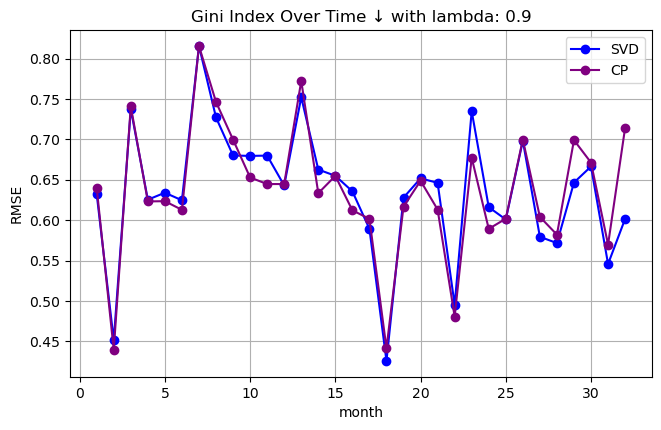

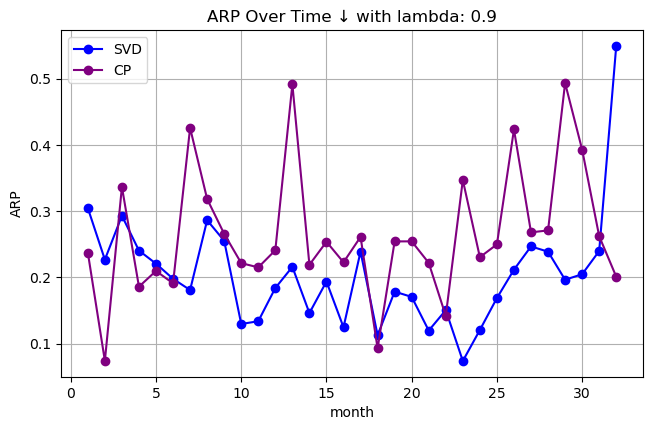

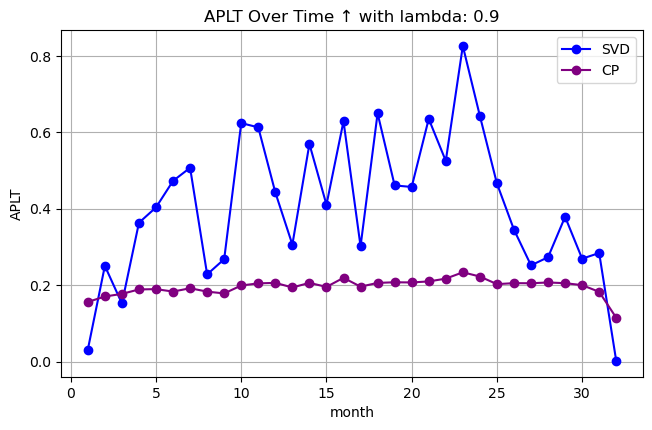

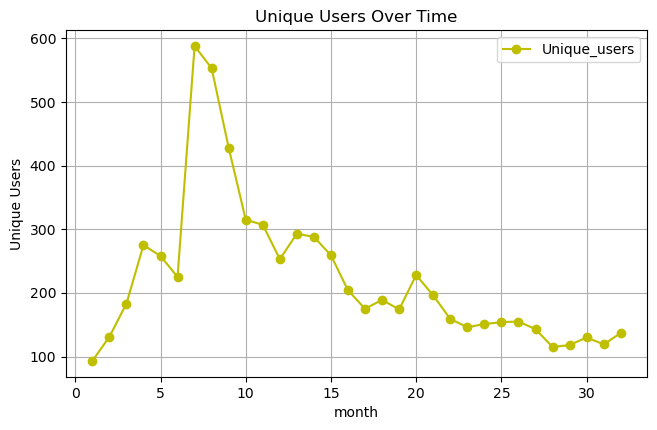

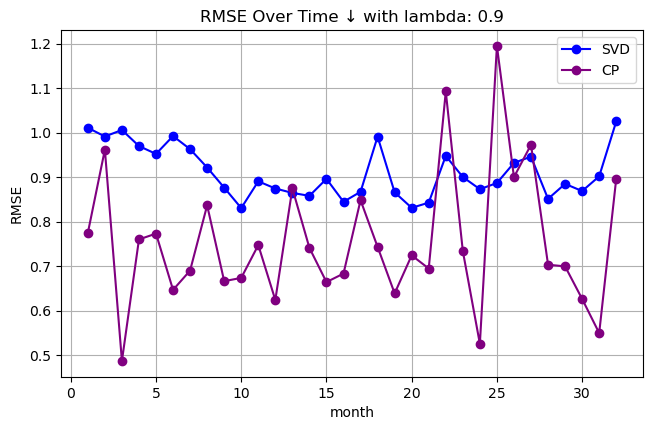

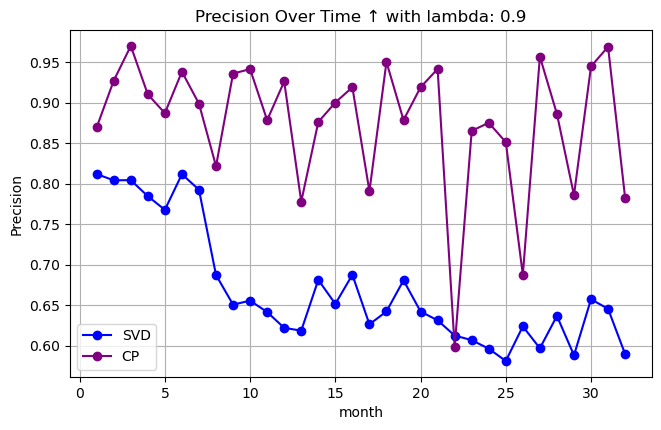

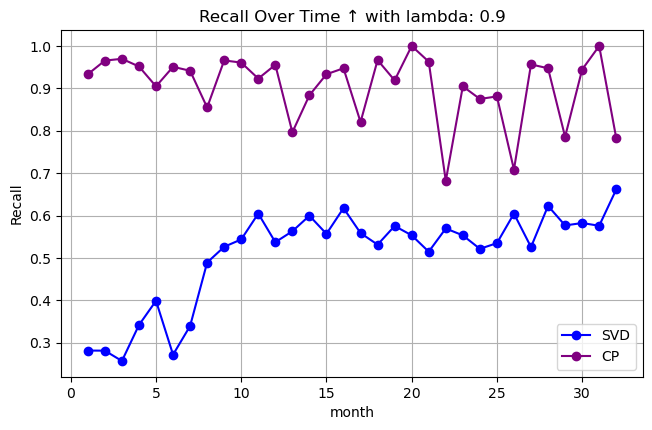

In [36]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, gini_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['gini_index'], marker='o', color='purple', label='CP')
plt.title(f'Gini Index Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig(f'gini{alpha}.png')
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, arp, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['arp'], marker='o', color='purple', label='CP')
plt.title(f'ARP Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.savefig(f'arp{alpha}.png')
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, aplt, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['aplt'], marker='o', color='purple', label='CP')
plt.title(f'APLT Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('APLT')
plt.grid(True)
plt.legend()
plt.savefig(f'aplt{alpha}.png')
plt.show()

#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('month')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()

#RMSE
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, rmse_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['rmse'], marker='o', color='purple', label='CP')
plt.title(f'RMSE Over Time ↓ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig(f'rmse{alpha}.png')
plt.show()

#Precision 
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, precision_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['precision@10'], marker='o', color='purple', label='CP')
plt.title(f'Precision Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.savefig(f'precision{alpha}.png')
plt.show()

#Recall
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, recall_values, marker='o', color='b', label='SVD')
plt.plot(results_df['month'], results_df['recall@10'], marker='o', color='purple', label='CP')
plt.title(f'Recall Over Time ↑ with lambda: {alpha}')
plt.xlabel('month')
plt.ylabel('Recall')
plt.grid(True)
plt.legend()
plt.savefig(f'recall{alpha}.png')
plt.show()

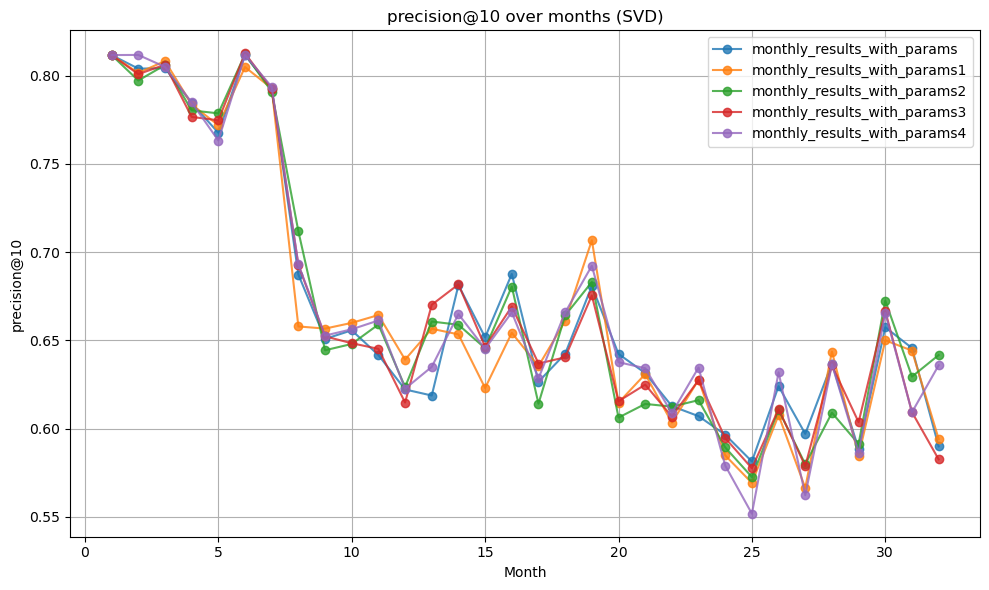

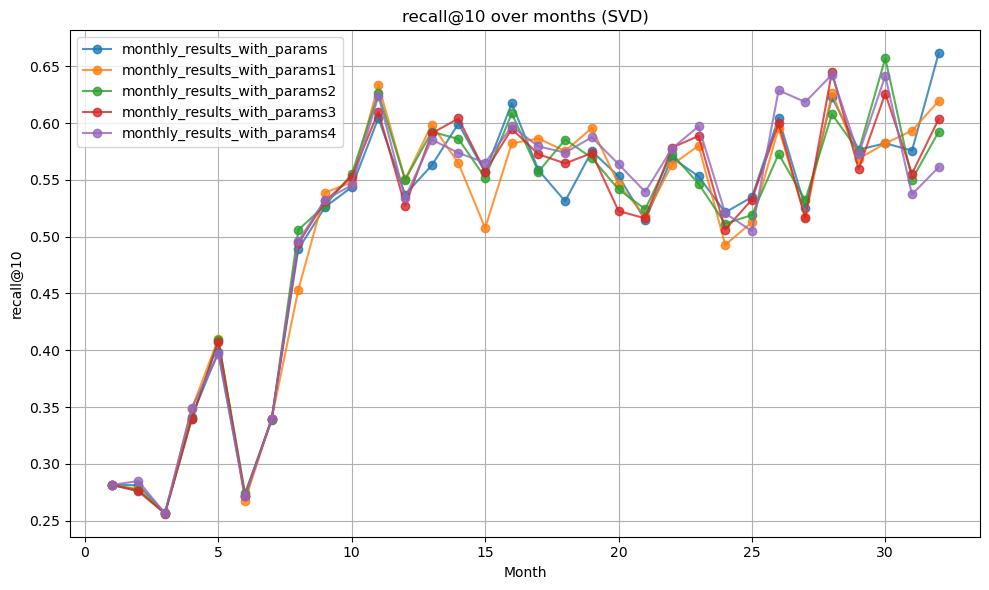

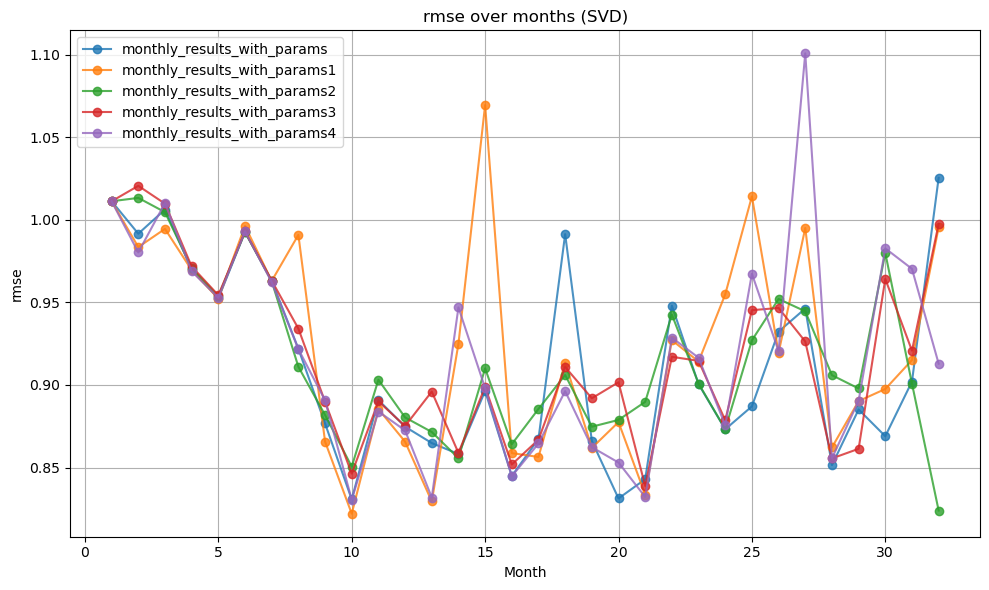

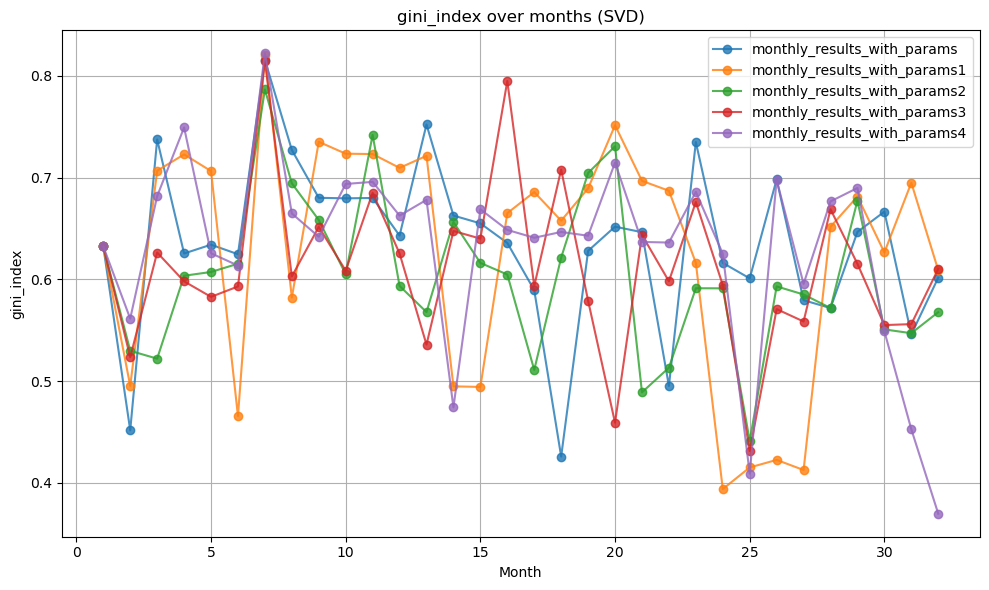

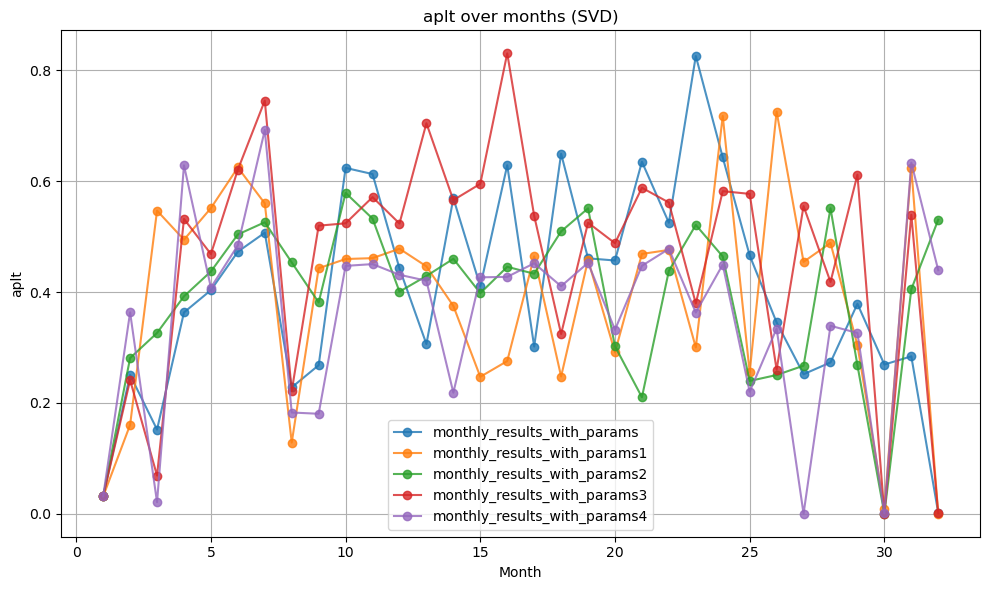

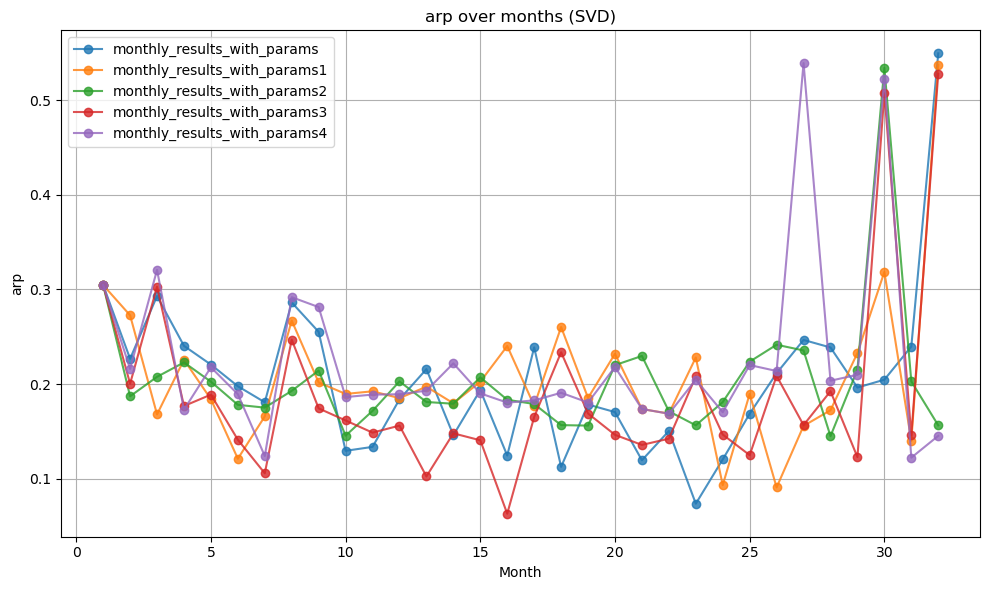

In [37]:
#Results for all runs with different hyperparameters for SVD

files = sorted(glob.glob("monthly_results_with_params*.csv"))
assert files, "No files found matching monthly_results_with_params*.csv"


dfs = []
for fp in files:
    run_id = os.path.splitext(os.path.basename(fp))[0]
    df = pd.read_csv(fp).sort_values("month")
    df["run_id"] = run_id
    dfs.append(df)

all_runs = pd.concat(dfs, ignore_index=True)

# Metrics to plot
metrics = ["precision@10", "recall@10", "rmse", "gini_index", "aplt", "arp"]
available = [m for m in metrics if m in all_runs.columns]


for m in available:
    plt.figure(figsize=(10,6))
    for rid, sub in all_runs.groupby("run_id"):
        plt.plot(sub["month"], sub[m], marker="o", label=rid, alpha=0.8)
    plt.xlabel("Month")
    plt.ylabel(m)
    plt.title(f"{m} over months (SVD)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = f"{m}_overlay_runs.png"
    plt.savefig(out_png, bbox_inches="tight", dpi=150)
    plt.show()


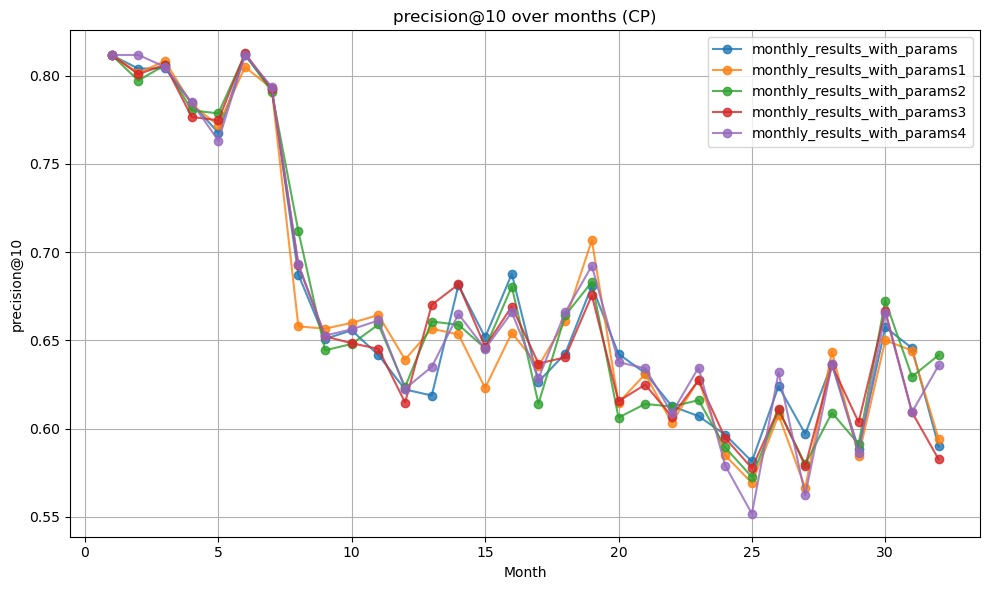

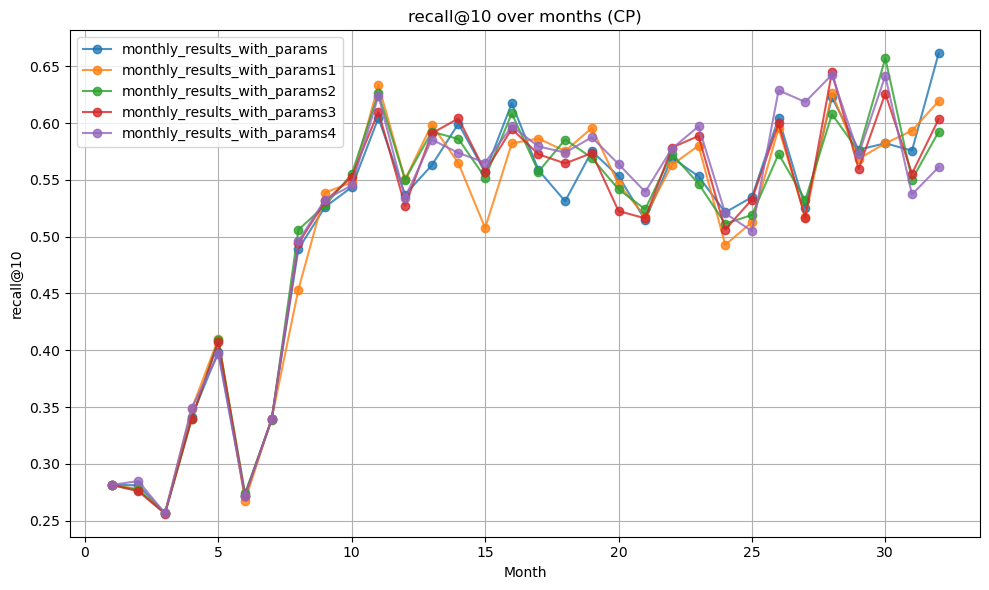

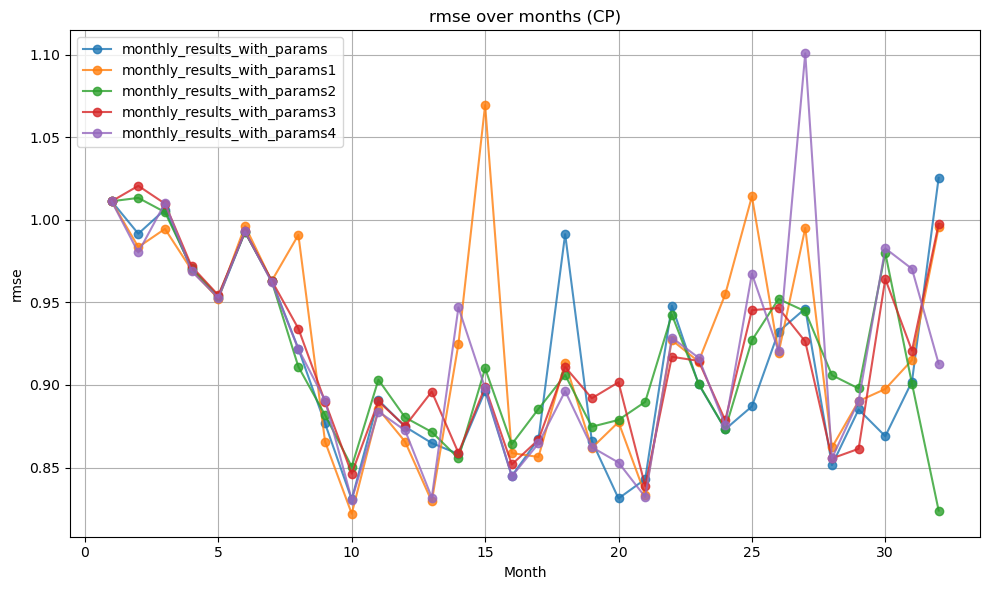

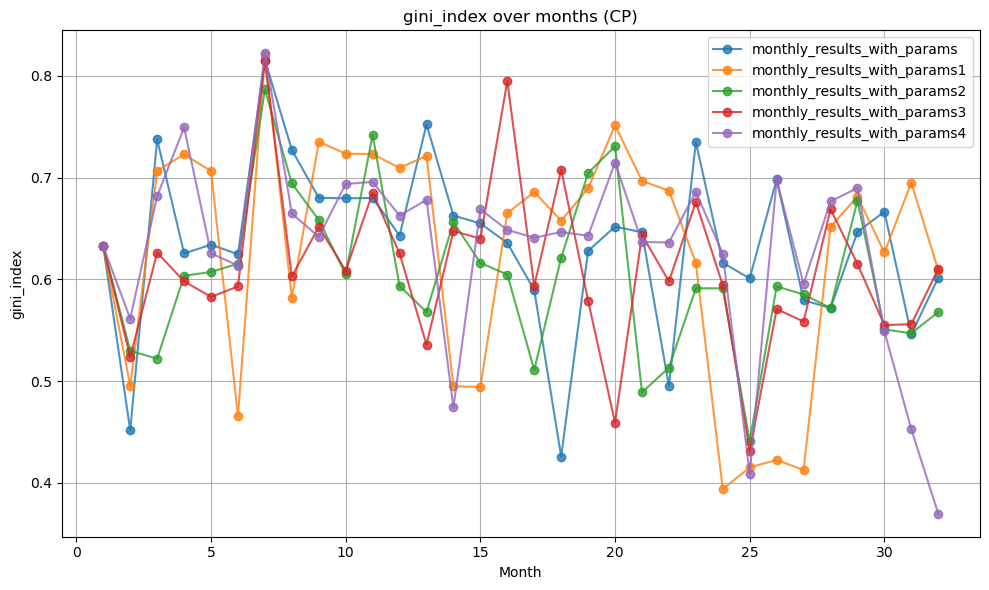

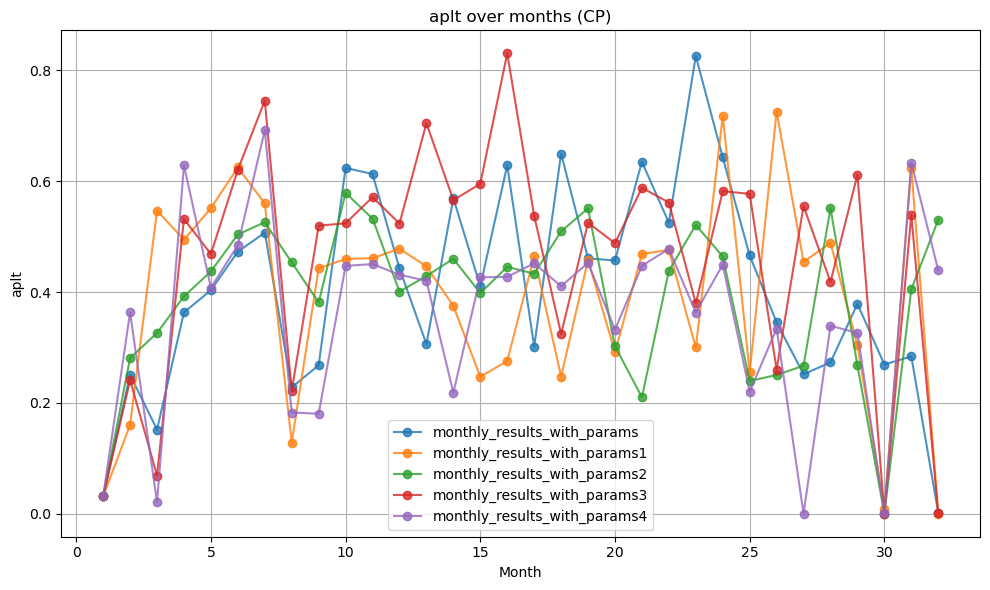

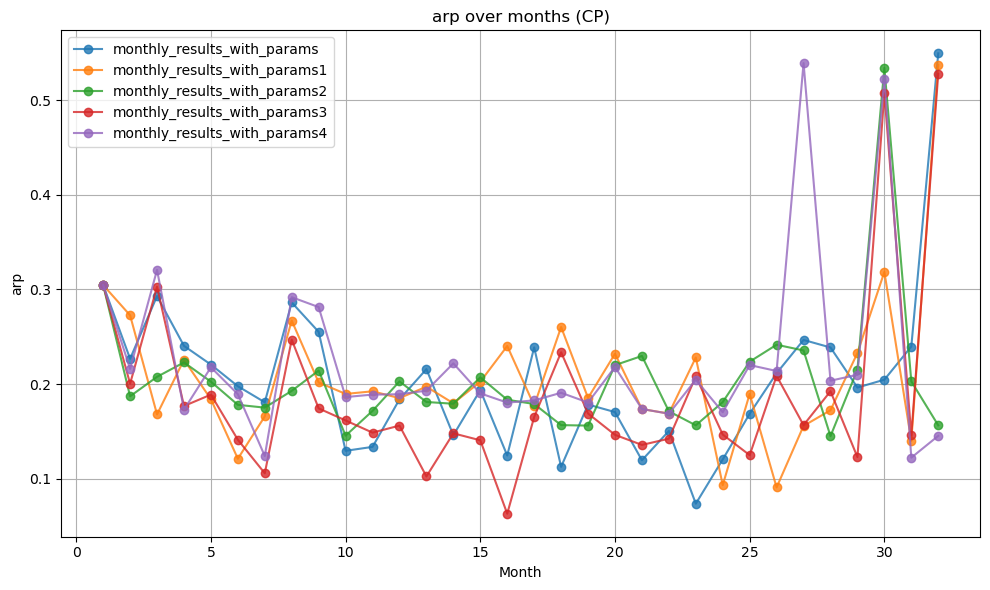

In [38]:
#All results for CP with different hyper parameters for SVD

files = sorted(glob.glob("beyond_accuracy_per_month*.csv"))
assert files, "No files found matching monthly_results_with_params*.csv"

dfs_cp = []
for fp in files:
    run_id = os.path.splitext(os.path.basename(fp))[0]
    df = pd.read_csv(fp).sort_values("month")
    df["run_id"] = run_id
    dfs_cp.append(df)
    
for m in available:
    plt.figure(figsize=(10,6))
    for rid, sub in all_runs.groupby("run_id"):
        plt.plot(sub["month"], sub[m], marker="o", label=rid, alpha=0.8)
    plt.xlabel("Month")
    plt.ylabel(m)
    plt.title(f"{m} over months (CP)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    out_png = f"{m}_overlay_runs.png"
    plt.savefig(out_png, bbox_inches="tight", dpi=150)
    plt.show()

In [39]:
# Mean results of different parameters for SVD

files = sorted(glob.glob("monthly_results_with_params*.csv"))
assert files, "No monthly_results_*.csv files found."

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    df["run_id"] = os.path.splitext(os.path.basename(fp))[0]
    dfs.append(df)

all_main = pd.concat(dfs, ignore_index=True)

# Take mean and std for numeric columns per month
num_cols = all_main.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "month"]

agg_main = (all_main
            .groupby("month", as_index=False)[num_cols]
            .agg(["mean","std"])
            .reset_index())
agg_main.columns = ["month"] + [f"{c}_{s}" for c in num_cols for s in ("mean","std")]
agg_main = agg_main.sort_values("month")

display(agg_main)
#agg_main.to_csv("monthly_results_agg.csv", index=False)
#print("Wrote: monthly_results_agg.csv")


month  rmse_mean  rmse_std  num_active_users_mean  num_active_users_std  \
0       1   1.011240  0.000000                   93.0                   0.0   
1       2   0.997834  0.018089                  131.0                   0.0   
2       3   1.005065  0.006346                  183.0                   0.0   
3       4   0.970210  0.001132                  275.0                   0.0   
4       5   0.953132  0.000878                  258.0                   0.0   
5       6   0.993478  0.001582                  225.0                   0.0   
6       7   0.962868  0.000372                  588.0                   0.0   
7       8   0.935936  0.031785                  553.0                   0.0   
8       9   0.880965  0.010305                  428.0                   0.0   
9      10   0.836032  0.011941                  315.0                   0.0   
10     11   0.890697  0.007583                  307.0                   0.0   
11     12   0.873679  0.005314                  253.0                   0.0   
12     13   0.858757  0.028132                  293.0                   0.0   
13     14   0.888921  0.043630                  288.0                   0.0   
14     15   0.934583  0.075601                  259.0                   0.0   
15     16   0.852877  0.008554                  204.0                   0.0   
16     17   0.868143  0.010651                  175.0                   0.0   
17     18   0.923619  0.038417                  189.0                   0.0   
18     19   0.871406  0.012587                  174.0                   0.0   
19     20   0.868472  0.026972                  228.0                   0.0   
20     21   0.847482  0.024027                  196.0                   0.0   
21     22   0.932707  0.012495                  159.0                   0.0   
22     23   0.909338  0.007929                  146.0                   0.0   
23     24   0.891097  0.035712                  151.0                   0.0   
24     25   0.948176  0.047210                  154.0                   0.0   
25     26   0.934202  0.014837                  155.0                   0.0   
26     27   0.982603  0.070796                  143.0                   0.0   
27     28   0.866144  0.022572                  115.0                   0.0   
28     29   0.885011  0.013977                  118.0                   0.0   
29     30   0.938688  0.052062                  130.0                   0.0   
30     31   0.921813  0.028415                  119.0                   0.0   
31     32   0.951046  0.082542                  137.0                   0.0   

    precision@10_mean  precision@10_std  recall@10_mean  recall@10_std  \
0            0.811744          0.000000        0.281411       0.000000   
1            0.803146          0.005419        0.279324       0.003656   
2            0.806017          0.001548        0.256509       0.000292   
3            0.782030          0.003478        0.343525       0.004716   
4            0.771289          0.006005        0.404377       0.006178   
5            0.810680          0.003217        0.271445       0.002394   
6            0.792527          0.000960        0.339312       0.000431   
7            0.688563          0.019499        0.487730       0.020175   
8            0.651381          0.004464        0.531276       0.004982   
9            0.653658          0.005254        0.548878       0.004928   
10           0.654308          0.010177        0.619712       0.012011   
11           0.624441          0.008908        0.539841       0.010188   
12           0.648242          0.020926        0.586122       0.013827   
13           0.668044          0.012968        0.585630       0.016692   
14           0.642366          0.011146        0.547808       0.022966   
15           0.671511          0.012995        0.600051       0.013478   
16           0.628301          0.009068        0.570862       0.012801   
17           0.654734          0.012329        0.566162       0.

In [40]:
# Mean results of CP with different SVD parameters 

files = sorted(glob.glob("beyond_accuracy_per_month*.csv"))
assert files, "No beyond_accuracy_per_month_*.csv files found."

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    df["run_id"] = os.path.splitext(os.path.basename(fp))[0]
    dfs.append(df)

all_cp = pd.concat(dfs, ignore_index=True)

num_cols = all_cp.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != "month"]

agg_cp = (all_cp
          .groupby("month", as_index=False)[num_cols]
          .agg(["mean","std"])
          .reset_index())
agg_cp.columns = ["month"] + [f"{c}_{s}" for c in num_cols for s in ("mean","std")]
agg_cp = agg_cp.sort_values("month")

display(agg_cp)
#agg_cp.to_csv("beyond_accuracy_per_month_agg.csv", index=False)


month  gini_index_mean  gini_index_std  arp_mean   arp_std  aplt_mean  \
0       1         0.619893        0.011148  0.235368  0.009011   0.155914   
1       2         0.506549        0.040433  0.103757  0.059809   0.173130   
2       3         0.657084        0.089865  0.294775  0.101214   0.181421   
3       4         0.651562        0.065107  0.236434  0.080399   0.195345   
4       5         0.623668        0.028962  0.226477  0.069255   0.194884   
5       6         0.574139        0.066707  0.161122  0.053196   0.191733   
6       7         0.800256        0.012000  0.404442  0.046872   0.199150   
7       8         0.660973        0.064959  0.201587  0.085892   0.186908   
8       9         0.677254        0.041623  0.248416  0.046320   0.191916   
9      10         0.648965        0.048617  0.243835  0.052334   0.204635   
10     11         0.680815        0.033924  0.307406  0.105765   0.210358   
11     12         0.637437        0.034008  0.249571  0.035834   0.211383   
12     13         0.651203        0.094892  0.275074  0.139786   0.207304   
13     14         0.582511        0.079372  0.178458  0.078436   0.206875   
14     15         0.609033        0.061824  0.208970  0.081581   0.201004   
15     16         0.638986        0.040863  0.281349  0.056084   0.222255   
16     17         0.591417        0.059393  0.253138  0.053703   0.212114   
17     18         0.612113        0.104260  0.273745  0.120617   0.209312   
18     19         0.633877        0.053789  0.306340  0.097900   0.220920   
19     20         0.657367        0.108917  0.337554  0.161369   0.206754   
20     21         0.603446        0.064561  0.241636  0.062141   0.213367   
21     22         0.565238        0.072405  0.230555  0.073027   0.226667   
22     23         0.645797        0.045310  0.342632  0.075511   0.220411   
23     24         0.548471        0.075523  0.211368  0.070766   0.232583   
24     25         0.463781        0.078098  0.135278  0.072392   0.205974   
25     26         0.597026        0.104439  0.282794  0.129423   0.215097   
26     27         0.564221        0.097899  0.203544  0.068341   0.203357   
27     28         0.614116        0.052144  0.345020  0.096014   0.221391   
28     29         0.654795        0.051218  0.409466  0.090170   0.212034   
29     30         0.650167        0.013637  0.248359  0.093534   0.150154   
30     31         0.551095        0.080744  0.255845  0.090604   0.198151   
31     32         0.596507        0.126807  0.183335  0.061455   0.151387   

    aplt_std  rmse_mean  rmse_std  precision@10_mean  precision@10_std  \
0   0.000000   1.025801  0.140369           0.848232          0.011858   
1   0.004398   0.942991  0.272399           0.885736          0.081390   
2   0.009504   0.618547  0.163618           0.939836          0.027016   
3   0.005177   0.769004  0.091632           0.880139          0.029590   
4   0.003142   0.658856  0.074771           0.926097          0.023100   
5   0.005901   0.770492  0.160641           0.907630          0.027258   
6   0.005042   0.688350  0.005454           0.919423          0.014210   
7   0.007493   0.851909  0.163806           0.851437          0.047368   
8   0.010817   0.717638  0.069485           0.910353          0.031228   
9   0.003827   0.652812  0.063739           0.937646          0.018379   
10  0.003932   0.709618  0.031392           0.883950          0.020009   
11  0.004196   0.657149  0.037524           0.916683          0.021033   
12  0.010784   0.862479  0.102629           0.844438          0.051270   
13  0.006169   0.850653  0.180013           0.864438          0.038807   
14  0.007797   0.813059  0.214551           0.888028          0.046844   
15  0.010251   0.669678  0.111449           0.941631          0.018994   
16  0.010336   0.912201  0.059858           0.768119          0.043492   
17  0.005069   0.662533  0.137633           0.923072          0.037383   
18  0.007918   0.668615  0.034526           0.911817    

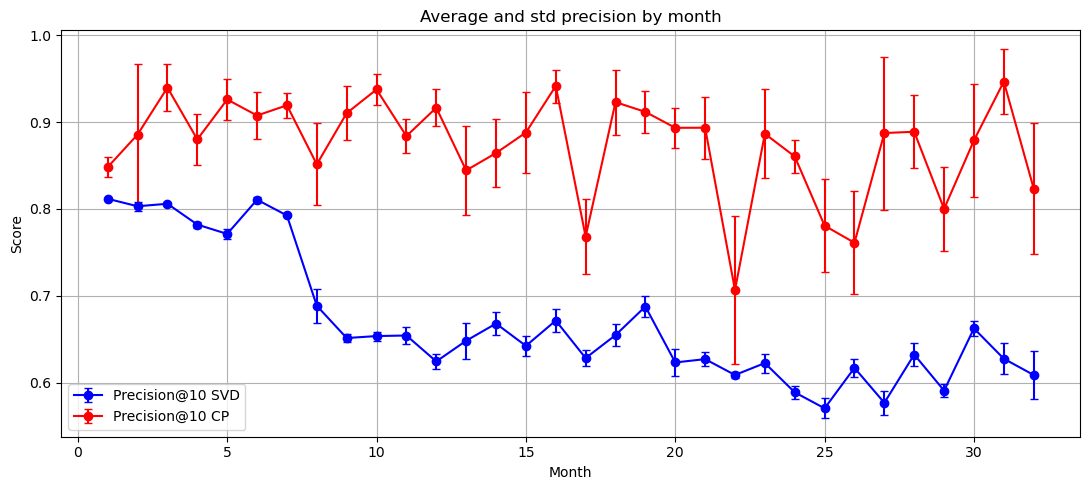

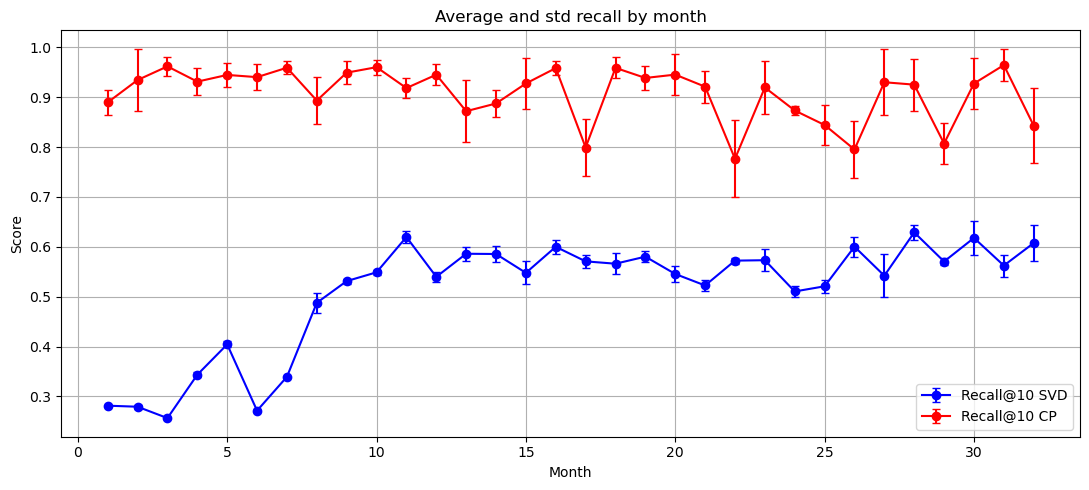

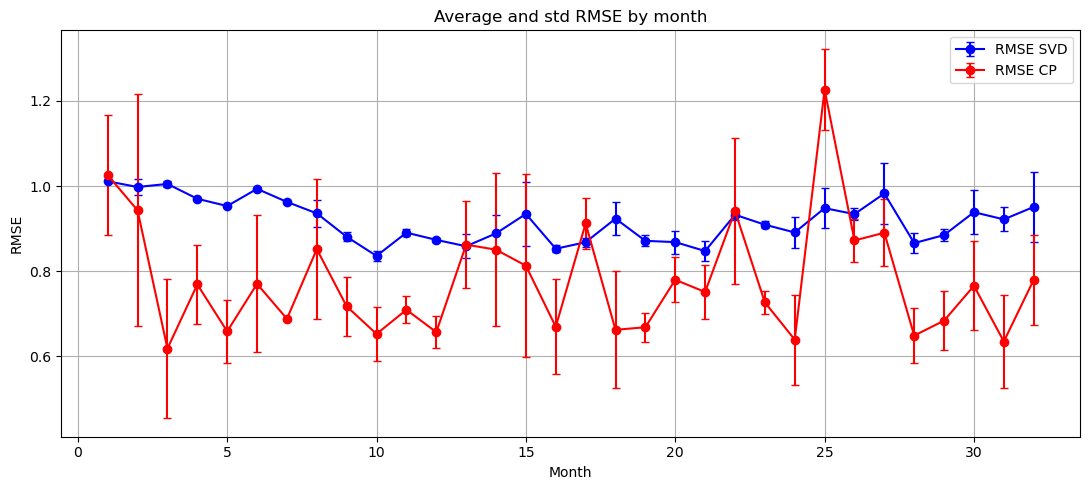

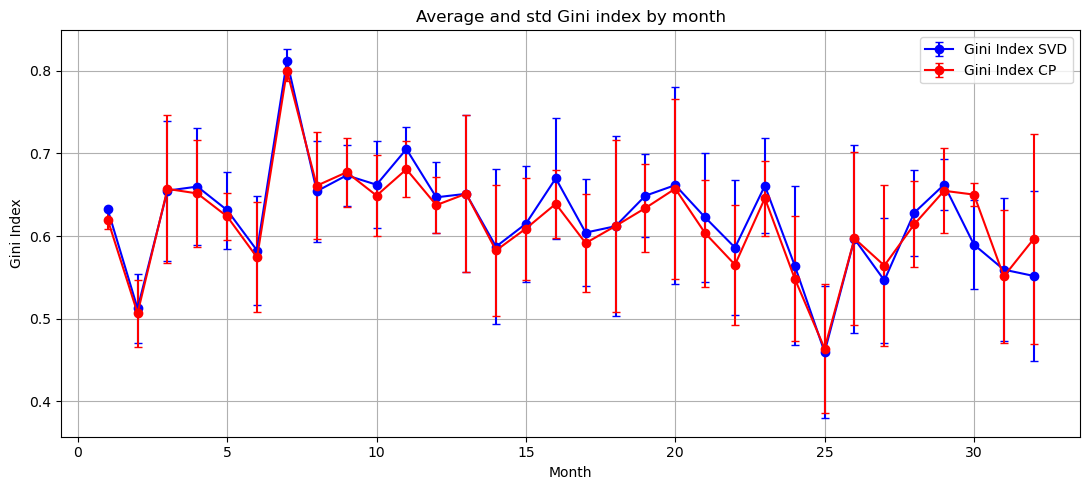

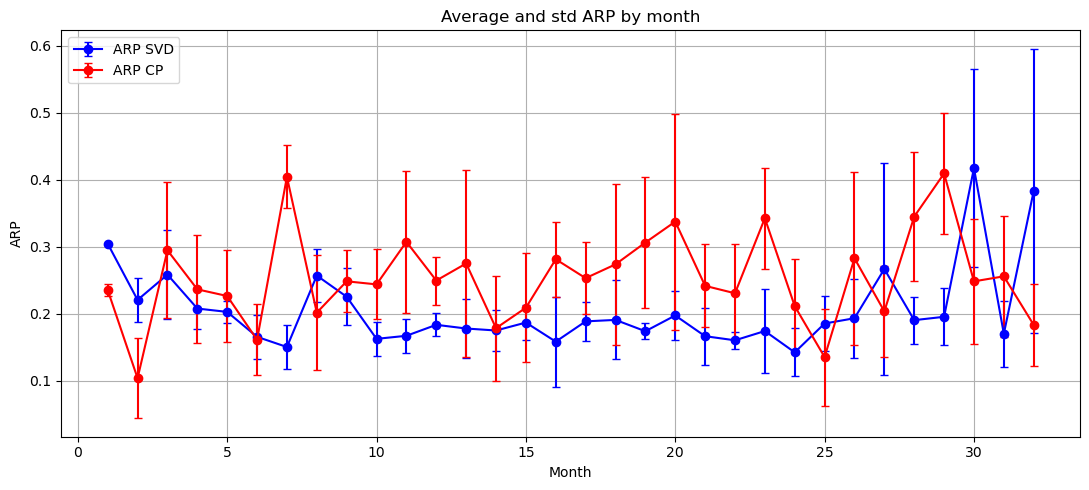

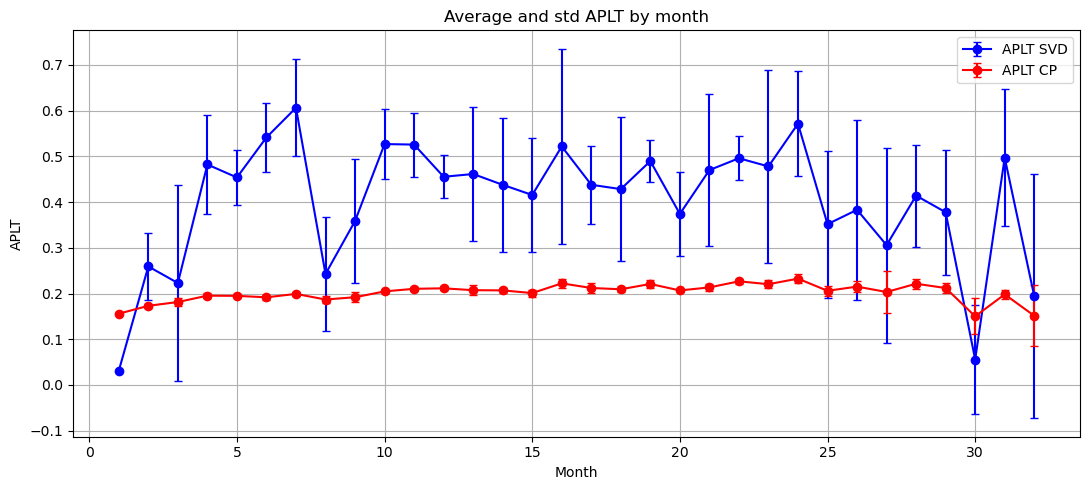

In [41]:
def plot_with_errorbars(df, metric_base, *,
                        x_col="month",
                        color=None,
                        label=None):
    mean_col = f"{metric_base}_mean"
    std_col  = f"{metric_base}_std"
    if mean_col not in df.columns or std_col not in df.columns:
        print(f"Skipping '{metric_base}': columns '{mean_col}' / '{std_col}' not found.")
        return
    df_plot = df.sort_values(x_col)
    x = df_plot[x_col].values
    y = df_plot[mean_col].values
    yerr = df_plot[std_col].values
    
    plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=3, color=color, label=label)
    
plt.figure(figsize=(11, 5))

plot_with_errorbars(agg_main, "precision@10", color='blue', label='Precision@10 SVD')
plot_with_errorbars(agg_cp, "precision@10", color='red', label='Precision@10 CP')

#Precision
plt.xlabel("Month")
plt.ylabel("Score")
plt.title("Average and std precision by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Recall@10
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "recall@10", color='blue', label='Recall@10 SVD')
plot_with_errorbars(agg_cp, "recall@10", color='red', label='Recall@10 CP')
plt.xlabel("Month")
plt.ylabel("Score")
plt.title("Average and std recall by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSE
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "rmse", color='blue', label='RMSE SVD')
plot_with_errorbars(agg_cp, "rmse", color='red', label='RMSE CP')
plt.xlabel("Month")
plt.ylabel("RMSE")
plt.title("Average and std RMSE by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gini Index
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "gini_index", color='blue', label='Gini Index SVD')
plot_with_errorbars(agg_cp, "gini_index", color='red', label='Gini Index CP')
plt.xlabel("Month")
plt.ylabel("Gini Index")
plt.title("Average and std Gini index by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARP
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "arp", color='blue', label='ARP SVD')
plot_with_errorbars(agg_cp, "arp", color='red', label='ARP CP')
plt.xlabel("Month")
plt.ylabel("ARP")
plt.title("Average and std ARP by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# APLT
plt.figure(figsize=(11, 5))
plot_with_errorbars(agg_main, "aplt", color='blue', label='APLT SVD')
plot_with_errorbars(agg_cp, "aplt", color='red', label='APLT CP')
plt.xlabel("Month")
plt.ylabel("APLT")
plt.title("Average and std APLT by month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


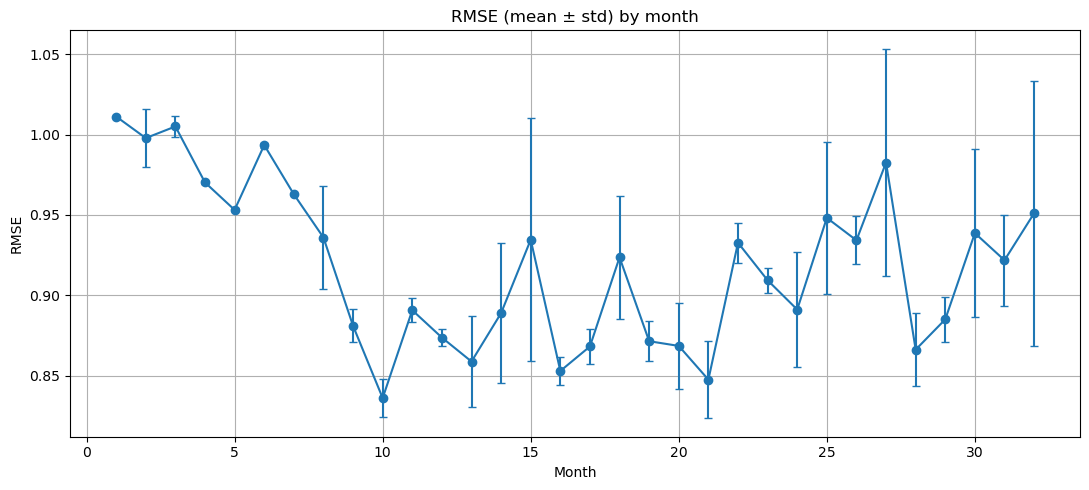

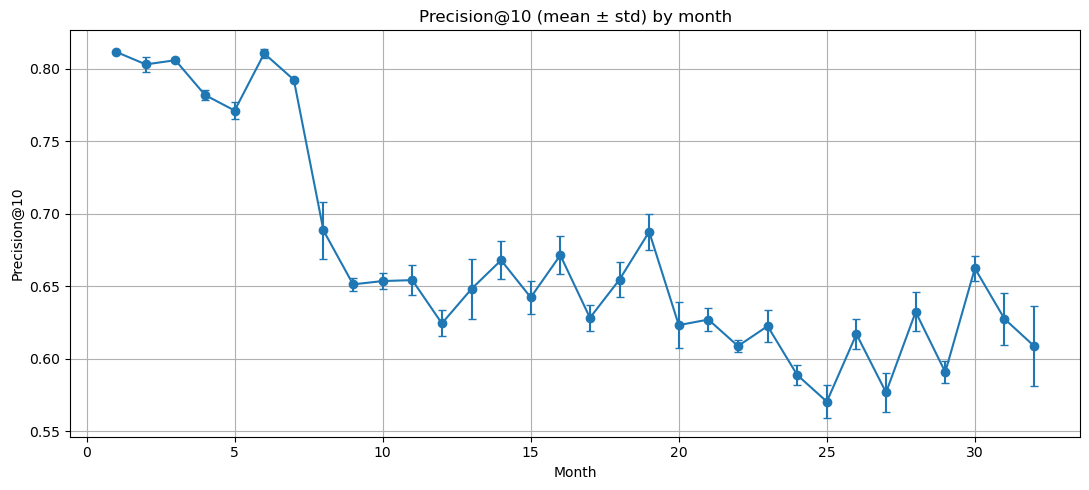

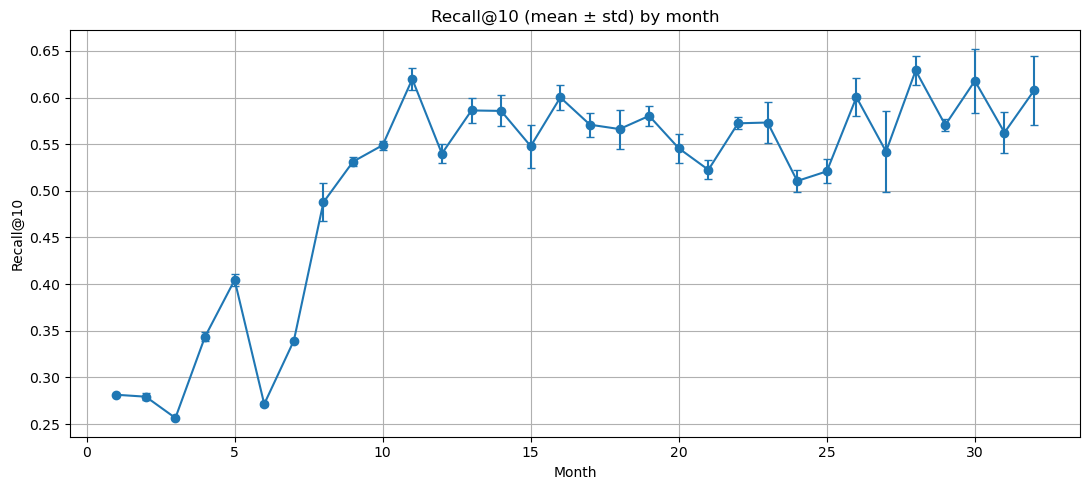

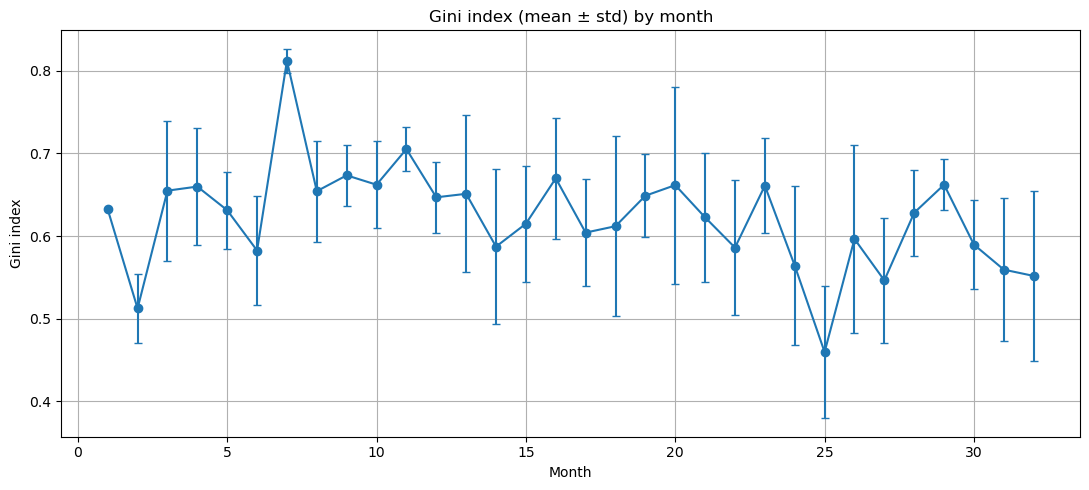

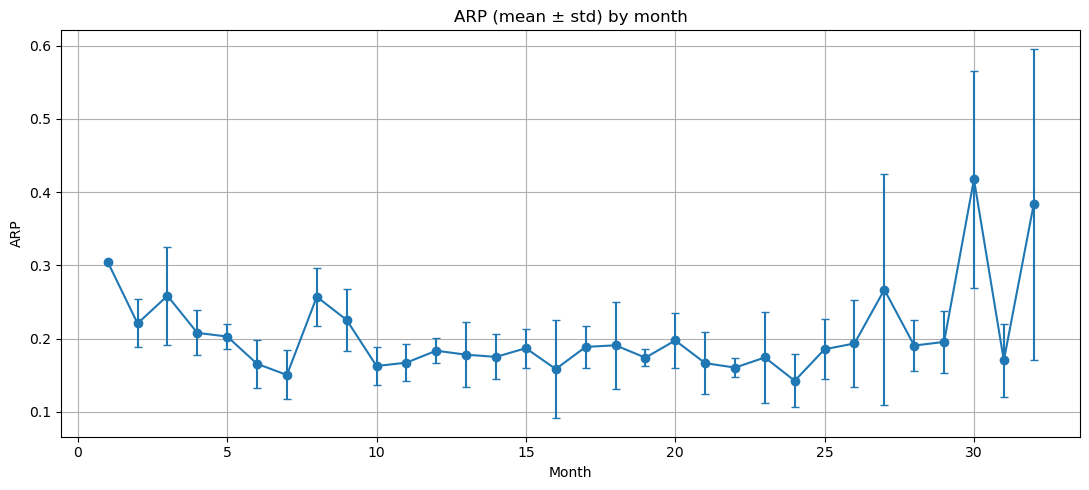

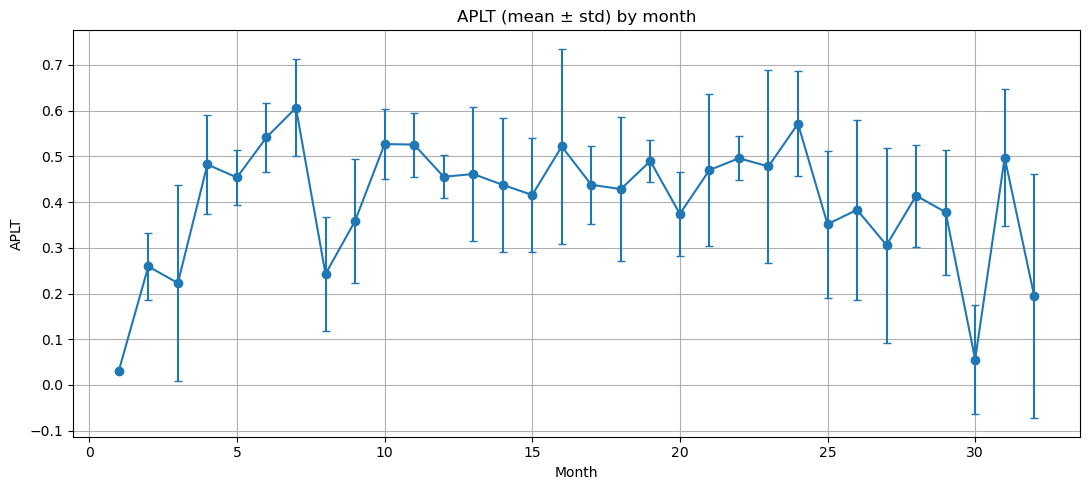

In [42]:
def plot_with_errorbars2(df, metric_base, *,
                        x_col="month",
                        title=None,
                        x_label="Month",
                        y_label=None,
                        save_as=None):
    mean_col = f"{metric_base}_mean"
    std_col  = f"{metric_base}_std"
    if mean_col not in df.columns or std_col not in df.columns:
        print(f"Skipping '{metric_base}': columns '{mean_col}' / '{std_col}' not found.")
        return

    df_plot = df.sort_values(x_col)
    x = df_plot[x_col].values
    y = df_plot[mean_col].values
    yerr = df_plot[std_col].values

    plt.figure(figsize=(11, 5))
    plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=3)
    plt.xlabel(x_label)
    plt.ylabel(y_label if y_label else metric_base)
    plt.title(title if title else f"{metric_base} (mean ± std) by month")
    plt.grid(True)
    plt.tight_layout()
    if save_as:
        plt.savefig(save_as, bbox_inches='tight', dpi=150)
    plt.show()

plot_with_errorbars2(
    agg_main, "rmse",
    title="RMSE (mean ± std) by month",
    y_label="RMSE"
)

plot_with_errorbars2(
    agg_main, "precision@10",
    title="Precision@10 (mean ± std) by month",
    y_label="Precision@10"
)

plot_with_errorbars2(
    agg_main, "recall@10",
    title="Recall@10 (mean ± std) by month",
    y_label="Recall@10"
)


plot_with_errorbars2(
    agg_main, "gini_index",
    title="Gini index (mean ± std) by month",
    y_label="Gini index"
)



plot_with_errorbars2(
    agg_main, "arp",
    title="ARP (mean ± std) by month",
    y_label="ARP"
)


plot_with_errorbars2(
    agg_main, "aplt",
    title="APLT (mean ± std) by month",
    y_label="APLT"
)


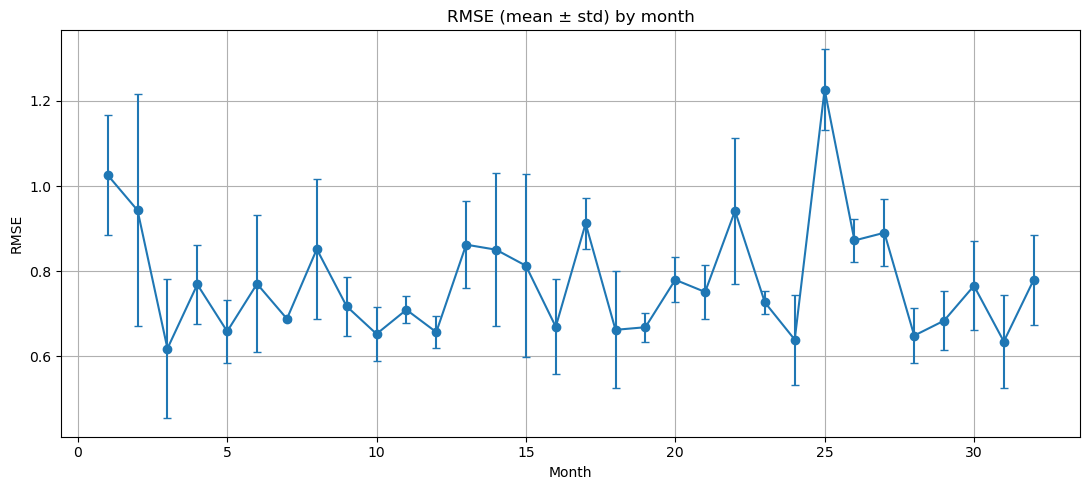

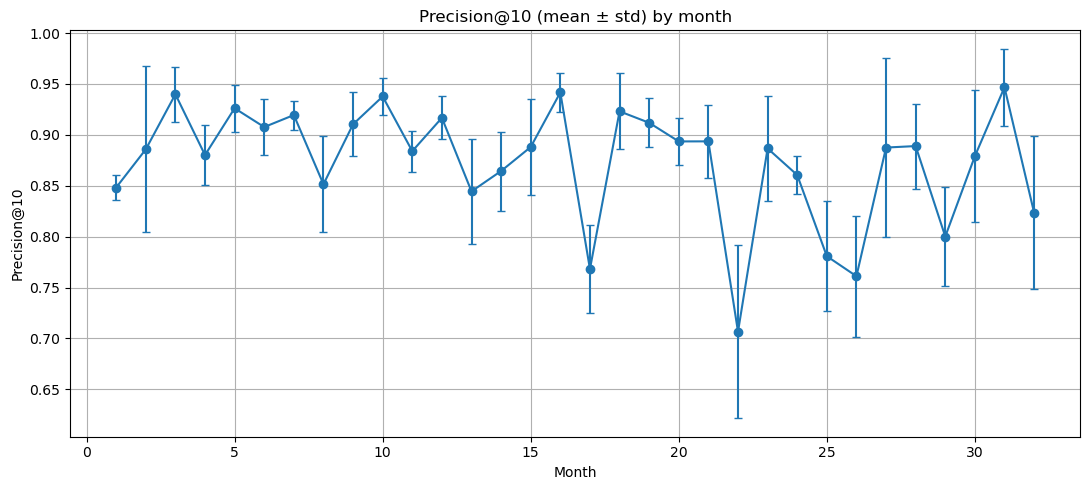

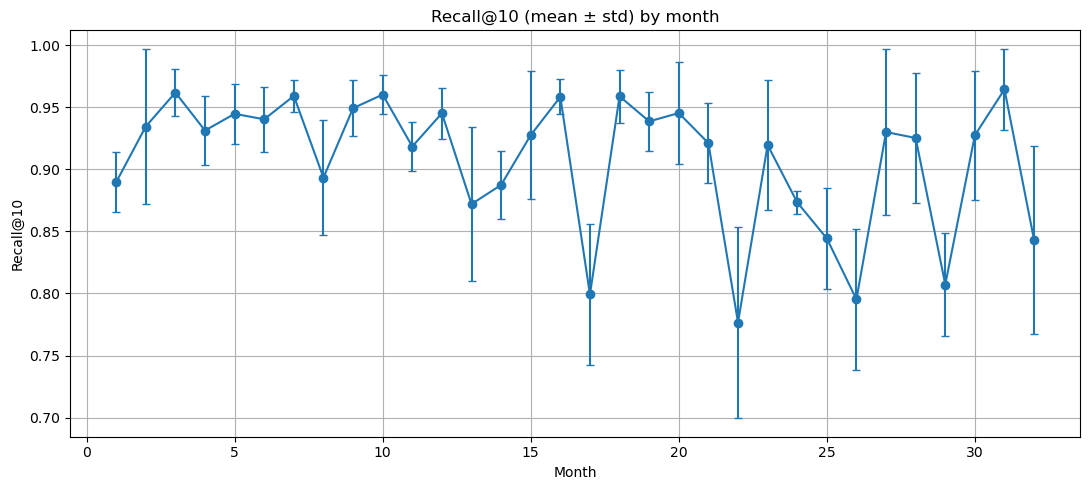

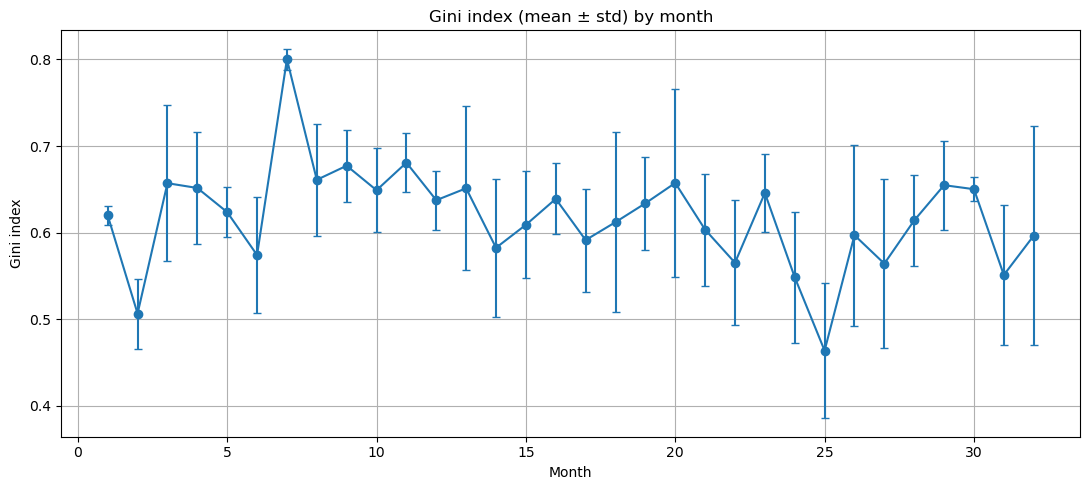

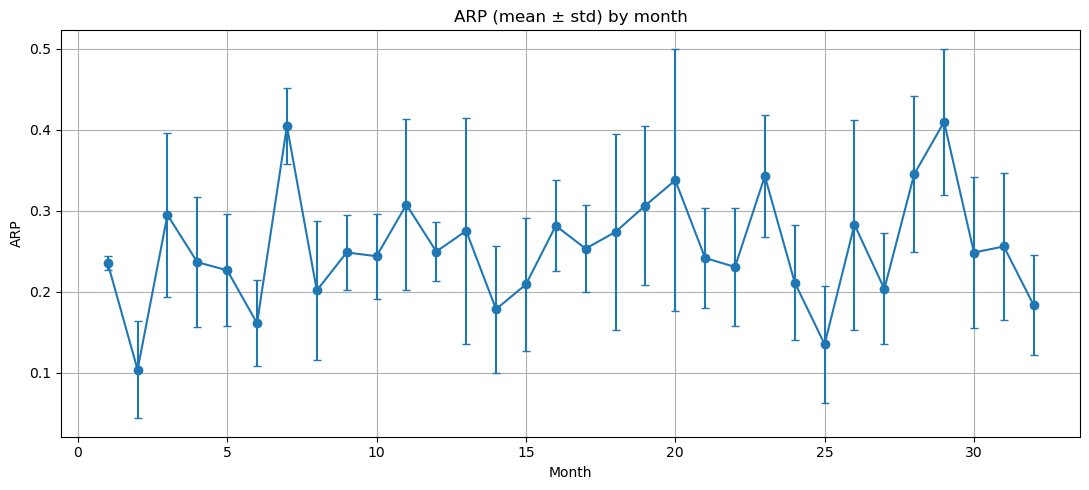

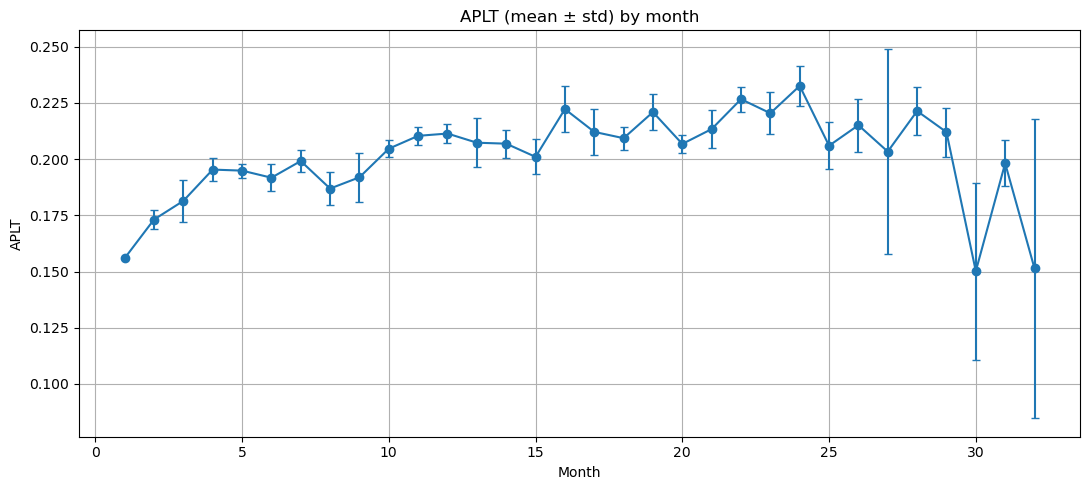

In [43]:
plot_with_errorbars2(
    agg_cp, "rmse",
    title="RMSE (mean ± std) by month",
    y_label="RMSE"
)

plot_with_errorbars2(
    agg_cp, "precision@10",
    title="Precision@10 (mean ± std) by month",
    y_label="Precision@10"
)

plot_with_errorbars2(
    agg_cp, "recall@10",
    title="Recall@10 (mean ± std) by month",
    y_label="Recall@10"
)

plot_with_errorbars2(
    agg_cp, "gini_index",
    title="Gini index (mean ± std) by month",
    y_label="Gini index"
)

plot_with_errorbars2(
    agg_cp, "arp",
    title="ARP (mean ± std) by month",
    y_label="ARP"
)

plot_with_errorbars2(
    agg_cp, "aplt",
    title="APLT (mean ± std) by month",
    y_label="APLT"
)

In [44]:
# Monthy index
df = ratings.copy()
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp')
df['ym'] = df['timestamp'].dt.to_period('M')
months = np.array(sorted(df['ym'].unique(), key=lambda x: (x.year, x.month)))

# Monthly users
users_per_month = {
    m: set(df.loc[df['ym'] == m, 'userId'].unique())
    for m in months
}


users_ever_before = []          # users appearing before month i
prefix_seen = set()
for m in months:
    users_ever_before.append(prefix_seen.copy())
    prefix_seen |= users_per_month[m]

users_ever_after = {}           # users appearing after month i
suffix_seen = set()
for m in reversed(months):
    users_ever_after[m] = suffix_seen.copy()
    suffix_seen |= users_per_month[m]

rows = []
for i, m in enumerate(months):
    users_now  = users_per_month[m]
    users_prev = users_per_month[months[i-1]] if i > 0 else set()
    users_next = users_per_month[months[i+1]] if i < len(months)-1 else set()

    active = len(users_now)

    new_users = users_now - users_prev

    # first time observed
    first_time_new = users_now - users_ever_before[i]

    returning_after_pause = (users_now & users_ever_before[i]) - users_prev

    # Disappearing next month
    churn_next = users_now - users_next if i < len(months)-1 else set()

    # Permanently disappeared
    permanent_churn = users_now - users_ever_after[m]

    retention_next = (len(users_now & users_next) / active) if (active > 0 and i < len(months)-1) else float('nan')

    rows.append({
        #'month': str(m),
        'month_idx': i+1,
        'active_users': active,
        'new_users': len(new_users),
        'first_time_new': len(first_time_new),
        'returning_after_pause': len(returning_after_pause),
        'churned_next_month': len(churn_next) if i < len(months)-1 else float('nan'),
        'permanent_churn': len(permanent_churn),
        #'retention_rate_next_month': round(retention_next, 4) if retention_next == retention_next else float('nan'),  # NaN-safe
        #'net_user_change_vs_next': (len(users_next) - active) if i < len(months)-1 else float('nan'),
    })

user_flow = pd.DataFrame(rows)
display(user_flow)

user_flow['month_idx'] = range(1, len(user_flow)+1)


month_idx  active_users  new_users  first_time_new  returning_after_pause  \
0           1            86         86              86                      0   
1           2           486        466             466                      0   
2           3           508        410             407                      3   
3           4           778        655             634                     21   
4           5          1310       1140            1101                     39   
5           6           576        364             317                     47   
6           7           500        336             248                     88   
7           8          2357       2190            2106                     84   
8           9          1241        766             669                     97   
9          10           543        183               0                    183   
10         11           395        151               1                    150   
11         12           323        147               0                    147   
12         13           293        136               0                    136   
13         14           274        138               1                    137   
14         15           271        140               1                    139   
15         16           290        145               0                    145   
16         17           246        117               0                    117   
17         18           191         87               0                     87   
18         19           180        105               0                    105   
19         20           180        114               1                    113   
20         21           186        107               0                    107   
21         22           220        135               0                    135   
22         23           179         86               0                     86   
23         24           168         86               1                     85   
24         25           151         80               0                     80   
25         26           154         84               0                     84   
26         27           140         69               0                     69   
27         28           156         85               0                     85   
28         29           139         62               0                     62   
29         30           112         48               0                     48   
30         31           121         70               0                     70   
31         32           119         69               1                     68   
32         33           129         81               0                     81   
33         34           134         70               0                     70   
34         35            99         44               0                     44   

    churned_next_month  permanent_churn  
0                 66.0               56  
1                388.0              339  
2                385.0              309  
3                608.0              498  
4               1098.0              926  
5                412.0              284  
6                333.0              216  
7               1882.0             1589  
8                881.0              646  
9                299.0              124  
10               219.0               80  
11               166.0               48  
12               157.0               40  
13               143.0               43  
14               126.0               43  
15               161.0               65  
16               142.0               39  
17               116.0               21  
18               114.0               29  
19               101.0               34  
20               101.0               24  
21               127.0               53  
22                97.0               36  
23                97.0               33  
24                81.0               

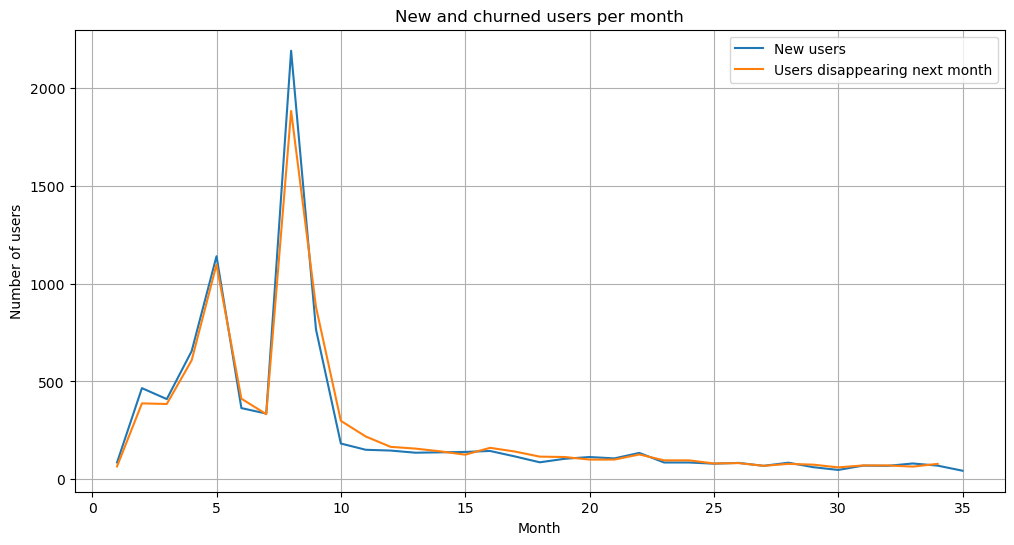

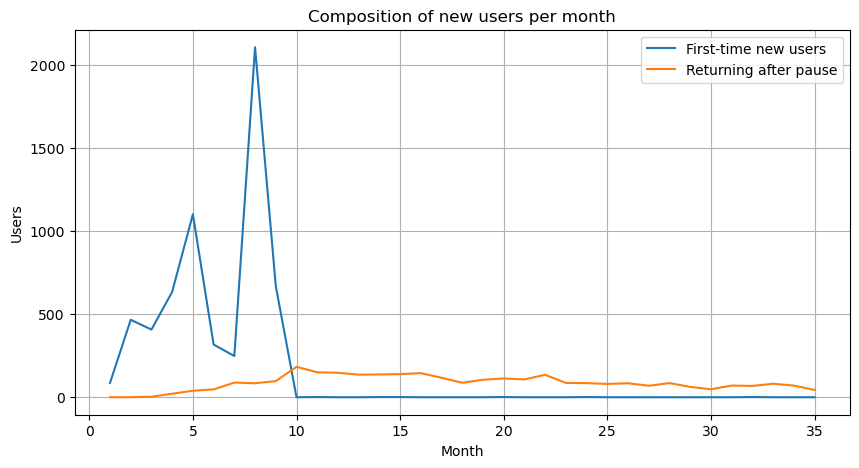

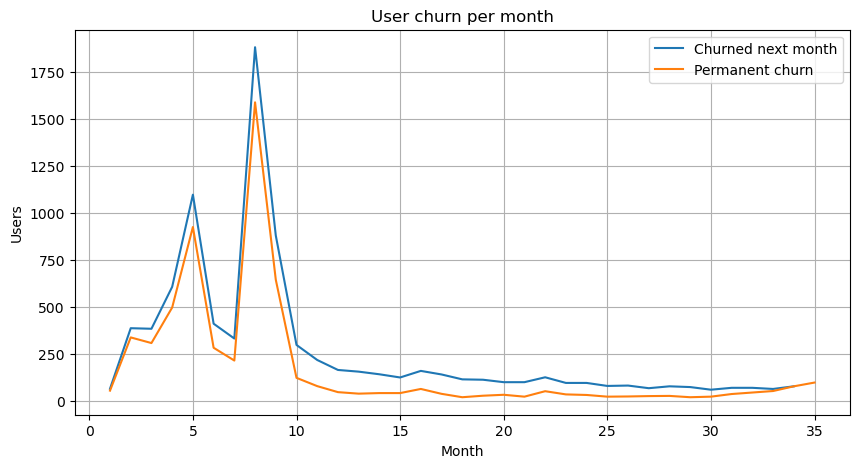

In [45]:

# New vs churned (disappearing) users
plt.figure(figsize=(12,6))
plt.plot(user_flow['month_idx'], user_flow['new_users'], label="New users")
plt.plot(user_flow['month_idx'], user_flow['churned_next_month'], label="Users disappearing next month")
plt.xlabel("Month")
plt.ylabel("Number of users")
plt.title("New and churned users per month")
plt.legend()
plt.grid(True)
plt.savefig(f'users_over_time.png')
plt.show()

# First time users vs users coming back after a pause
plt.figure(figsize=(10,5))
plt.plot(user_flow['month_idx'], user_flow['first_time_new'], label="First-time new users")
plt.plot(user_flow['month_idx'], user_flow['returning_after_pause'], label="Returning after pause")
plt.title("Composition of new users per month")
plt.xlabel("Month")
plt.ylabel("Users")
plt.legend()
plt.grid(True)
plt.show()

# Permanent vs temporary churned (disappearing) users
plt.figure(figsize=(10,5))
plt.plot(user_flow['month_idx'], user_flow['churned_next_month'], label="Churned next month")
plt.plot(user_flow['month_idx'], user_flow['permanent_churn'], label="Permanent churn")
plt.title("User churn per month")
plt.xlabel("Month")
plt.ylabel("Users")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Number of ratings per user per month
user_month_counts = (
    ratings.groupby(['month_idx', 'userId'])
           .size()
           .reset_index(name='n_ratings')
)

# Average per month
avg_per_month = (
    user_month_counts.groupby('month_idx')['n_ratings']
                     .mean()
                     .reset_index(name='avg_ratings_per_user')
)

display(avg_per_month)

month_idx  avg_ratings_per_user
0           1            132.511628
1           2            138.759259
2           3            107.255906
3           4            116.110540
4           5            139.014504
5           6             91.008681
6           7             84.588000
7           8            123.374204
8           9             91.448026
9          10             33.156538
10         11             20.597468
11         12             18.832817
12         13             17.648464
13         14             18.025547
14         15             18.380074
15         16             16.431034
16         17             18.105691
17         18             16.109948
18         19             12.177778
19         20             15.333333
20         21             18.795699
21         22             14.618182
22         23             13.944134
23         24             14.607143
24         25             18.807947
25         26             12.350649
26         27             11.735714
27         28             12.211538
28         29             15.187050
29         30             11.544643
30         31              8.380165
31         32             16.033613
32         33              9.798450
33         34             13.820896
34         35             15.111111

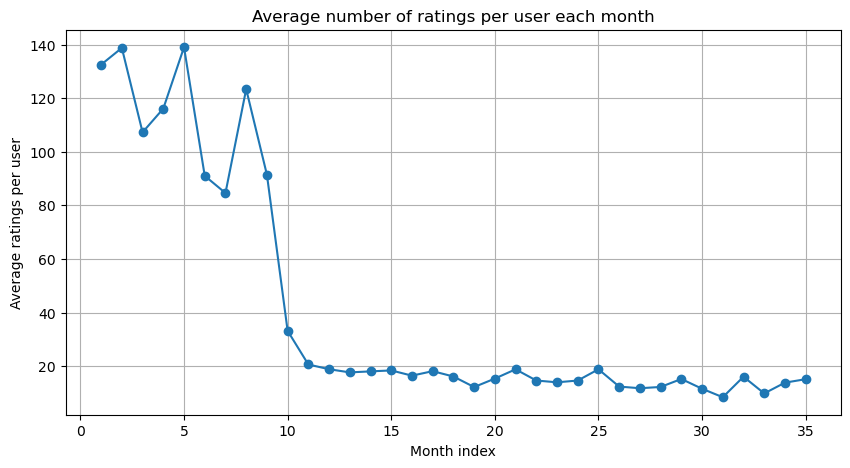

In [47]:
plt.figure(figsize=(10,5))
plt.plot(avg_per_month['month_idx'], avg_per_month['avg_ratings_per_user'], marker='o')
plt.xlabel("Month index")
plt.ylabel("Average ratings per user")
plt.title("Average number of ratings per user each month")
plt.grid(True)
plt.show()

In [48]:
# Number of items with active, new and churned ratings

movies_per_month = {m: set(df.loc[df['ym'] == m, 'movieId'].unique()) for m in months}
movie_counts_month = (df
                      .groupby(['ym','movieId'])
                      .size()
                      .rename('n_ratings')
                      .reset_index())


rows = []
for i, m in enumerate(months):
    items_now = movies_per_month[m]
    items_prev = movies_per_month[months[i-1]] if i > 0 else set()
    items_next = movies_per_month[months[i+1]] if i < len(months)-1 else set()

    active = len(items_now)
    new_items = len(items_now - items_prev)                      
    returning_items = len(items_now & items_prev)                 
    churned_next = len(items_now - items_next) if i < len(months)-1 else np.nan  

    churn_rate = (churned_next / active) if (active > 0 and pd.notna(churned_next)) else np.nan
    retention = (1 - churn_rate) if pd.notna(churn_rate) else np.nan

    monthly_total_ratings = int(df.loc[df['ym']==m].shape[0])

    rows.append({
        'month': str(m),
        'active_movies': active,
        'new_movies': new_items,
        'returning_movies': returning_items,
        'churned_next_month_movies': churned_next,
        'retention_rate_next_month_movies': round(retention, 4) if pd.notna(retention) else np.nan,
        'total_ratings_this_month': monthly_total_ratings,
        'net_title_change_vs_next': (len(items_next) - active) if i < len(months)-1 else np.nan
    })

item_flow = pd.DataFrame(rows)
item_flow['month_idx'] = range(1, len(item_flow)+1)
display(item_flow)
# item_flow.to_csv("item_flow_by_month.csv", index=False)


month  active_movies  new_movies  returning_movies  \
0   2000-04           2152        2152                 0   
1   2000-05           2920         807              2113   
2   2000-06           2913         209              2704   
3   2000-07           3135         323              2812   
4   2000-08           3298         250              3048   
5   2000-09           3083         111              2972   
6   2000-10           2993         189              2804   
7   2000-11           3552         570              2982   
8   2000-12           3334          38              3296   
9   2001-01           2723          47              2676   
10  2001-02           2173         175              1998   
11  2001-03           2018         388              1630   
12  2001-04           1945         436              1509   
13  2001-05           1909         454              1455   
14  2001-06           1817         463              1354   
15  2001-07           1819         502              1317   
16  2001-08           1688         440              1248   
17  2001-09           1560         451              1109   
18  2001-10           1222         420               802   
19  2001-11           1372         628               744   
20  2001-12           1634         672               962   
21  2002-01           1537         502              1035   
22  2002-02           1351         464               887   
23  2002-03           1412         591               821   
24  2002-04           1580         671               909   
25  2002-05           1188         382               806   
26  2002-06           1036         458               578   
27  2002-07           1198         598               600   
28  2002-08           1223         534               689   
29  2002-09            951         416               535   
30  2002-10            729         356               373   
31  2002-11           1187         726               461   
32  2002-12            833         331               502   
33  2003-01           1171         685               486   
34  2003-02            984         430               554   

    churned_next_month_movies  retention_rate_next_month_movies  \
0                        39.0                            0.9819   
1                       216.0                            0.9260   
2                       101.0                            0.9653   
3                        87.0                            0.9722   
4                       326.0                            0.9012   
5                       279.0                            0.9095   
6                        11.0                            0.9963   
7                       256.0                            0.9279   
8                       658.0                            0.8026   
9                       725.0                            0.7337   
10                      543.0                            0.7501   
11                      509.0                            0.7478   
12                      490.0                            0.7481   
13                      555.0                            0.7093   
14                      500.0                            0.7248   
15                      571.0                            0.6861   
16                      579.0                            0.6570   
17                      758.0                            0.5141   
18                      478.0                            0.6088   
19                      410.0                            0.7012   
20                      599.0                            0.6334   
21                      650.0                            0.5771   
22                      530.0                            0.6077   
23                      503.0                            0.6438   
24                      774.0                            0.5101   
25                      610.0                            0.4865   
26                      436.0       

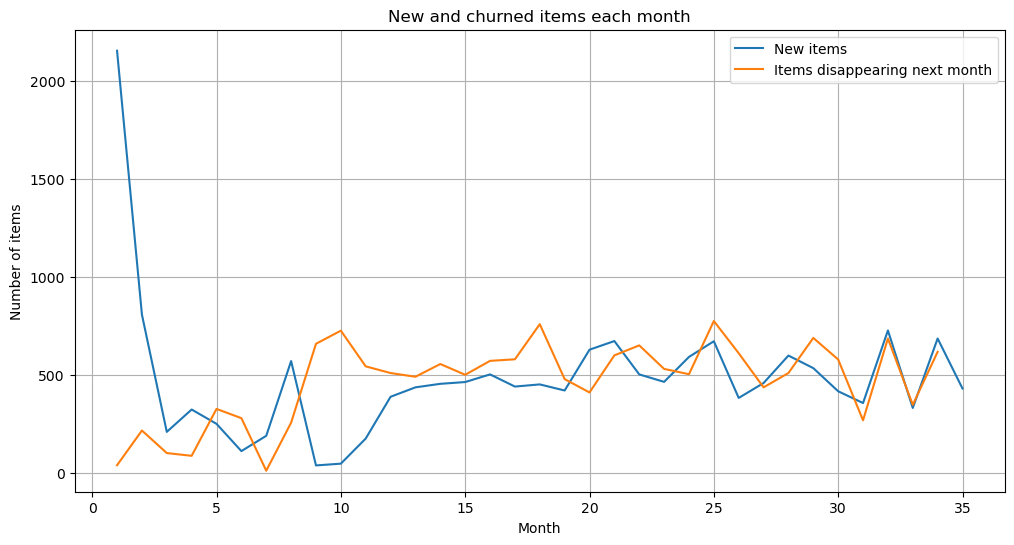

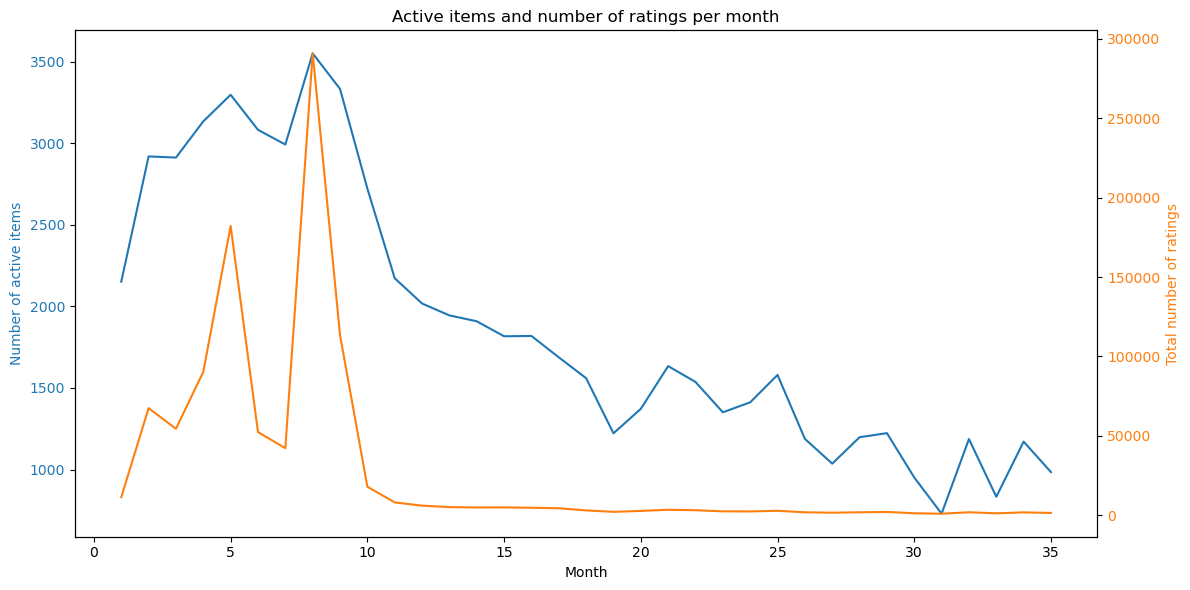

In [49]:
# New vs churned items each month
plt.figure(figsize=(12,6))
plt.plot(item_flow['month_idx'], item_flow['new_movies'], label="New items")
plt.plot(item_flow['month_idx'], item_flow['churned_next_month_movies'], label="Items disappearing next month")
plt.xlabel("Month")
plt.ylabel("Number of items")
plt.title("New and churned items each month")
plt.legend()
plt.grid(True)
plt.show()

# Active items and the total number of ratings each month
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of active items", color=color)
ax1.plot(item_flow['month_idx'], item_flow['active_movies'], color=color, label="Active items")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel("Total number of ratings", color=color)
ax2.plot(item_flow['month_idx'], item_flow['total_ratings_this_month'], color=color, label="Total number of ratings")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Active items and number of ratings per month")
fig.tight_layout()
plt.show()


In [50]:

df_user_ratings = ratings.copy()
if not pd.api.types.is_datetime64_any_dtype(df_user_ratings['timestamp']):
    df_user_ratings['timestamp'] = pd.to_datetime(df['timestamp'])

df_user_ratings = df_user_ratings.sort_values('timestamp')
df_user_ratings['ym'] = df_user_ratings['timestamp'].dt.to_period('M')
months = np.array(sorted(df_user_ratings['ym'].unique(), key=lambda x: (x.year, x.month)))
df_user_ratings


userId  movieId  rating           timestamp       ym  month_idx
1000138    6040      858       4 2000-04-25 23:05:32  2000-04          1
1000153    6040     2384       4 2000-04-25 23:05:54  2000-04          1
999873     6040      593       5 2000-04-25 23:05:54  2000-04          1
1000007    6040     1961       4 2000-04-25 23:06:17  2000-04          1
1000192    6040     2019       5 2000-04-25 23:06:17  2000-04          1
...         ...      ...     ...                 ...      ...        ...
825793     4958     2399       1 2003-02-28 17:45:38  2003-02         35
825438     4958     1407       5 2003-02-28 17:47:23  2003-02         35
825731     4958     2634       3 2003-02-28 17:49:08  2003-02         35
825724     4958     3264       4 2003-02-28 17:49:08  2003-02         35
825603     4958     1924       4 2003-02-28 17:49:50  2003-02         35

[1000209 rows x 6 columns]

item_category  Long Tail  Mid-Tier  Short Head   total     sh_pct    mid_pct  \
ym                                                                             
2000-04             2169      6854        2373   11396  20.823096  60.143910   
2000-05            12325     40566       14546   67437  21.569761  60.153921   
2000-06             9844     32740       11902   54486  21.844143  60.088830   
2000-07            17247     54364       18723   90334  20.726415  60.181106   
2000-08            36934    110106       35069  182109  19.257148  60.461592   
2000-09            10231     31216       10974   52421  20.934358  59.548654   
2000-10             8282     25442        8570   42294  20.262921  60.155105   
2000-11            56943    173545       60305  290793  20.738120  59.679910   
2000-12            22361     68364       22762  113487  20.056923  60.239499   
2001-01             4243     11013        2748   18004  15.263275  61.169740   
2001-02             1994      4883      

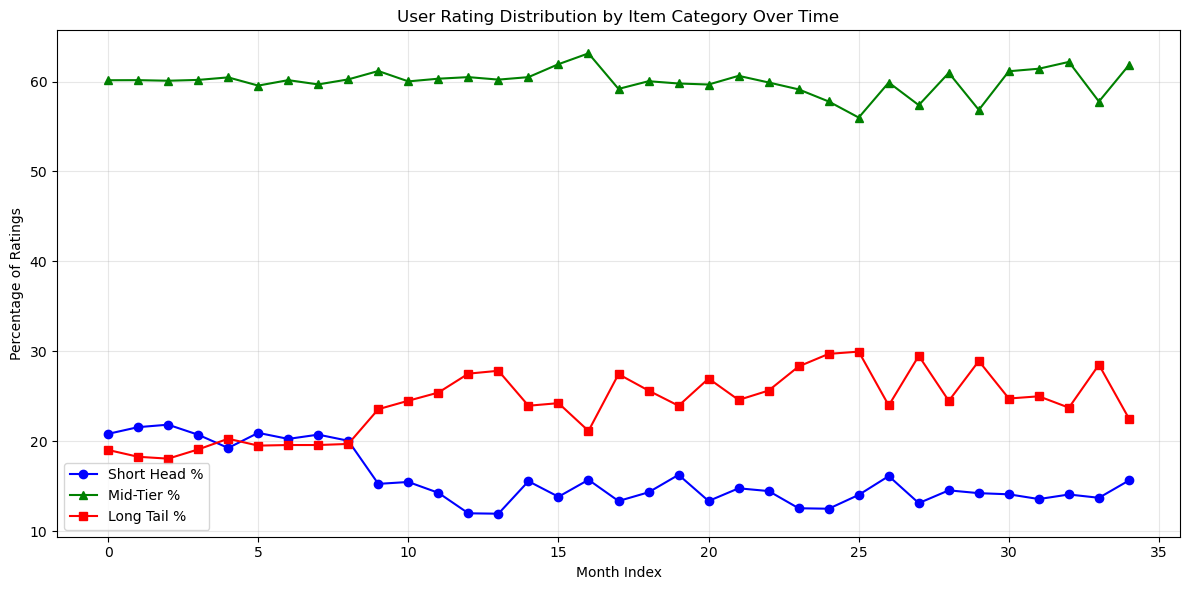

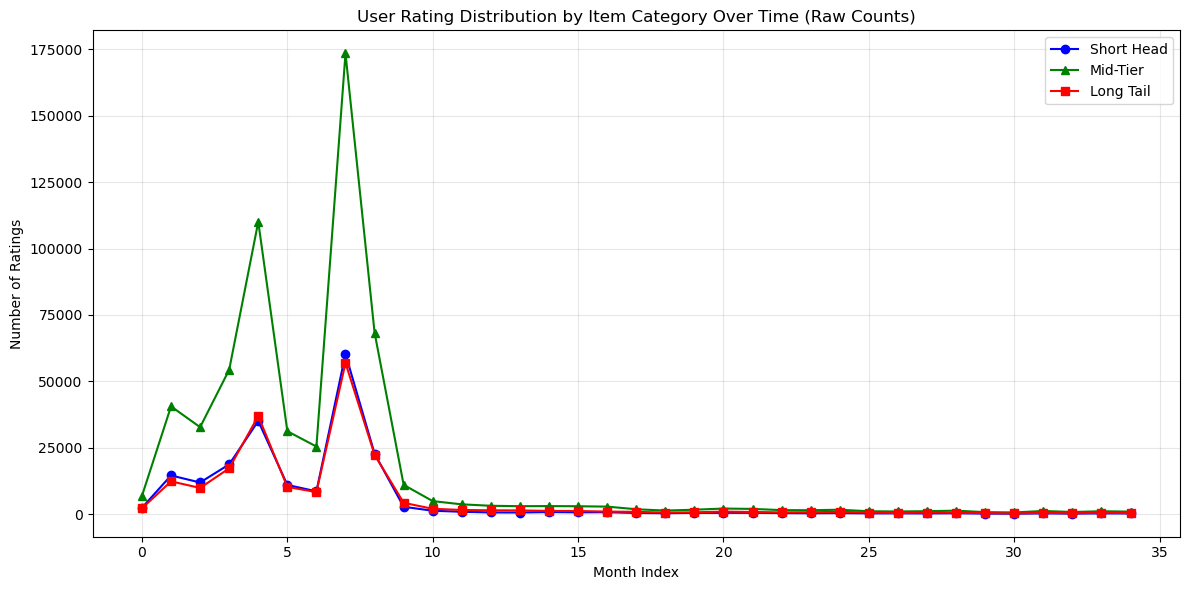

In [51]:

short_head_items = set(G[0])
mid_tier_items = set(G[1])
long_tail_items = set(G[2])

# Categorize ratings
def categorize_rating(movie_id):
    if movie_id in short_head_items:
        return 'Short Head'
    elif movie_id in mid_tier_items:
        return 'Mid-Tier'
    else:
        return 'Long Tail'

ratings['item_category'] = ratings['movieId'].apply(categorize_rating)

# Monthly distribution
monthly_dist = ratings.groupby(['ym', 'item_category']).size().unstack(fill_value=0)
monthly_dist['total'] = monthly_dist.sum(axis=1)
monthly_dist['sh_pct'] = (monthly_dist['Short Head'] / monthly_dist['total']) * 100
monthly_dist['mid_pct'] = (monthly_dist['Mid-Tier'] / monthly_dist['total']) * 100
monthly_dist['lt_pct'] = (monthly_dist['Long Tail'] / monthly_dist['total']) * 100

print(monthly_dist)

# Plot percentages
plt.figure(figsize=(12, 6))
plt.plot(range(len(monthly_dist)), monthly_dist['sh_pct'], 'o-', label='Short Head %', color='blue')
plt.plot(range(len(monthly_dist)), monthly_dist['mid_pct'], '^-', label='Mid-Tier %', color='green')
plt.plot(range(len(monthly_dist)), monthly_dist['lt_pct'], 's-', label='Long Tail %', color='red')
plt.xlabel('Month Index')
plt.ylabel('Percentage of Ratings')
plt.title('User Rating Distribution by Item Category Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot raw counts
plt.figure(figsize=(12, 6))
plt.plot(range(len(monthly_dist)), monthly_dist['Short Head'], 'o-', label='Short Head', color='blue')
plt.plot(range(len(monthly_dist)), monthly_dist['Mid-Tier'], '^-', label='Mid-Tier', color='green')
plt.plot(range(len(monthly_dist)), monthly_dist['Long Tail'], 's-', label='Long Tail', color='red')
plt.xlabel('Month Index')
plt.ylabel('Number of Ratings')
plt.title('User Rating Distribution by Item Category Over Time (Raw Counts)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

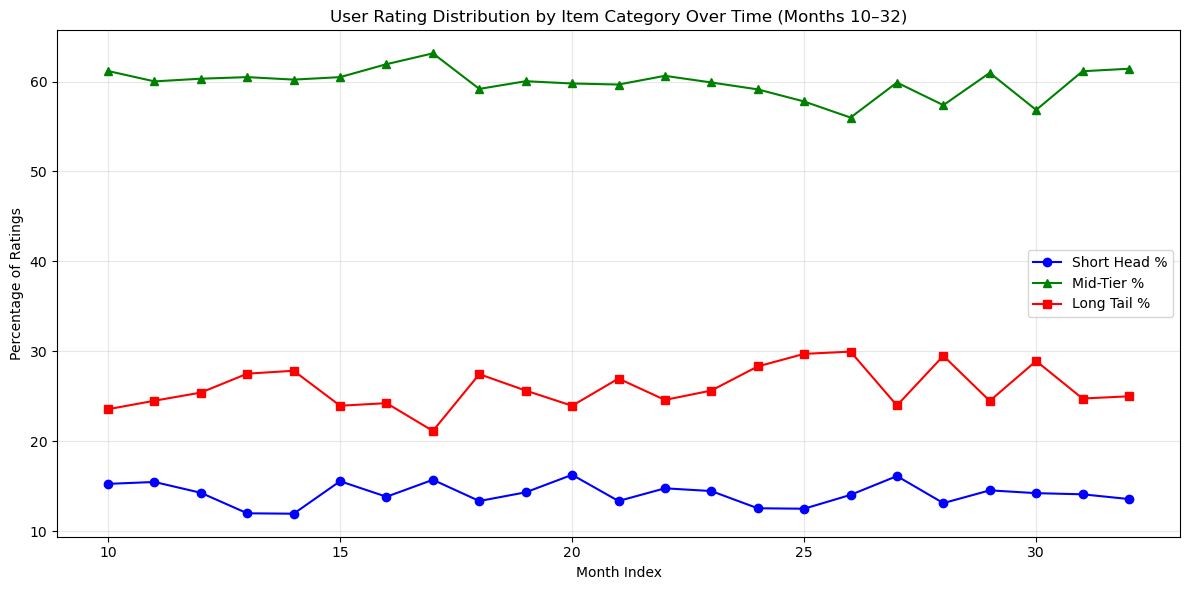

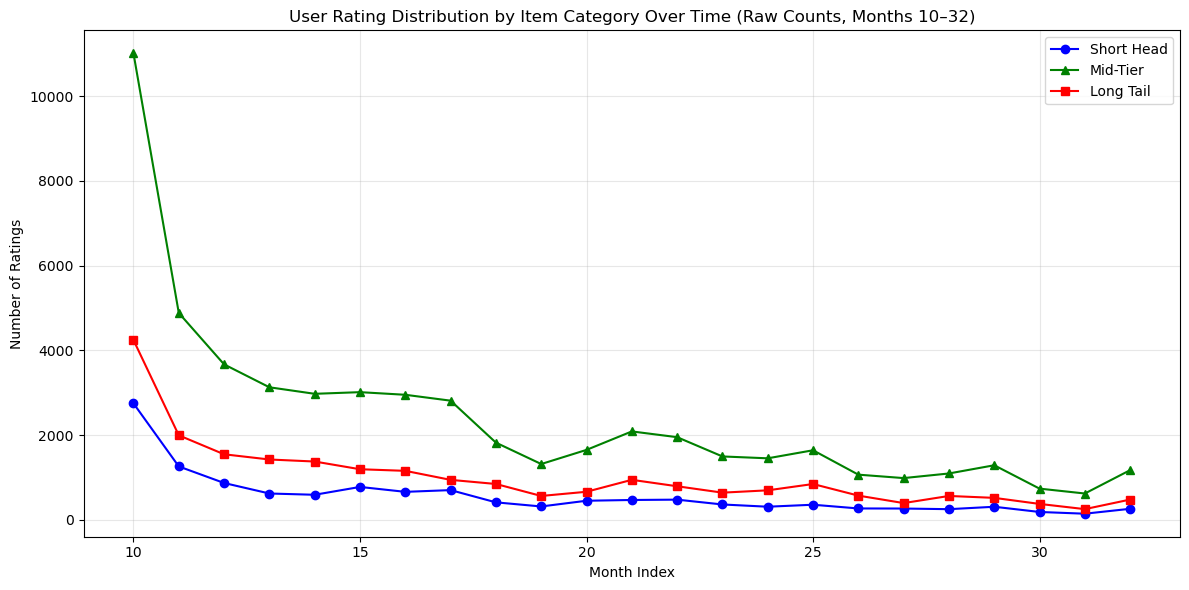

In [52]:
# Filter months 10–32 (assuming 'ym' is sequential and sorted)
monthly_dist_filtered = monthly_dist.iloc[9:32]  # Python is 0-indexed, so 9 = month 10

# Plot percentages
plt.figure(figsize=(12, 6))
plt.plot(range(10, 33), monthly_dist_filtered['sh_pct'], 'o-', label='Short Head %', color='blue')
plt.plot(range(10, 33), monthly_dist_filtered['mid_pct'], '^-', label='Mid-Tier %', color='green')
plt.plot(range(10, 33), monthly_dist_filtered['lt_pct'], 's-', label='Long Tail %', color='red')
plt.xlabel('Month Index')
plt.ylabel('Percentage of Ratings')
plt.title('User Rating Distribution by Item Category Over Time (Months 10–32)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot raw counts
plt.figure(figsize=(12, 6))
plt.plot(range(10, 33), monthly_dist_filtered['Short Head'], 'o-', label='Short Head', color='blue')
plt.plot(range(10, 33), monthly_dist_filtered['Mid-Tier'], '^-', label='Mid-Tier', color='green')
plt.plot(range(10, 33), monthly_dist_filtered['Long Tail'], 's-', label='Long Tail', color='red')
plt.xlabel('Month Index')
plt.ylabel('Number of Ratings')
plt.title('User Rating Distribution by Item Category Over Time (Raw Counts, Months 10–32)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


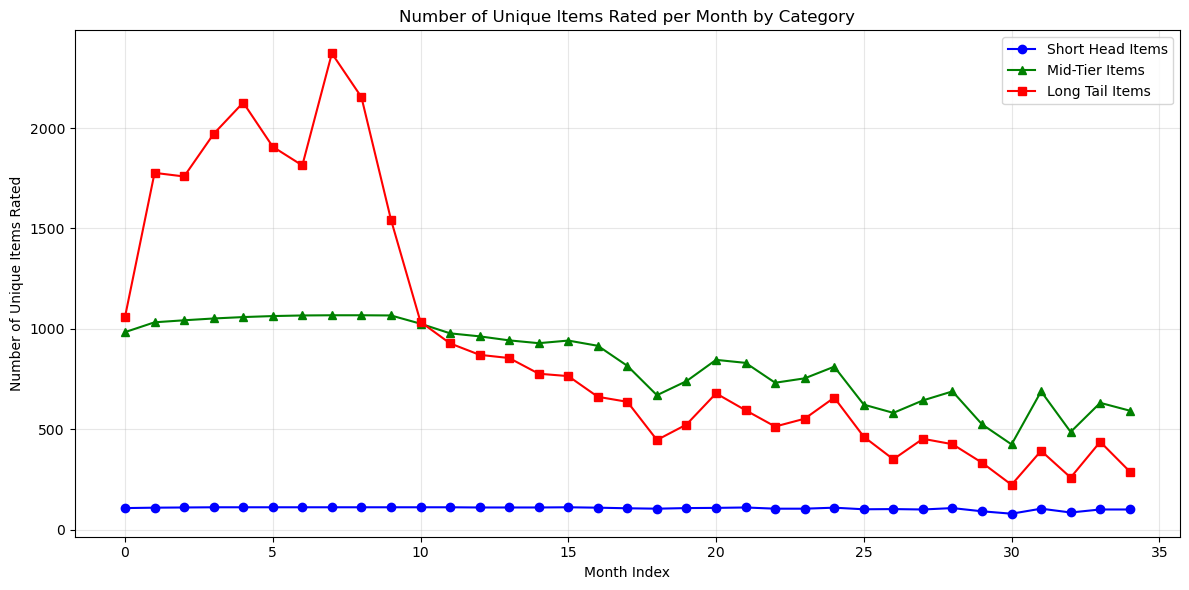

item_category  Long Tail  Mid-Tier  Short Head
ym                                            
2000-04             1060       984         108
2000-05             1777      1033         110
2000-06             1759      1043         111
2000-07             1971      1052         112
2000-08             2127      1059         112
2000-09             1907      1064         112
2000-10             1814      1067         112
2000-11             2372      1068         112
2000-12             2154      1068         112
2001-01             1544      1067         112
2001-02             1035      1026         112
2001-03              928       978         112
2001-04              871       963         111
2001-05              855       943         111
2001-06              777       929         111
2001-07              765       942         112
2001-08              662       916         110
2001-09              637       816         107
2001-10              447       670         105
2001-11      

In [53]:
# Number of unique items rated per month (by category)
unique_items_monthly = ratings.groupby(['ym', 'item_category'])['movieId'].nunique().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
plt.plot(range(len(unique_items_monthly)), unique_items_monthly['Short Head'], 
         marker='o', label='Short Head Items', color='blue')
plt.plot(range(len(unique_items_monthly)), unique_items_monthly['Mid-Tier'], 
         marker='^', label='Mid-Tier Items', color='green')
plt.plot(range(len(unique_items_monthly)), unique_items_monthly['Long Tail'], 
         marker='s', label='Long Tail Items', color='red')
plt.xlabel('Month Index')
plt.ylabel('Number of Unique Items Rated')
plt.title('Number of Unique Items Rated per Month by Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show the data
print(unique_items_monthly)

             mean       std   count
ym                                 
2000-04  3.553352  1.086216   11396
2000-05  3.613447  1.142933   67437
2000-06  3.633906  1.112886   54486
2000-07  3.630073  1.091738   90334
2000-08  3.572174  1.122029  182109
2000-09  3.609717  1.117345   52421
2000-10  3.620419  1.087371   42294
2000-11  3.571671  1.130624  290793
2000-12  3.585019  1.115809  113487
2001-01  3.543657  1.064980   18004
2001-02  3.551500  1.088263    8136
2001-03  3.528358  1.053631    6083
2001-04  3.471282  1.111787    5171
2001-05  3.460822  1.052025    4939
2001-06  3.472797  1.079897    4981
2001-07  3.476600  1.078435    4765
2001-08  3.467670  1.136817    4454
2001-09  3.541111  1.048258    3077
2001-10  3.415602  1.100265    2192
2001-11  3.594203  1.083252    2760
2001-12  3.496568  1.089153    3496
2002-01  3.557525  1.071235    3216
2002-02  3.473558  1.071821    2496
2002-03  3.279951  1.121751    2454
2002-04  3.488732  1.108366    2840
2002-05  3.556782  1.127199 

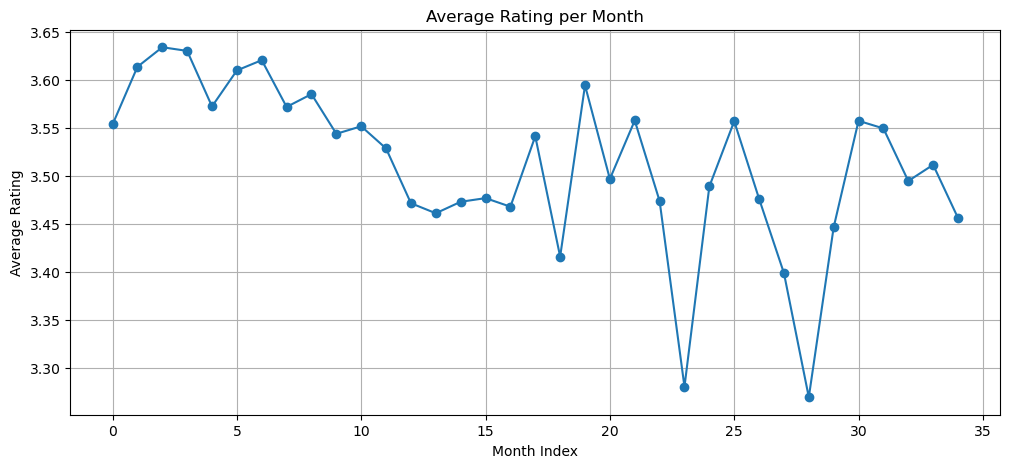

In [54]:
monthly_rating_stats = df_user_ratings.groupby('ym')['rating'].agg(['mean', 'std', 'count'])
print(monthly_rating_stats)

plt.figure(figsize=(12, 5))
plt.plot(range(len(monthly_rating_stats)), monthly_rating_stats['mean'], marker='o')
plt.xlabel('Month Index')
plt.ylabel('Average Rating')
plt.title('Average Rating per Month')
plt.grid(True)
plt.show()

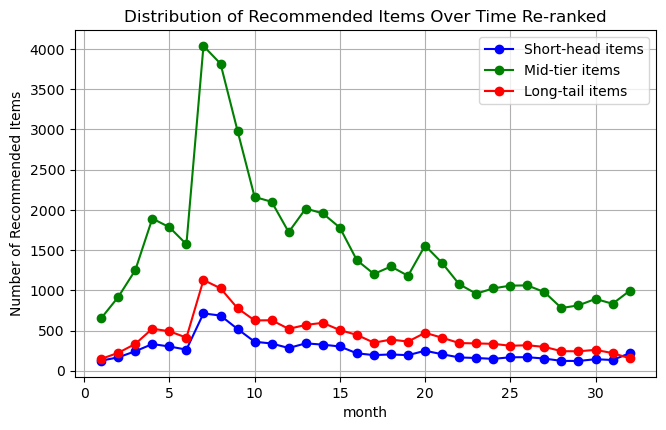

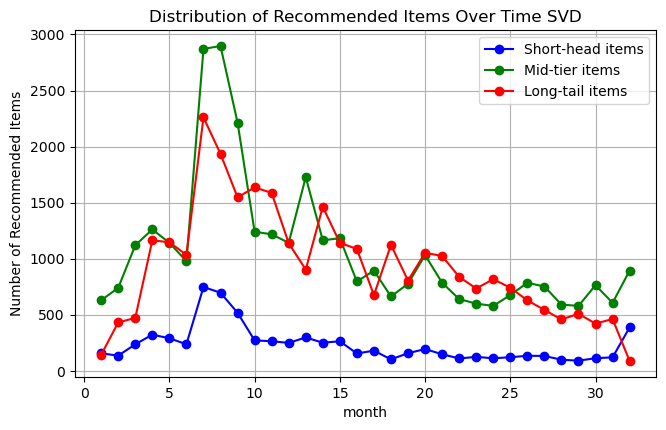

In [55]:
months = group_counts_df['month']
short_head_counts = group_counts_df['short_head_count']
mid_counts = group_counts_df['mid_count']
long_tail_counts = group_counts_df['long_tail_count']


plt.figure(figsize=(7.5, 4.5))

plt.plot(months, short_head_counts, marker='o', color='b', label='Short-head items')
plt.plot(months, mid_counts, marker='o', color='g', label='Mid-tier items')
plt.plot(months, long_tail_counts, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time Re-ranked')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()


months2 = group_counts_svd_df['month']
short_head_counts2 = group_counts_svd_df['short_head_count']
mid_counts2 = group_counts_svd_df['mid_count']
long_tail_counts2 = group_counts_svd_df['long_tail_count']

plt.figure(figsize=(7.5, 4.5))

plt.plot(months2, short_head_counts2, marker='o', color='b', label='Short-head items')
plt.plot(months2, mid_counts2, marker='o', color='g', label='Mid-tier items')
plt.plot(months2, long_tail_counts2, marker='o', color='r', label='Long-tail items')

plt.title('Distribution of Recommended Items Over Time SVD')
plt.xlabel('month')
plt.ylabel('Number of Recommended Items')
plt.grid(True)
plt.legend()

plt.show()

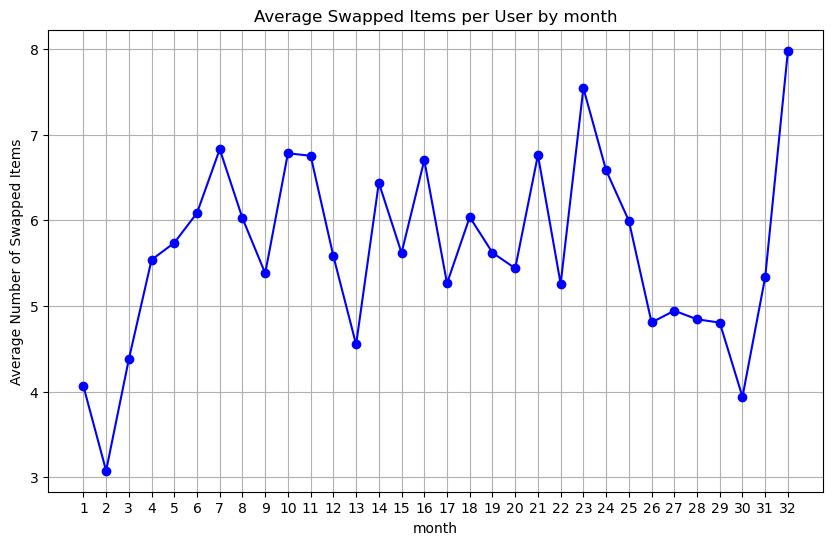

In [56]:
months = sorted(monthly_swapped_counts.keys())
avg_swaps = [monthly_swapped_counts[w] for w in months]

plt.figure(figsize=(10,6))
plt.plot(months, avg_swaps, marker='o', linestyle='-', color='b')
plt.title("Average Swapped Items per User by month")
plt.xlabel("month")
plt.ylabel("Average Number of Swapped Items")
plt.grid(True)
plt.xticks(months)
plt.show()


In [57]:
# Ensure the timestamp column is a datetime type
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

# Convert timestamps to monthly periods
monthly_periods = ratings['timestamp'].dt.to_period('M')

# Count the unique months
num_months = monthly_periods.nunique()
print("Number of months in the dataset:", num_months)

Number of months in the dataset: 35


In [58]:
precision_values = [result['precision@10'] for result in monthly_results]

cp_mean_precision = np.mean(results_df['precision@10'])
svd_mean_precision =np.mean(precision_values)

print(f"Mean precision for CP: {cp_mean_precision:.4f}")
print(f"Mean precision for SVD: {svd_mean_precision:.4f}")

Mean precision for CP: 0.8767
Mean precision for SVD: 0.6698


In [59]:
recall_values = [result['recall@10'] for result in monthly_results]

cp_mean_recall = np.mean(results_df['recall@10'])
svd_mean_recall =np.mean(recall_values)

print(f"Mean recall for CP: {cp_mean_recall:.4f}")
print(f"Mean recall for SVD: {svd_mean_recall:.4f}")

Mean recall for CP: 0.9055
Mean recall for SVD: 0.5084


In [60]:
rmse_values = [result['rmse'] for result in monthly_results]

cp_mean_rmse = np.mean(results_df['rmse'])
svd_mean_rmse =np.mean(rmse_values)

print(f"Mean rmse for CP: {cp_mean_rmse:.4f}")
print(f"Mean rmse for SVD: {svd_mean_rmse:.4f}")

Mean rmse for CP: 0.7549
Mean rmse for SVD: 0.9114


In [61]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Metric':       ['RMSE ↓',       'Precision@10 ↑',       'Recall@10 ↑'],
    'SVD':          [svd_mean_rmse, svd_mean_precision,  svd_mean_recall],
    'CP': [cp_mean_rmse, cp_mean_precision, cp_mean_recall]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


| Metric         |   SVD |    CP |
|----------------|-------|-------|
| RMSE ↓         | 0.911 | 0.755 |
| Precision@10 ↑ | 0.670 | 0.877 |
| Recall@10 ↑    | 0.508 | 0.905 |


In [62]:
gini_values = [result['gini_index'] for result in monthly_results]
cp_mean_gini = np.mean(results_df['gini_index'])

svd_mean_gini =np.mean(gini_values)

print(f"Mean Gini Index for CP: {cp_mean_gini:.4f}")
print(f"Mean Gini Index for SVD: {svd_mean_gini:.4f}")

Mean Gini Index for CP: 0.6366
Mean Gini Index for SVD: 0.6355


In [63]:
arp_values = [result['arp'] for result in monthly_results]

cp_mean_arp = np.mean(results_df['arp'])
svd_mean_arp =np.mean(arp_values)

print(f"Mean arp for CP: {cp_mean_arp:.4f}")
print(f"Mean arp for SVD: {svd_mean_arp:.4f}")

Mean arp for CP: 0.2648
Mean arp for SVD: 0.2048


In [64]:
aplt_values = [result['aplt'] for result in monthly_results]

cp_mean_aplt = np.mean(results_df['aplt'])
svd_mean_aplt =np.mean(aplt_values)

print(f"Mean aplt for CP: {cp_mean_aplt:.4f}")
print(f"Mean aplt for SVD: {svd_mean_aplt:.4f}")

Mean aplt for CP: 0.1957
Mean aplt for SVD: 0.4075


In [65]:
# Build a small summary DataFrame

summary = pd.DataFrame({
    'Beyond Metric':       ['Gini-Index ↓',       'ARP ↓',       'APLT ↑'],
    'SVD':          [svd_mean_gini, svd_mean_arp,  svd_mean_aplt],
    'CP': [cp_mean_gini, cp_mean_arp, cp_mean_aplt]
})
#summary = summary.round(3)
from tabulate import tabulate
print(
    tabulate(
        summary, 
        headers="keys", 
        tablefmt="github", 
        floatfmt=".3f", 
        showindex=False
    )
)


| Beyond Metric   |   SVD |    CP |
|-----------------|-------|-------|
| Gini-Index ↓    | 0.636 | 0.637 |
| ARP ↓           | 0.205 | 0.265 |
| APLT ↑          | 0.407 | 0.196 |


In [66]:
top10_df = (
    recommendations_df
    # 1) Sort by month, then user, then rating descending 
    .sort_values(['month','userId','rating'], ascending=[True,True,False])
    # 2) For each (month, userId) pair, keep only the first 10 rows
    .groupby(['month','userId'], group_keys=False)
    .head(10)
    .reset_index(drop=True)
)
top10_df.head(15)

userId  movieId    rating  month
0     5574     1193  4.995718      1
1     5574      527  4.986051      1
2     5574      750  4.982552      1
3     5574     1207  4.938688      1
4     5574     2019  4.893261      1
5     5574     1248  4.873576      1
6     5574     1300  4.864753      1
7     5574     2186  4.839169      1
8     5574     1204  4.835983      1
9     5574     1262  4.775963      1
10    5576       50  5.000000      1
11    5576       58  5.000000      1
12    5576      541  5.000000      1
13    5576      903  5.000000      1
14    5576      904  5.000000      1

In [67]:
# === OVERALL USER OVERLAP ===

# Collect all raw user‐IDs seen in any train split
train_users = set()
for trainset, _, *_ in train_test_sets:
    train_users |= { trainset.to_raw_uid(uid) for uid in trainset.all_users() }

# Collect all user‐IDs seen in any test split
test_users = set()
for _, testset, *_ in train_test_sets:
    test_users |= { u for u, _, _ in testset }

overlap = train_users & test_users

print(f"Overall train users: {len(train_users)}")
print(f"Overall test  users: {len(test_users)}")
print(f"Overlap users     : {len(overlap)} "
      f"({len(overlap)/len(test_users)*100:.2f}% of test users)")

# === PER-MONTH USER OVERLAP ===

# If you want to see it month by month:
months = sorted(top10_df['month'].unique())
for month, (trainset, testset, *_ ) in zip(months, train_test_sets):
    train_u = { trainset.to_raw_uid(uid) for uid in trainset.all_users() }
    test_u  = { u for u, _, _ in testset }
    ov      = train_u & test_u
    pct     = len(ov) / len(test_u) * 100 if test_u else 0.0
    print(f"Month {month}: {len(ov)} overlapping users "
          f"({pct:.2f}% of that month’s test users)")


Overall train users: 6040
Overall test  users: 5708
Overlap users     : 5708 (100.00% of test users)
Month 1: 93 overlapping users (18.06% of that month’s test users)
Month 2: 131 overlapping users (17.87% of that month’s test users)
Month 3: 183 overlapping users (14.25% of that month’s test users)
Month 4: 275 overlapping users (42.31% of that month’s test users)
Month 5: 258 overlapping users (53.53% of that month’s test users)
Month 6: 225 overlapping users (10.51% of that month’s test users)
Month 7: 588 overlapping users (40.95% of that month’s test users)
Month 8: 553 overlapping users (87.36% of that month’s test users)
Month 9: 428 overlapping users (99.77% of that month’s test users)
Month 10: 315 overlapping users (100.00% of that month’s test users)
Month 11: 307 overlapping users (100.00% of that month’s test users)
Month 12: 253 overlapping users (99.61% of that month’s test users)
Month 13: 293 overlapping users (99.66% of that month’s test users)
Month 14: 288 overlappi

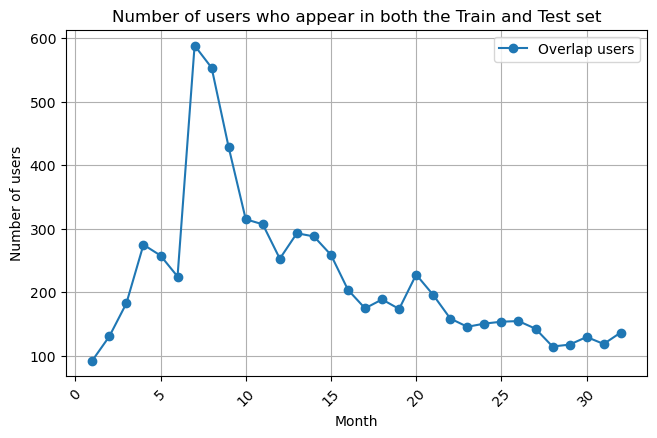

In [68]:
# 1) Gather per-month counts
months       = sorted(top10_df['month'].unique())
train_counts = []
test_counts  = []
overlap_counts = []

for month, (trainset, testset, *_) in zip(months, train_test_sets):
    # users seen in training (Surprise trainset)
    train_users = {trainset.to_raw_uid(uid) for uid in trainset.all_users()}
    # users in that month's test
    test_users  = {u for u, _, _ in testset}
    overlap     = train_users & test_users

    train_counts.append(len(train_users))
    test_counts.append(len(test_users))
    overlap_counts.append(len(overlap))

# 2) Plot all three series on one chart
plt.figure(figsize=(7.5, 4.5))
plt.plot(months, overlap_counts, marker='o', label='Overlap users')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of users')
plt.title('Number of users who appear in both the Train and Test set')
plt.legend()
plt.grid(True)
plt.show()

=== TEST COVERAGE COMPARISON ===

Month 1 SVD test coverage: 5.18% (152/2935 items)
Month 2 SVD test coverage: 16.03% (495/3088 items)
Month 3 SVD test coverage: 4.51% (149/3301 items)
Month 4 SVD test coverage: 14.14% (440/3111 items)
Month 5 SVD test coverage: 13.55% (413/3048 items)
Month 6 SVD test coverage: 12.64% (444/3514 items)
Month 7 SVD test coverage: 4.18% (142/3396 items)
Month 8 SVD test coverage: 13.18% (384/2913 items)
Month 9 SVD test coverage: 17.10% (398/2328 items)
Month 10 SVD test coverage: 18.00% (354/1967 items)
Month 11 SVD test coverage: 17.52% (324/1849 items)
Month 12 SVD test coverage: 15.43% (308/1996 items)
Month 13 SVD test coverage: 3.38% (62/1836 items)
Month 14 SVD test coverage: 19.04% (324/1702 items)
Month 15 SVD test coverage: 16.51% (301/1823 items)
Month 16 SVD test coverage: 14.82% (230/1552 items)
Month 17 SVD test coverage: 17.17% (209/1217 items)
Month 18 SVD test coverage: 28.29% (406/1435 items)
Month 19 SVD test coverage: 17.29% (237/1371

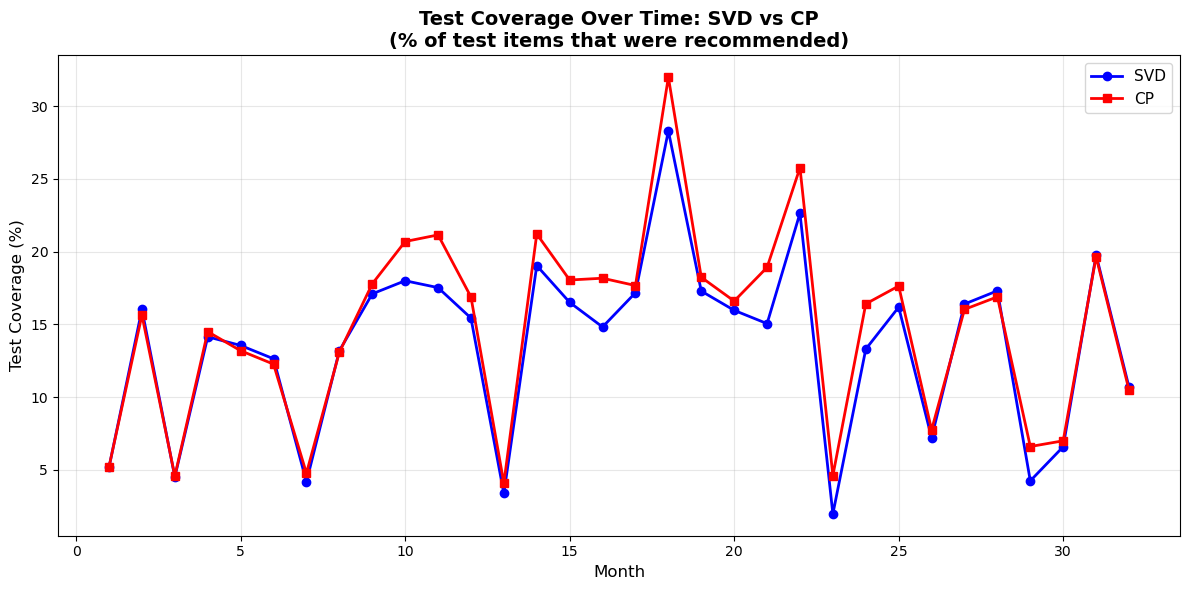

In [69]:
print("=== TEST COVERAGE COMPARISON ===\n")

# 1) Build month-to-test mapping
months = sorted(top10_df['month'].unique())
month_to_test = {
    month: testset
    for month, (_, testset, *_rest) in zip(months, train_test_sets)
}

# SVD Test Coverage
test_coverages_svd = []
for month in months:
    # Extract unique items recommended by SVD
    recommended_items = set(top10_df[top10_df['month'] == month]['movieId'].unique())
    
    # Extract unique items from test set
    test_items = set([m for u, m, _ in month_to_test[month]])
    
    # Calculate test coverage (item-level)
    items_covered = len(recommended_items & test_items)
    total_test_items = len(test_items)
    test_cov_pct = (items_covered / total_test_items * 100) if total_test_items > 0 else 0
    
    print(f"Month {month} SVD test coverage: {test_cov_pct:.2f}% ({items_covered}/{total_test_items} items)")
    test_coverages_svd.append(test_cov_pct)

avg_test_cov_svd = sum(test_coverages_svd) / len(test_coverages_svd) if test_coverages_svd else 0
print(f"\nAverage SVD test coverage: {avg_test_cov_svd:.2f}%\n")

# CP Test Coverage
test_coverages_cp = []
for month in months:
    # Extract unique items recommended by CP
    recommended_items = set(reranked_df[reranked_df['month'] == month]['movieId'].unique())
    
    # Extract unique items from test set
    test_items = set([m for u, m, _ in month_to_test[month]])
    
    # Calculate test coverage (item-level)
    items_covered = len(recommended_items & test_items)
    total_test_items = len(test_items)
    test_cov_pct = (items_covered / total_test_items * 100) if total_test_items > 0 else 0
    
    print(f"Month {month} CP test coverage: {test_cov_pct:.2f}% ({items_covered}/{total_test_items} items)")
    test_coverages_cp.append(test_cov_pct)

avg_test_cov_cp = sum(test_coverages_cp) / len(test_coverages_cp) if test_coverages_cp else 0
print(f"\nAverage CP test coverage: {avg_test_cov_cp:.2f}%")

# Summary Comparison
print(f"\n=== SUMMARY ===")
print(f"SVD Test Coverage: {avg_test_cov_svd:.2f}%")
print(f"CP Test Coverage:  {avg_test_cov_cp:.2f}%")
print(f"Improvement: +{avg_test_cov_cp - avg_test_cov_svd:.2f} percentage points")
print(f"Relative improvement: +{((avg_test_cov_cp - avg_test_cov_svd) / avg_test_cov_svd * 100):.1f}%")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(months, test_coverages_svd, 
         'o-', label='SVD', color='blue', linewidth=2)
plt.plot(months, test_coverages_cp, 
         's-', label='CP', color='red', linewidth=2)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Test Coverage (%)', fontsize=12)
plt.title('Test Coverage Over Time: SVD vs CP\n(% of test items that were recommended)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('test_coverage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

=== Catalog Coverage Summary ===

SVD:
  Average: 9.19%
  Min: 1.43%
  Max: 21.34%

CP:
  Average: 9.08%
  Min: 1.92%
  Max: 19.00%

Improvement:
  Average: +-0.11 percentage points
  Relative: +-1.2%


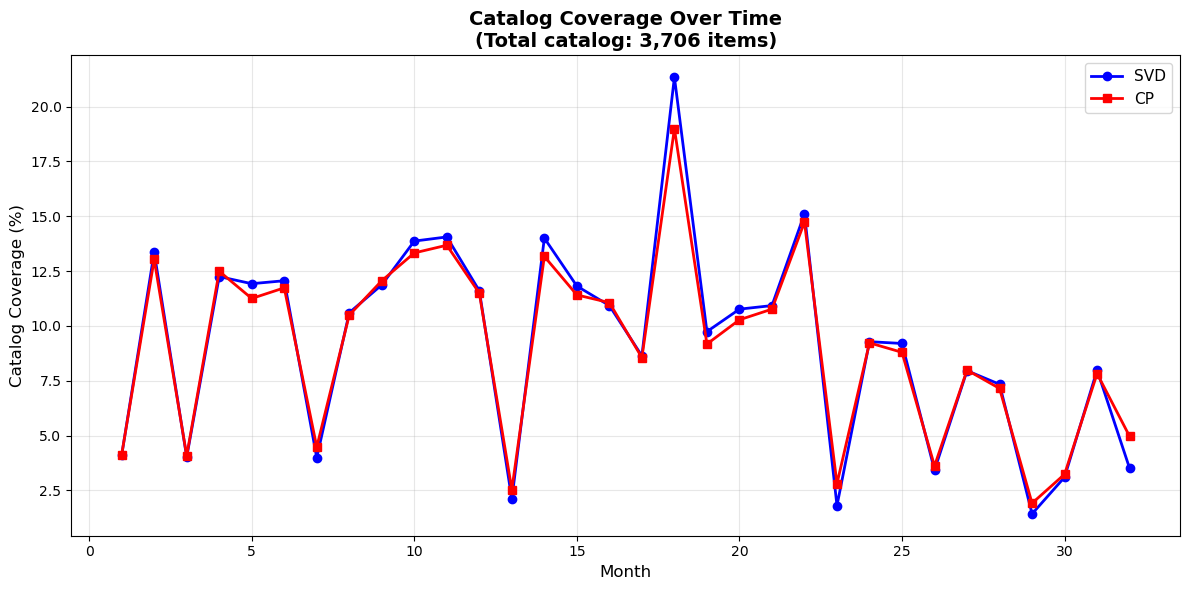

In [70]:
# Calculate catalog coverage for both SVD and CP
total_catalog = ratings['movieId'].nunique()

svd_catalog_coverage = []
cp_catalog_coverage = []

months_svd = sorted(top10_df['month'].unique())
months_cp = sorted(reranked_df['month'].unique())

# SVD Catalog Coverage
for month in months_svd:
    rec_items = set(top10_df[top10_df['month'] == month]['movieId'])
    cov = len(rec_items) / total_catalog * 100
    svd_catalog_coverage.append(cov)

# CP Catalog Coverage  
for month in months_cp:
    rec_items = set(reranked_df[reranked_df['month'] == month]['movieId'])
    cov = len(rec_items) / total_catalog * 100
    cp_catalog_coverage.append(cov)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(months_svd, svd_catalog_coverage, 
         marker='o', label='SVD', color='blue', linewidth=2, markersize=6)
plt.plot(months_cp, cp_catalog_coverage, 
         marker='s', label='CP', color='red', linewidth=2, markersize=6)

plt.xlabel('Month', fontsize=12)
plt.ylabel('Catalog Coverage (%)', fontsize=12)
plt.title(f'Catalog Coverage Over Time\n(Total catalog: {total_catalog:,} items)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Print summary statistics
print(f"=== Catalog Coverage Summary ===")
print(f"\nSVD:")
print(f"  Average: {np.mean(svd_catalog_coverage):.2f}%")
print(f"  Min: {np.min(svd_catalog_coverage):.2f}%")
print(f"  Max: {np.max(svd_catalog_coverage):.2f}%")

print(f"\nCP:")
print(f"  Average: {np.mean(cp_catalog_coverage):.2f}%")
print(f"  Min: {np.min(cp_catalog_coverage):.2f}%")
print(f"  Max: {np.max(cp_catalog_coverage):.2f}%")

print(f"\nImprovement:")
print(f"  Average: +{np.mean(cp_catalog_coverage) - np.mean(svd_catalog_coverage):.2f} percentage points")
print(f"  Relative: +{((np.mean(cp_catalog_coverage) - np.mean(svd_catalog_coverage)) / np.mean(svd_catalog_coverage) * 100):.1f}%")

plt.savefig('catalog_coverage_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [71]:
# === Distribution Analysis ===
print("Comparing recommendation distributions to user behavior\n")

results = []

for month in [8, 9, 10]:
    # Get the actual period for this month
    month_period = sorted(ratings['ym'].unique())[month-1]
    
    # What users actually rated in that period
    test_ratings = ratings[ratings['ym'] == month_period]
    
    if len(test_ratings) == 0:
        print(f"Month {month}: No test data")
        continue
    
    user_sh_pct = sum(test_ratings['movieId'].isin(short_head_items)) / len(test_ratings) * 100
    user_mid_pct = sum(test_ratings['movieId'].isin(mid_items)) / len(test_ratings) * 100
    user_lt_pct = sum(test_ratings['movieId'].isin(long_tail_items)) / len(test_ratings) * 100
    
    # What SVD recommended
    svd_recs = top10_df[top10_df['month'] == month]
    if len(svd_recs) == 0:
        print(f"Month {month}: No SVD recs")
        continue
        
    svd_sh_pct = sum(svd_recs['movieId'].isin(short_head_items)) / len(svd_recs) * 100
    svd_mid_pct = sum(svd_recs['movieId'].isin(mid_items)) / len(svd_recs) * 100
    svd_lt_pct = sum(svd_recs['movieId'].isin(long_tail_items)) / len(svd_recs) * 100
    
    # What CP recommended
    cp_recs = reranked_df[reranked_df['month'] == month]
    if len(cp_recs) == 0:
        print(f"Month {month}: No CP recs")
        continue
        
    cp_sh_pct = sum(cp_recs['movieId'].isin(short_head_items)) / len(cp_recs) * 100
    cp_mid_pct = sum(cp_recs['movieId'].isin(mid_items)) / len(cp_recs) * 100
    cp_lt_pct = sum(cp_recs['movieId'].isin(long_tail_items)) / len(cp_recs) * 100
    
    print(f"{'='*70}")
    print(f"Month {month} ({month_period})")
    print(f"{'='*70}")
    print(f"{'':20} Short-head  Mid-tier  Long-tail")
    print(f"{'User Behavior:':20} {user_sh_pct:6.1f}%   {user_mid_pct:6.1f}%   {user_lt_pct:6.1f}%")
    print(f"{'SVD Recs:':20} {svd_sh_pct:6.1f}%   {svd_mid_pct:6.1f}%   {svd_lt_pct:6.1f}%")
    print(f"{'CP Recs:':20} {cp_sh_pct:6.1f}%   {cp_mid_pct:6.1f}%   {cp_lt_pct:6.1f}%")
    
    # Distance from user behavior
    from scipy.spatial.distance import euclidean
    svd_distance = euclidean([user_sh_pct, user_mid_pct, user_lt_pct],
                              [svd_sh_pct, svd_mid_pct, svd_lt_pct])
    cp_distance = euclidean([user_sh_pct, user_mid_pct, user_lt_pct],
                             [cp_sh_pct, cp_mid_pct, cp_lt_pct])
    
    print(f"\nDistance from User Behavior:")
    print(f"  SVD: {svd_distance:.2f}")
    print(f"  CP:  {cp_distance:.2f} {'✅ CLOSER!' if cp_distance < svd_distance else ''}")
    print()
    
    results.append({
        'month': month,
        'period': str(month_period),
        'user_sh': user_sh_pct,
        'user_mid': user_mid_pct,
        'user_lt': user_lt_pct,
        'svd_distance': svd_distance,
        'cp_distance': cp_distance
    })

# Summary
if results:
    print(f"\n{'='*70}")
    print("SUMMARY")
    print(f"{'='*70}")
    results_df = pd.DataFrame(results)
    avg_svd_dist = results_df['svd_distance'].mean()
    avg_cp_dist = results_df['cp_distance'].mean()
    print(f"Average distance from user preferences:")
    print(f"  SVD: {avg_svd_dist:.2f}")
    print(f"  CP:  {avg_cp_dist:.2f}")
    
    if avg_cp_dist < avg_svd_dist:
        improvement = ((avg_svd_dist - avg_cp_dist) / avg_svd_dist) * 100
        print(f"\n✅ CP is {improvement:.1f}% closer to user preferences on average!")
    else:
        diff = ((avg_cp_dist - avg_svd_dist) / avg_svd_dist) * 100
        print(f"\n⚠️ SVD is {diff:.1f}% closer to user preferences on average")

Comparing recommendation distributions to user behavior

Month 8 (2000-11)
                     Short-head  Mid-tier  Long-tail
User Behavior:         20.7%     59.7%     19.6%
SVD Recs:              30.9%     47.1%     22.0%
CP Recs:               12.4%     69.0%     18.6%

Distance from User Behavior:
  SVD: 16.41
  CP:  12.55 ✅ CLOSER!

Month 9 (2000-12)
                     Short-head  Mid-tier  Long-tail
User Behavior:         20.1%     60.2%     19.7%
SVD Recs:              26.3%     48.7%     25.0%
CP Recs:               12.1%     69.7%     18.2%

Distance from User Behavior:
  SVD: 14.19
  CP:  12.40 ✅ CLOSER!

Month 10 (2001-01)
                     Short-head  Mid-tier  Long-tail
User Behavior:         15.3%     61.2%     23.6%
SVD Recs:              12.2%     26.9%     61.0%
CP Recs:               11.5%     68.6%     19.9%

Distance from User Behavior:
  SVD: 50.82
  CP:  9.10 ✅ CLOSER!


SUMMARY
Average distance from user preferences:
  SVD: 27.14
  CP:  11.35

✅ CP is 58.2

In [72]:
for month in [8, 9, 10]:
    # SVD recommendations for this month
    svd_recs = top10_df[top10_df['month'] == month]
    
    # Count by category (TOTAL recommendations, with repetition)
    total_sh_recs = sum(svd_recs['movieId'].isin(short_head_items))
    total_lt_recs = sum(svd_recs['movieId'].isin(long_tail_items))
    total_recs = len(svd_recs)
    
    # Count unique items
    unique_sh_items = len(set(svd_recs[svd_recs['movieId'].isin(short_head_items)]['movieId']))
    unique_lt_items = len(set(svd_recs[svd_recs['movieId'].isin(long_tail_items)]['movieId']))
    
    print(f"\n{'='*70}")
    print(f"Month {month} - SVD Analysis")
    print(f"{'='*70}")
    print(f"TOTAL RECOMMENDATIONS (what users see):")
    print(f"  Short-head: {total_sh_recs:,} recs ({total_sh_recs/total_recs*100:.1f}%)")
    print(f"  Long-tail:  {total_lt_recs:,} recs ({total_lt_recs/total_recs*100:.1f}%)")
    print(f"  Total:      {total_recs:,} recs")
    print(f"\nUNIQUE ITEMS (catalog diversity):")
    print(f"  Short-head: {unique_sh_items:,} unique items")
    print(f"  Long-tail:  {unique_lt_items:,} unique items")
    print(f"\nAVERAGE REPETITION:")
    print(f"  Short-head: {total_sh_recs/unique_sh_items if unique_sh_items > 0 else 0:.1f}x per item")
    print(f"  Long-tail:  {total_lt_recs/unique_lt_items if unique_lt_items > 0 else 0:.1f}x per item")
    
    # Compare to user behavior
    month_period = sorted(ratings['ym'].unique())[month-1]
    user_ratings = ratings[ratings['ym'] == month_period]
    user_sh_pct = sum(user_ratings['movieId'].isin(short_head_items)) / len(user_ratings) * 100
    user_lt_pct = sum(user_ratings['movieId'].isin(long_tail_items)) / len(user_ratings) * 100
    
    print(f"\nUSER BEHAVIOR (actual ratings):")
    print(f"  Short-head: {user_sh_pct:.1f}%")
    print(f"  Long-tail:  {user_lt_pct:.1f}%")



Month 8 - SVD Analysis
TOTAL RECOMMENDATIONS (what users see):
  Short-head: 1,710 recs (30.9%)
  Long-tail:  1,218 recs (22.0%)
  Total:      5,530 recs

UNIQUE ITEMS (catalog diversity):
  Short-head: 85 unique items
  Long-tail:  79 unique items

AVERAGE REPETITION:
  Short-head: 20.1x per item
  Long-tail:  15.4x per item

USER BEHAVIOR (actual ratings):
  Short-head: 20.7%
  Long-tail:  19.6%

Month 9 - SVD Analysis
TOTAL RECOMMENDATIONS (what users see):
  Short-head: 1,127 recs (26.3%)
  Long-tail:  1,070 recs (25.0%)
  Total:      4,280 recs

UNIQUE ITEMS (catalog diversity):
  Short-head: 82 unique items
  Long-tail:  96 unique items

AVERAGE REPETITION:
  Short-head: 13.7x per item
  Long-tail:  11.1x per item

USER BEHAVIOR (actual ratings):
  Short-head: 20.1%
  Long-tail:  19.7%

Month 10 - SVD Analysis
TOTAL RECOMMENDATIONS (what users see):
  Short-head: 383 recs (12.2%)
  Long-tail:  1,920 recs (61.0%)
  Total:      3,150 recs

UNIQUE ITEMS (catalog diversity):
  Short

In [73]:
# Check who the test users are in Month 10
# Run this:

for month in [1,2,3,4,5,6,7,8,9,10, 14, 15, 16, 22, 25, 26, 27, 30]:
    month_period = sorted(ratings['ym'].unique())[month-1]
    test_ratings = ratings[ratings['ym'] == month_period]
    
    # Who are the test users?
    test_users = test_ratings['userId'].unique()
    
    # What's their historical behavior?
    historical = ratings[ratings['userId'].isin(test_users) & (ratings['ym'] < month_period)]
    hist_sh_pct = sum(historical['movieId'].isin(short_head_items)) / len(historical) * 100 if len(historical) > 0 else 0
    hist_lt_pct = sum(historical['movieId'].isin(long_tail_items)) / len(historical) * 100 if len(historical) > 0 else 0
    
    print(f"\n{'='*70}")
    print(f"Month {month} ({month_period}) - User Analysis")
    print(f"{'='*70}")
    print(f"Number of test users: {len(test_users)}")
    print(f"Total test ratings: {len(test_ratings)}")
    print(f"Avg ratings per user: {len(test_ratings)/len(test_users):.1f}")
    print(f"\nTest users' HISTORICAL preferences (before this month):")
    print(f"  Short-head: {hist_sh_pct:.1f}%")
    print(f"  Long-tail:  {hist_lt_pct:.1f}%")
    print(f"\nTest users' CURRENT behavior (this month):")
    print(f"  Short-head: {sum(test_ratings['movieId'].isin(short_head_items)) / len(test_ratings) * 100:.1f}%")
    print(f"  Long-tail:  {sum(test_ratings['movieId'].isin(long_tail_items)) / len(test_ratings) * 100:.1f}%")
    print(f"\nSVD recommendations:")
    svd_month = top10_df[top10_df['month'] == month]
    print(f"  Short-head: {sum(svd_month['movieId'].isin(short_head_items)) / len(svd_month) * 100:.1f}%")
    print(f"  Long-tail:  {sum(svd_month['movieId'].isin(long_tail_items)) / len(svd_month) * 100:.1f}%")


Month 1 (2000-04) - User Analysis
Number of test users: 86
Total test ratings: 11396
Avg ratings per user: 132.5

Test users' HISTORICAL preferences (before this month):
  Short-head: 0.0%
  Long-tail:  0.0%

Test users' CURRENT behavior (this month):
  Short-head: 20.8%
  Long-tail:  19.0%

SVD recommendations:
  Short-head: 27.3%
  Long-tail:  4.7%

Month 2 (2000-05) - User Analysis
Number of test users: 486
Total test ratings: 67437
Avg ratings per user: 138.8

Test users' HISTORICAL preferences (before this month):
  Short-head: 19.3%
  Long-tail:  19.1%

Test users' CURRENT behavior (this month):
  Short-head: 21.6%
  Long-tail:  18.3%

SVD recommendations:
  Short-head: 17.3%
  Long-tail:  26.0%

Month 3 (2000-06) - User Analysis
Number of test users: 508
Total test ratings: 54486
Avg ratings per user: 107.3

Test users' HISTORICAL preferences (before this month):
  Short-head: 20.2%
  Long-tail:  18.8%

Test users' CURRENT behavior (this month):
  Short-head: 21.8%
  Long-tail:

  Short-head: 14.2%
  Long-tail:  28.9%

SVD recommendations:
  Short-head: 74.4%
  Long-tail:  0.1%
